## Plan

Итак, нам надо:
 - распаковать mp3 в массив чисел, представляющий собой график зависимости амплитуды звука от времени (sox)
 - определить, какие ноты звучат в каждый конкретный момент времени
 - определить, какие аккорды образуют эти ноты

### Итак, что происходит:
        
    Пытаемся получить chromagram (chroma feature - https://en.wikipedia.org/wiki/Chroma_feature)
    Чтобы определить, какие играют ноты
    Для начала мы удалим весь шум, чтобы выделить ноты поверх шума.
        
        Гармо́ника (лат. harmonica) — дополнительный тон, который по частоте всегда выше основного тона, причём строго кратно 
        числам натурального ряда (то есть, выше по частоте в 2, 3, 4, 5 и более раз).
        
    Получаю хромограмму песни!
    
    То есть есть ноты A B H C C#/Db D D#/Eb E F F#/Gb G G#/Ab
    мы получаем вектор значений какие ноты с какой силой играют
    и обучаем на аккордах по силе их нот
    
    Еще нужно сделать все взаимодействия именно с песней. Пока просто модели определяют по нотам аккорды

In [1]:
# CONSTANTS

CHORD_PATH_FOR_TEST = "D:\\iba_project_data\\Guitar_Only\\c\\c8.wav"
TMP_SONG = "tmp.wav"
SONG = "tmp2.wav"
NUM_OF_NOTES = 12
COLUMNS = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 
            'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']

In [2]:
%matplotlib inline

# librosa - module for work with sounds

import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import scipy
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:
def get_chromagram(file_path, with_graphics=False):
    """
    Func gets chromagram from wav-file.
    
    Input:
        file_path - path to file with sound.
        with_graphics - paint graphics of chromagram and sperctogram.
    
    Return:
        chroma_smooth - chromagram of audio record (n x 12(notes) list)
    
    """
    
    y, sr = librosa.load(file_path)
    chroma_orig = librosa.feature.chroma_cqt(y=y, sr=sr)        
    
    # We can correct for minor tuning deviations by using 3 CQT bins per semi-tone, instead of one
    chroma_os = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=12*3)

    # isolating the harmonic component. We’ll use a large margin for separating harmonics from percussives
    y_harm = librosa.effects.harmonic(y=y, margin=8)
    chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr, bins_per_octave=12*3)

    # non-local filtering
    # Each data point (e.g, spectrogram column) is replaced by aggregating its nearest neighbors in feature space.
    chroma_filter = np.minimum(chroma_os_harm,
                           librosa.decompose.nn_filter(chroma_os_harm,
                                                       aggregate=np.median,
                                                       metric='cosine'))

    # Local discontinuities and transients can be suppressed by using a horizontal median filter.
    chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))

    if with_graphics:
        # First, let’s plot the original chroma
        # For display purposes, let's zoom in on a 15-second chunk from the middle of the song
       # idx = tuple([slice(None), slice(*list(librosa.time_to_frames([45, 60])))])

        # And for comparison, we'll show the CQT matrix as well.
        C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=12*3, n_bins=7*12*3))


        plt.figure(figsize=(12, 4))
        plt.subplot(2, 1, 1)
        librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),#[idx],
                                 y_axis='cqt_note', x_axis='time', bins_per_octave=12*3)
        plt.colorbar()
        
        plt.subplot(2, 1, 2)
        librosa.display.specshow(chroma_smooth,#[idx], 
                                 y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.ylabel('Median-filtered')
        
        # Automatically adjust subplot parameters to give specified padding.
        plt.tight_layout()    
        
    return chroma_smooth

In [4]:
def get_chord_changing_info(song_chromagram):
    """
    Func returns indexes, where chord changes in song.
    
    Parameters:
        song_chromagram - chromagram of song 
            (list [0-12 (note: C-B)][number of chromagrams])
            values form 0 to 1
        
    Return:
        chord_changes_on_index - 
            list of indexes where chord changes
    
    """
    
    # like min size of sequence of one note sounding
    ZERO_LOWER_LIMIT = 10
    NOTE_LOWER_NOISE_LIMIT = 0.2
    
    note_playing_mask = song_chromagram.copy()
    
    # we look all notes then if note is weak change it on 0
    # if note is strong - change on 1
    for one_note_mask in note_playing_mask:
        # to boolean (1 - well heard, 0 - bad)
        for i in range(len(one_note_mask)):
            if one_note_mask[i] < NOTE_LOWER_NOISE_LIMIT:
                one_note_mask[i] = 0
            else:
                one_note_mask[i] = 1  
        
        # if we have single weak note with strong around 
        # change this error on strong note
        # and similarly with strong notes 
        for value in [0, 1]:
            # if single value delete it
            l = 0 # l - low
            while l < len(one_note_mask):
                if one_note_mask[l] == value:
                    h = l + 1 # h - high 
                    while (h < len(one_note_mask)) and (one_note_mask[h] != value):
                        h += 1
                    if h - l < ZERO_LOWER_LIMIT:
                        one_note_mask[l: h] = [value for _ in range(l, h)]
                    l = h
                else:
                    l += 1
                        
    # check if chord changes - save index
    chord_changes_on_index = []    
    chord = [note_playing_mask[note_num][0] for note_num in range(NUM_OF_NOTES)]
    for i in range(len(note_playing_mask[0]) - 1):            
        next_chord = [note_playing_mask[note_num][i+1] for note_num in range(NUM_OF_NOTES)]
        cnt = 0
        # if chord and next chord has different notes - they are different chords
        for note_num in range(len(chord)):
            if chord[note_num] != next_chord[note_num]:
                cnt += 1
        if cnt > 1:            
            chord_changes_on_index.append(i+1)
        chord = next_chord
        
    return chord_changes_on_index

In [5]:
def sounds_to_df(dir_path, chords, num_of_chords, COLUMNS, file_format="wav", 
                 dest_file="chords_data.csv"):
    """
    Func loads audio file, gets data from it (chromagrams) 
    and saves it to DataFrame and then to csv file.
    
    Parameters:
        dir_path - directory with chords folders
        chords - list of chords (name like chords folders)
        num_of_chords (number of records of one chord)
        file_format - records format
        dest_file - destination file of data
    
    """

    COEFFICIENTS = [0.5] # [0.125, 0.25, 0.5, 0.75, 0.875]
    # dataframe of all data of chords view
    df = pd.DataFrame(columns=[*COLUMNS, "Chord"])
    # all chords
    for chord in chords:
        print(chord)
        # all version of one chord
        for chord_num in range(num_of_chords):
            # chromagram of all audio of chord
            chord_chromagram = get_chromagram(
                "{0}\\{1}\\{2}{3}.{4}".format(
                    dir_path, chord, chord, chord_num+1, file_format)
            )
            # get some chromagrams from all audio
            for coef in COEFFICIENTS:
                # places of our chromagrams (from the center, the start & the end)
                index = int(len(chord_chromagram)*coef)

                chord_chromagram_slice = [
                    chord_chromagram[i][index] for i in range(12)
                ]
                
                chord_data = {
                    k: v for k, v in zip(COLUMNS, chord_chromagram_slice)
                }
                chord_data["Chord"] = chord                
                df = df.append(chord_data, ignore_index=True)                
    df = df.sample(frac=1)
    df.to_csv(dest_file, index=False)

In [6]:
def chromagram_to_df(chrm, COLUMNS):
    """
    Func convert list of chromagrams to DataFrame.
    
    Parameters:
        chrm - list of chromagrams 
            (list [0-12 (note: C-B)][number of chromagrams])
        COLUMNS - name of columns of dataframe.
        
    Return:
        df - DataFrame of chromagrams.
    
    """

    # dataframe of all data of chords view
    df = pd.DataFrame(columns=COLUMNS)
    
    for index in range(len(chrm[0])):
        # places of our chromagrams (from the center, the start & the end)
        chord_chromagram_slice = [
            chrm[i][index] for i in range(12)
        ]

        chord_data = {
            k: v for k, v in zip(COLUMNS, chord_chromagram_slice)
        }               
        df = df.append(chord_data, ignore_index=True)      
    return df

In [7]:
def remove_and_map_chords(chords, frequency=10):
    """
    Func removes single chords and map other.
    
    Parameters:
        chords - list of chords indexes.
    
    Return:
        list of mapped chords.
    
    """
    
    chords = [t[0] for t in chords]
    # get first chord
    i = 0
    cnt = 0
    while i < len(chords) - 1:
        if chords[i] == chords[i + 1]:
            cnt += 1
        else:
            if cnt < frequency:
                # if frequence of chord is small 
                chords[i: i+cnt+1] = ["_" for _ in range(i, i+cnt+1)]
            cnt = 0
        i += 1     
    chords = [x for x in chords if x != "_"]
    mapping = {0: "a", 1: "am", 2: "bm", 3: "c", 
               4: "d", 5: "dm", 6: "e", 7: "em", 8: "f", 9: "g"}
    last = ""
    result = []
    for chord in chords:
        if last != mapping[int(chord)]:
            last = mapping[int(chord)]
            result.append(last)
    return result

Notes: C C#/Db D D#/Eb E F F#/Gb G G#/Ab A B H 

## Features generation

In [8]:
DATA_DIR = "D:\\My projects\\iba_project_data\\Guitar_Only"
CHORDS = ["a", "am", "bm", "c", "d", "dm", "e", "em", "f", "g"]
NUM_OF_CHORD_EXAMPLES = 200

sounds_to_df(dir_path=DATA_DIR, chords=CHORDS, 
             num_of_chords=NUM_OF_CHORD_EXAMPLES, COLUMNS=COLUMNS)

a
am
bm
c
d
dm
e
em
f
g


Можно соптимизировать и получать хронограмму только промежутка аккорду, какая нужна!

In [8]:
df = pd.read_csv("chords_data.csv")

In [9]:
df

,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,A#/Bb,B,Chord
0,0.034910,0.037762,0.217448,0.171724,0.432544,0.026968,0.221086,0.916904,0.069333,0.064647,0.099322,1.000000,em
1,0.011389,0.021245,0.035962,0.118489,1.000000,0.107050,0.042583,0.073242,0.165235,0.425400,0.071394,0.042490,a
2,0.032274,0.038523,0.055457,0.184625,0.989904,0.236421,0.098615,0.156661,0.264241,0.544806,0.213276,0.123532,am
3,0.034534,0.127889,0.696176,0.029136,0.019993,0.010718,0.246480,0.041173,0.071958,1.000000,0.045435,0.022184,d
4,0.038032,0.015699,0.031126,0.137931,0.374416,0.027661,0.124775,0.008427,0.039581,0.037164,0.026942,1.000000,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.011359,0.026065,0.074701,0.010683,0.015073,0.012838,0.041962,0.036011,0.097471,1.000000,0.066990,0.023341,d
1996,0.113475,0.042564,0.024496,0.051030,0.650161,0.035802,0.009261,0.031657,0.072191,1.000000,0.060405,0.037032,am
1997,1.000000,0.052675,0.491905,0.027224,0.010476,0.031656,0.043636,0.888780,0.022618,0.029064,0.013052,0.040704,c
1998,0.294965,0.075480,0.015671,0.030210,0.209347,1.000000,0.180486,0.055192,0.080599,0.199584,0.068053,0.116737,f


In [10]:
le_chords = LabelEncoder()
df["chord_code"] = le_chords.fit_transform(df["Chord"])
df[["Chord", "chord_code"]].head(11)

,Chord,chord_code
0,em,7
1,a,0
2,am,1
3,d,4
4,e,6
5,bm,2
6,f,8
7,e,6
8,f,8
9,g,9


In [11]:
X = df.drop(['Chord', 'chord_code'], axis=1)
y = df['chord_code']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# SVM

In [12]:
from sklearn.svm import SVC

In [13]:
svc = SVC(gamma='scale')


In [14]:
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [15]:
y_pred = svc.predict(X_test)

In [16]:
precision_score(y_test, y_pred, average="weighted")

0.8971653175291581

In [17]:
recall_score(y_test, y_pred, average="weighted")

0.884

In [18]:
from sklearn.model_selection import learning_curve

In [19]:
train_sizes, train_scores, test_scores = learning_curve(svc, X_train, y_train, cv=5)

In [20]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

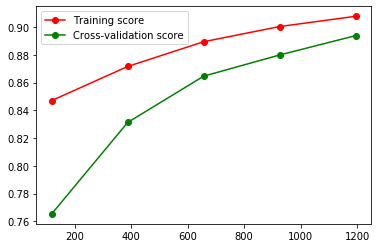

In [21]:
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
plt.legend(loc="best")

## CatBoost Classifier

In [22]:
from catboost import CatBoostClassifier

In [23]:
cb_chord_classifier = CatBoostClassifier()


будет около 25 итераций! продолжить их и закомитить

In [24]:
train_sizes, train_scores, test_scores = learning_curve(cb_chord_classifier, X_train, y_train, cv=5)

0:	learn: 2.1698909	total: 399ms	remaining: 6m 38s
1:	learn: 2.1490486	total: 617ms	remaining: 5m 7s
2:	learn: 2.1257364	total: 852ms	remaining: 4m 43s
3:	learn: 2.1040924	total: 1.03s	remaining: 4m 17s
4:	learn: 2.0779811	total: 1.23s	remaining: 4m 3s
5:	learn: 2.0511442	total: 1.39s	remaining: 3m 49s
6:	learn: 2.0322858	total: 1.56s	remaining: 3m 41s
7:	learn: 2.0045688	total: 1.72s	remaining: 3m 32s
8:	learn: 1.9851857	total: 1.9s	remaining: 3m 29s
9:	learn: 1.9584573	total: 2.1s	remaining: 3m 27s
10:	learn: 1.9413701	total: 2.24s	remaining: 3m 21s
11:	learn: 1.9203392	total: 2.36s	remaining: 3m 14s
12:	learn: 1.8940809	total: 2.47s	remaining: 3m 7s
13:	learn: 1.8712745	total: 2.58s	remaining: 3m 1s
14:	learn: 1.8454162	total: 2.7s	remaining: 2m 57s
15:	learn: 1.8224811	total: 2.82s	remaining: 2m 53s
16:	learn: 1.8001025	total: 2.93s	remaining: 2m 49s
17:	learn: 1.7770377	total: 3.1s	remaining: 2m 49s
18:	learn: 1.7581174	total: 3.3s	remaining: 2m 50s
19:	learn: 1.7370263	total: 3.4

160:	learn: 0.5089960	total: 22s	remaining: 1m 54s
161:	learn: 0.5054082	total: 22.1s	remaining: 1m 54s
162:	learn: 0.5022720	total: 22.2s	remaining: 1m 54s
163:	learn: 0.4984581	total: 22.3s	remaining: 1m 53s
164:	learn: 0.4949422	total: 22.4s	remaining: 1m 53s
165:	learn: 0.4910915	total: 22.6s	remaining: 1m 53s
166:	learn: 0.4877626	total: 22.8s	remaining: 1m 53s
167:	learn: 0.4841102	total: 23s	remaining: 1m 53s
168:	learn: 0.4805529	total: 23.1s	remaining: 1m 53s
169:	learn: 0.4769303	total: 23.3s	remaining: 1m 53s
170:	learn: 0.4729108	total: 23.5s	remaining: 1m 54s
171:	learn: 0.4698447	total: 23.8s	remaining: 1m 54s
172:	learn: 0.4668048	total: 24s	remaining: 1m 54s
173:	learn: 0.4634194	total: 24.1s	remaining: 1m 54s
174:	learn: 0.4609378	total: 24.3s	remaining: 1m 54s
175:	learn: 0.4578427	total: 24.4s	remaining: 1m 54s
176:	learn: 0.4547904	total: 24.5s	remaining: 1m 54s
177:	learn: 0.4521296	total: 24.7s	remaining: 1m 54s
178:	learn: 0.4494402	total: 24.8s	remaining: 1m 53s

316:	learn: 0.2065857	total: 42.7s	remaining: 1m 31s
317:	learn: 0.2055998	total: 42.8s	remaining: 1m 31s
318:	learn: 0.2048747	total: 42.9s	remaining: 1m 31s
319:	learn: 0.2036032	total: 43s	remaining: 1m 31s
320:	learn: 0.2026926	total: 43.1s	remaining: 1m 31s
321:	learn: 0.2015722	total: 43.2s	remaining: 1m 30s
322:	learn: 0.2007221	total: 43.3s	remaining: 1m 30s
323:	learn: 0.1998835	total: 43.4s	remaining: 1m 30s
324:	learn: 0.1986821	total: 43.5s	remaining: 1m 30s
325:	learn: 0.1978688	total: 43.7s	remaining: 1m 30s
326:	learn: 0.1971505	total: 43.9s	remaining: 1m 30s
327:	learn: 0.1962843	total: 44.1s	remaining: 1m 30s
328:	learn: 0.1954761	total: 44.2s	remaining: 1m 30s
329:	learn: 0.1945595	total: 44.3s	remaining: 1m 30s
330:	learn: 0.1938059	total: 44.5s	remaining: 1m 29s
331:	learn: 0.1931031	total: 44.6s	remaining: 1m 29s
332:	learn: 0.1923003	total: 44.7s	remaining: 1m 29s
333:	learn: 0.1914188	total: 44.8s	remaining: 1m 29s
334:	learn: 0.1907818	total: 44.9s	remaining: 1m

472:	learn: 0.1172672	total: 1m 2s	remaining: 1m 9s
473:	learn: 0.1169679	total: 1m 2s	remaining: 1m 9s
474:	learn: 0.1166515	total: 1m 2s	remaining: 1m 9s
475:	learn: 0.1162919	total: 1m 2s	remaining: 1m 9s
476:	learn: 0.1160088	total: 1m 3s	remaining: 1m 9s
477:	learn: 0.1157371	total: 1m 3s	remaining: 1m 9s
478:	learn: 0.1153794	total: 1m 3s	remaining: 1m 8s
479:	learn: 0.1150735	total: 1m 3s	remaining: 1m 8s
480:	learn: 0.1147635	total: 1m 3s	remaining: 1m 8s
481:	learn: 0.1144124	total: 1m 3s	remaining: 1m 8s
482:	learn: 0.1140778	total: 1m 3s	remaining: 1m 8s
483:	learn: 0.1137194	total: 1m 4s	remaining: 1m 8s
484:	learn: 0.1133989	total: 1m 4s	remaining: 1m 8s
485:	learn: 0.1131286	total: 1m 4s	remaining: 1m 8s
486:	learn: 0.1128089	total: 1m 4s	remaining: 1m 7s
487:	learn: 0.1125283	total: 1m 4s	remaining: 1m 7s
488:	learn: 0.1121627	total: 1m 4s	remaining: 1m 7s
489:	learn: 0.1118984	total: 1m 4s	remaining: 1m 7s
490:	learn: 0.1114273	total: 1m 4s	remaining: 1m 7s
491:	learn: 

630:	learn: 0.0789067	total: 1m 21s	remaining: 47.9s
631:	learn: 0.0787644	total: 1m 21s	remaining: 47.7s
632:	learn: 0.0785944	total: 1m 22s	remaining: 47.6s
633:	learn: 0.0784398	total: 1m 22s	remaining: 47.5s
634:	learn: 0.0782658	total: 1m 22s	remaining: 47.4s
635:	learn: 0.0781061	total: 1m 22s	remaining: 47.2s
636:	learn: 0.0779777	total: 1m 22s	remaining: 47.1s
637:	learn: 0.0778454	total: 1m 22s	remaining: 47s
638:	learn: 0.0776731	total: 1m 22s	remaining: 46.9s
639:	learn: 0.0774822	total: 1m 23s	remaining: 46.7s
640:	learn: 0.0773286	total: 1m 23s	remaining: 46.6s
641:	learn: 0.0770864	total: 1m 23s	remaining: 46.5s
642:	learn: 0.0769243	total: 1m 23s	remaining: 46.4s
643:	learn: 0.0767811	total: 1m 23s	remaining: 46.2s
644:	learn: 0.0766683	total: 1m 23s	remaining: 46.1s
645:	learn: 0.0765090	total: 1m 23s	remaining: 46s
646:	learn: 0.0763547	total: 1m 24s	remaining: 45.9s
647:	learn: 0.0762299	total: 1m 24s	remaining: 45.7s
648:	learn: 0.0760788	total: 1m 24s	remaining: 45.

786:	learn: 0.0588961	total: 1m 41s	remaining: 27.6s
787:	learn: 0.0588011	total: 1m 42s	remaining: 27.4s
788:	learn: 0.0586929	total: 1m 42s	remaining: 27.3s
789:	learn: 0.0586169	total: 1m 42s	remaining: 27.2s
790:	learn: 0.0585014	total: 1m 42s	remaining: 27s
791:	learn: 0.0584020	total: 1m 42s	remaining: 26.9s
792:	learn: 0.0582941	total: 1m 42s	remaining: 26.8s
793:	learn: 0.0581861	total: 1m 42s	remaining: 26.6s
794:	learn: 0.0580956	total: 1m 42s	remaining: 26.5s
795:	learn: 0.0580227	total: 1m 42s	remaining: 26.4s
796:	learn: 0.0579265	total: 1m 43s	remaining: 26.2s
797:	learn: 0.0578387	total: 1m 43s	remaining: 26.1s
798:	learn: 0.0577506	total: 1m 43s	remaining: 26s
799:	learn: 0.0576176	total: 1m 43s	remaining: 25.9s
800:	learn: 0.0575171	total: 1m 43s	remaining: 25.7s
801:	learn: 0.0574157	total: 1m 43s	remaining: 25.6s
802:	learn: 0.0573180	total: 1m 43s	remaining: 25.5s
803:	learn: 0.0572243	total: 1m 44s	remaining: 25.4s
804:	learn: 0.0571065	total: 1m 44s	remaining: 25.

942:	learn: 0.0461517	total: 2m 2s	remaining: 7.41s
943:	learn: 0.0461036	total: 2m 2s	remaining: 7.28s
944:	learn: 0.0460522	total: 2m 2s	remaining: 7.15s
945:	learn: 0.0459922	total: 2m 3s	remaining: 7.02s
946:	learn: 0.0459400	total: 2m 3s	remaining: 6.89s
947:	learn: 0.0458900	total: 2m 3s	remaining: 6.76s
948:	learn: 0.0458036	total: 2m 3s	remaining: 6.63s
949:	learn: 0.0457137	total: 2m 3s	remaining: 6.5s
950:	learn: 0.0456587	total: 2m 3s	remaining: 6.37s
951:	learn: 0.0456063	total: 2m 3s	remaining: 6.24s
952:	learn: 0.0455346	total: 2m 3s	remaining: 6.11s
953:	learn: 0.0454717	total: 2m 4s	remaining: 5.98s
954:	learn: 0.0453987	total: 2m 4s	remaining: 5.85s
955:	learn: 0.0453209	total: 2m 4s	remaining: 5.72s
956:	learn: 0.0452499	total: 2m 4s	remaining: 5.59s
957:	learn: 0.0451931	total: 2m 4s	remaining: 5.46s
958:	learn: 0.0451403	total: 2m 4s	remaining: 5.33s
959:	learn: 0.0450789	total: 2m 4s	remaining: 5.2s
960:	learn: 0.0450310	total: 2m 4s	remaining: 5.07s
961:	learn: 0.

101:	learn: 0.5392177	total: 38.5s	remaining: 5m 39s
102:	learn: 0.5348582	total: 38.9s	remaining: 5m 39s
103:	learn: 0.5304508	total: 39.3s	remaining: 5m 38s
104:	learn: 0.5262546	total: 39.7s	remaining: 5m 38s
105:	learn: 0.5224699	total: 40.1s	remaining: 5m 37s
106:	learn: 0.5180434	total: 40.4s	remaining: 5m 37s
107:	learn: 0.5133213	total: 40.8s	remaining: 5m 36s
108:	learn: 0.5094989	total: 41.1s	remaining: 5m 35s
109:	learn: 0.5059454	total: 41.4s	remaining: 5m 35s
110:	learn: 0.5013312	total: 41.8s	remaining: 5m 34s
111:	learn: 0.4973744	total: 42.2s	remaining: 5m 34s
112:	learn: 0.4936661	total: 42.6s	remaining: 5m 34s
113:	learn: 0.4894041	total: 43s	remaining: 5m 33s
114:	learn: 0.4855513	total: 43.3s	remaining: 5m 33s
115:	learn: 0.4812436	total: 43.6s	remaining: 5m 32s
116:	learn: 0.4777537	total: 43.9s	remaining: 5m 31s
117:	learn: 0.4736087	total: 44.2s	remaining: 5m 30s
118:	learn: 0.4699221	total: 44.7s	remaining: 5m 30s
119:	learn: 0.4660141	total: 45.1s	remaining: 5m

256:	learn: 0.2125864	total: 1m 39s	remaining: 4m 46s
257:	learn: 0.2114688	total: 1m 39s	remaining: 4m 46s
258:	learn: 0.2105885	total: 1m 39s	remaining: 4m 46s
259:	learn: 0.2094179	total: 1m 40s	remaining: 4m 45s
260:	learn: 0.2086540	total: 1m 40s	remaining: 4m 45s
261:	learn: 0.2079248	total: 1m 41s	remaining: 4m 45s
262:	learn: 0.2068080	total: 1m 41s	remaining: 4m 44s
263:	learn: 0.2059616	total: 1m 42s	remaining: 4m 44s
264:	learn: 0.2049872	total: 1m 42s	remaining: 4m 43s
265:	learn: 0.2041217	total: 1m 42s	remaining: 4m 43s
266:	learn: 0.2030016	total: 1m 43s	remaining: 4m 42s
267:	learn: 0.2018699	total: 1m 43s	remaining: 4m 42s
268:	learn: 0.2011141	total: 1m 43s	remaining: 4m 42s
269:	learn: 0.2003599	total: 1m 44s	remaining: 4m 41s
270:	learn: 0.1996605	total: 1m 44s	remaining: 4m 41s
271:	learn: 0.1988763	total: 1m 44s	remaining: 4m 40s
272:	learn: 0.1979652	total: 1m 45s	remaining: 4m 40s
273:	learn: 0.1970333	total: 1m 45s	remaining: 4m 39s
274:	learn: 0.1962752	total:

409:	learn: 0.1186005	total: 2m 30s	remaining: 3m 37s
410:	learn: 0.1183169	total: 2m 31s	remaining: 3m 36s
411:	learn: 0.1179491	total: 2m 31s	remaining: 3m 36s
412:	learn: 0.1175890	total: 2m 31s	remaining: 3m 35s
413:	learn: 0.1171744	total: 2m 32s	remaining: 3m 35s
414:	learn: 0.1168331	total: 2m 32s	remaining: 3m 34s
415:	learn: 0.1163985	total: 2m 32s	remaining: 3m 34s
416:	learn: 0.1160822	total: 2m 33s	remaining: 3m 34s
417:	learn: 0.1158257	total: 2m 33s	remaining: 3m 33s
418:	learn: 0.1155395	total: 2m 33s	remaining: 3m 33s
419:	learn: 0.1152717	total: 2m 34s	remaining: 3m 32s
420:	learn: 0.1149565	total: 2m 34s	remaining: 3m 32s
421:	learn: 0.1145817	total: 2m 34s	remaining: 3m 31s
422:	learn: 0.1142535	total: 2m 35s	remaining: 3m 31s
423:	learn: 0.1137651	total: 2m 35s	remaining: 3m 31s
424:	learn: 0.1134524	total: 2m 35s	remaining: 3m 30s
425:	learn: 0.1130899	total: 2m 36s	remaining: 3m 30s
426:	learn: 0.1127600	total: 2m 36s	remaining: 3m 29s
427:	learn: 0.1124328	total:

563:	learn: 0.0788299	total: 3m 24s	remaining: 2m 37s
564:	learn: 0.0786831	total: 3m 24s	remaining: 2m 37s
565:	learn: 0.0784621	total: 3m 24s	remaining: 2m 36s
566:	learn: 0.0783426	total: 3m 25s	remaining: 2m 36s
567:	learn: 0.0781725	total: 3m 25s	remaining: 2m 36s
568:	learn: 0.0780348	total: 3m 25s	remaining: 2m 35s
569:	learn: 0.0778803	total: 3m 26s	remaining: 2m 35s
570:	learn: 0.0777000	total: 3m 26s	remaining: 2m 35s
571:	learn: 0.0775583	total: 3m 26s	remaining: 2m 34s
572:	learn: 0.0774312	total: 3m 26s	remaining: 2m 34s
573:	learn: 0.0771930	total: 3m 27s	remaining: 2m 33s
574:	learn: 0.0769884	total: 3m 27s	remaining: 2m 33s
575:	learn: 0.0768555	total: 3m 27s	remaining: 2m 33s
576:	learn: 0.0766923	total: 3m 28s	remaining: 2m 32s
577:	learn: 0.0765457	total: 3m 28s	remaining: 2m 32s
578:	learn: 0.0764273	total: 3m 28s	remaining: 2m 31s
579:	learn: 0.0762483	total: 3m 29s	remaining: 2m 31s
580:	learn: 0.0760903	total: 3m 29s	remaining: 2m 31s
581:	learn: 0.0759077	total:

717:	learn: 0.0577537	total: 4m 14s	remaining: 1m 40s
718:	learn: 0.0576243	total: 4m 15s	remaining: 1m 39s
719:	learn: 0.0575500	total: 4m 15s	remaining: 1m 39s
720:	learn: 0.0574460	total: 4m 15s	remaining: 1m 38s
721:	learn: 0.0573512	total: 4m 16s	remaining: 1m 38s
722:	learn: 0.0572419	total: 4m 16s	remaining: 1m 38s
723:	learn: 0.0571741	total: 4m 16s	remaining: 1m 37s
724:	learn: 0.0570486	total: 4m 16s	remaining: 1m 37s
725:	learn: 0.0569855	total: 4m 17s	remaining: 1m 37s
726:	learn: 0.0568960	total: 4m 17s	remaining: 1m 36s
727:	learn: 0.0567694	total: 4m 17s	remaining: 1m 36s
728:	learn: 0.0566848	total: 4m 18s	remaining: 1m 36s
729:	learn: 0.0566259	total: 4m 18s	remaining: 1m 35s
730:	learn: 0.0565666	total: 4m 18s	remaining: 1m 35s
731:	learn: 0.0564450	total: 4m 19s	remaining: 1m 34s
732:	learn: 0.0563440	total: 4m 19s	remaining: 1m 34s
733:	learn: 0.0562732	total: 4m 19s	remaining: 1m 34s
734:	learn: 0.0562077	total: 4m 20s	remaining: 1m 33s
735:	learn: 0.0561424	total:

871:	learn: 0.0448576	total: 5m 8s	remaining: 45.3s
872:	learn: 0.0447508	total: 5m 9s	remaining: 45s
873:	learn: 0.0446720	total: 5m 9s	remaining: 44.6s
874:	learn: 0.0445999	total: 5m 9s	remaining: 44.3s
875:	learn: 0.0445449	total: 5m 10s	remaining: 43.9s
876:	learn: 0.0444780	total: 5m 10s	remaining: 43.5s
877:	learn: 0.0444042	total: 5m 10s	remaining: 43.2s
878:	learn: 0.0443499	total: 5m 11s	remaining: 42.8s
879:	learn: 0.0442712	total: 5m 11s	remaining: 42.5s
880:	learn: 0.0442011	total: 5m 11s	remaining: 42.1s
881:	learn: 0.0441489	total: 5m 12s	remaining: 41.7s
882:	learn: 0.0440888	total: 5m 12s	remaining: 41.4s
883:	learn: 0.0440270	total: 5m 12s	remaining: 41s
884:	learn: 0.0439890	total: 5m 13s	remaining: 40.7s
885:	learn: 0.0439257	total: 5m 13s	remaining: 40.3s
886:	learn: 0.0438904	total: 5m 13s	remaining: 40s
887:	learn: 0.0438000	total: 5m 14s	remaining: 39.6s
888:	learn: 0.0437576	total: 5m 14s	remaining: 39.3s
889:	learn: 0.0436867	total: 5m 14s	remaining: 38.9s
890

28:	learn: 1.1402660	total: 7.39s	remaining: 4m 7s
29:	learn: 1.1222358	total: 7.67s	remaining: 4m 8s
30:	learn: 1.1012358	total: 7.96s	remaining: 4m 8s
31:	learn: 1.0799875	total: 8.3s	remaining: 4m 11s
32:	learn: 1.0599928	total: 8.64s	remaining: 4m 13s
33:	learn: 1.0417972	total: 8.98s	remaining: 4m 15s
34:	learn: 1.0237720	total: 9.27s	remaining: 4m 15s
35:	learn: 1.0066003	total: 9.7s	remaining: 4m 19s
36:	learn: 0.9907520	total: 10s	remaining: 4m 20s
37:	learn: 0.9739719	total: 10.3s	remaining: 4m 21s
38:	learn: 0.9592598	total: 10.6s	remaining: 4m 22s
39:	learn: 0.9436332	total: 10.9s	remaining: 4m 22s
40:	learn: 0.9275927	total: 11.2s	remaining: 4m 22s
41:	learn: 0.9140885	total: 11.5s	remaining: 4m 23s
42:	learn: 0.9010207	total: 11.8s	remaining: 4m 23s
43:	learn: 0.8872338	total: 12.1s	remaining: 4m 23s
44:	learn: 0.8736748	total: 12.4s	remaining: 4m 23s
45:	learn: 0.8598391	total: 12.7s	remaining: 4m 24s
46:	learn: 0.8488023	total: 13s	remaining: 4m 23s
47:	learn: 0.8356866	

186:	learn: 0.2581368	total: 45.3s	remaining: 3m 16s
187:	learn: 0.2569324	total: 45.6s	remaining: 3m 16s
188:	learn: 0.2556939	total: 45.8s	remaining: 3m 16s
189:	learn: 0.2543826	total: 46.1s	remaining: 3m 16s
190:	learn: 0.2528799	total: 46.4s	remaining: 3m 16s
191:	learn: 0.2515556	total: 46.6s	remaining: 3m 16s
192:	learn: 0.2505256	total: 46.9s	remaining: 3m 16s
193:	learn: 0.2492366	total: 47.2s	remaining: 3m 16s
194:	learn: 0.2476986	total: 47.4s	remaining: 3m 15s
195:	learn: 0.2462154	total: 47.7s	remaining: 3m 15s
196:	learn: 0.2449377	total: 48s	remaining: 3m 15s
197:	learn: 0.2440044	total: 48.2s	remaining: 3m 15s
198:	learn: 0.2429031	total: 48.5s	remaining: 3m 15s
199:	learn: 0.2417547	total: 48.8s	remaining: 3m 15s
200:	learn: 0.2405709	total: 49s	remaining: 3m 14s
201:	learn: 0.2393502	total: 49.2s	remaining: 3m 14s
202:	learn: 0.2381302	total: 49.4s	remaining: 3m 13s
203:	learn: 0.2370338	total: 49.6s	remaining: 3m 13s
204:	learn: 0.2357456	total: 49.8s	remaining: 3m 1

341:	learn: 0.1393898	total: 1m 24s	remaining: 2m 43s
342:	learn: 0.1389302	total: 1m 25s	remaining: 2m 43s
343:	learn: 0.1385813	total: 1m 25s	remaining: 2m 43s
344:	learn: 0.1382055	total: 1m 26s	remaining: 2m 43s
345:	learn: 0.1377655	total: 1m 26s	remaining: 2m 43s
346:	learn: 0.1373745	total: 1m 26s	remaining: 2m 43s
347:	learn: 0.1370020	total: 1m 27s	remaining: 2m 43s
348:	learn: 0.1365904	total: 1m 27s	remaining: 2m 43s
349:	learn: 0.1363760	total: 1m 27s	remaining: 2m 42s
350:	learn: 0.1359982	total: 1m 27s	remaining: 2m 42s
351:	learn: 0.1355325	total: 1m 28s	remaining: 2m 42s
352:	learn: 0.1352110	total: 1m 28s	remaining: 2m 42s
353:	learn: 0.1348883	total: 1m 28s	remaining: 2m 42s
354:	learn: 0.1344767	total: 1m 29s	remaining: 2m 41s
355:	learn: 0.1340904	total: 1m 29s	remaining: 2m 41s
356:	learn: 0.1336792	total: 1m 29s	remaining: 2m 41s
357:	learn: 0.1331197	total: 1m 29s	remaining: 2m 41s
358:	learn: 0.1325659	total: 1m 30s	remaining: 2m 41s
359:	learn: 0.1322575	total:

494:	learn: 0.0924683	total: 2m 4s	remaining: 2m 7s
495:	learn: 0.0922288	total: 2m 5s	remaining: 2m 7s
496:	learn: 0.0920099	total: 2m 5s	remaining: 2m 6s
497:	learn: 0.0917362	total: 2m 5s	remaining: 2m 6s
498:	learn: 0.0915482	total: 2m 5s	remaining: 2m 6s
499:	learn: 0.0914130	total: 2m 6s	remaining: 2m 6s
500:	learn: 0.0910801	total: 2m 6s	remaining: 2m 5s
501:	learn: 0.0908850	total: 2m 6s	remaining: 2m 5s
502:	learn: 0.0906775	total: 2m 6s	remaining: 2m 5s
503:	learn: 0.0905337	total: 2m 6s	remaining: 2m 4s
504:	learn: 0.0903175	total: 2m 7s	remaining: 2m 4s
505:	learn: 0.0900981	total: 2m 7s	remaining: 2m 4s
506:	learn: 0.0899006	total: 2m 7s	remaining: 2m 4s
507:	learn: 0.0896285	total: 2m 7s	remaining: 2m 3s
508:	learn: 0.0894129	total: 2m 8s	remaining: 2m 3s
509:	learn: 0.0893084	total: 2m 8s	remaining: 2m 3s
510:	learn: 0.0891197	total: 2m 8s	remaining: 2m 3s
511:	learn: 0.0889012	total: 2m 8s	remaining: 2m 2s
512:	learn: 0.0887128	total: 2m 9s	remaining: 2m 2s
513:	learn: 

647:	learn: 0.0670344	total: 2m 45s	remaining: 1m 30s
648:	learn: 0.0669058	total: 2m 46s	remaining: 1m 29s
649:	learn: 0.0667718	total: 2m 46s	remaining: 1m 29s
650:	learn: 0.0665197	total: 2m 46s	remaining: 1m 29s
651:	learn: 0.0663488	total: 2m 46s	remaining: 1m 29s
652:	learn: 0.0662281	total: 2m 46s	remaining: 1m 28s
653:	learn: 0.0660666	total: 2m 47s	remaining: 1m 28s
654:	learn: 0.0659673	total: 2m 47s	remaining: 1m 28s
655:	learn: 0.0658685	total: 2m 47s	remaining: 1m 27s
656:	learn: 0.0657221	total: 2m 47s	remaining: 1m 27s
657:	learn: 0.0656309	total: 2m 48s	remaining: 1m 27s
658:	learn: 0.0655282	total: 2m 48s	remaining: 1m 27s
659:	learn: 0.0654112	total: 2m 48s	remaining: 1m 26s
660:	learn: 0.0653152	total: 2m 48s	remaining: 1m 26s
661:	learn: 0.0652178	total: 2m 48s	remaining: 1m 26s
662:	learn: 0.0651164	total: 2m 49s	remaining: 1m 26s
663:	learn: 0.0650155	total: 2m 49s	remaining: 1m 25s
664:	learn: 0.0648943	total: 2m 49s	remaining: 1m 25s
665:	learn: 0.0647740	total:

802:	learn: 0.0509884	total: 3m 24s	remaining: 50.1s
803:	learn: 0.0508571	total: 3m 24s	remaining: 49.9s
804:	learn: 0.0507829	total: 3m 24s	remaining: 49.6s
805:	learn: 0.0506998	total: 3m 25s	remaining: 49.4s
806:	learn: 0.0505796	total: 3m 25s	remaining: 49.1s
807:	learn: 0.0504950	total: 3m 25s	remaining: 48.9s
808:	learn: 0.0503944	total: 3m 25s	remaining: 48.6s
809:	learn: 0.0503633	total: 3m 26s	remaining: 48.4s
810:	learn: 0.0502701	total: 3m 26s	remaining: 48.1s
811:	learn: 0.0501807	total: 3m 26s	remaining: 47.9s
812:	learn: 0.0501314	total: 3m 27s	remaining: 47.7s
813:	learn: 0.0500416	total: 3m 27s	remaining: 47.4s
814:	learn: 0.0500034	total: 3m 27s	remaining: 47.2s
815:	learn: 0.0499348	total: 3m 28s	remaining: 47s
816:	learn: 0.0498447	total: 3m 28s	remaining: 46.7s
817:	learn: 0.0497915	total: 3m 28s	remaining: 46.5s
818:	learn: 0.0496918	total: 3m 29s	remaining: 46.2s
819:	learn: 0.0495769	total: 3m 29s	remaining: 46s
820:	learn: 0.0495347	total: 3m 29s	remaining: 45.

958:	learn: 0.0405763	total: 4m 3s	remaining: 10.4s
959:	learn: 0.0405395	total: 4m 3s	remaining: 10.2s
960:	learn: 0.0404821	total: 4m 3s	remaining: 9.9s
961:	learn: 0.0404253	total: 4m 4s	remaining: 9.65s
962:	learn: 0.0403799	total: 4m 4s	remaining: 9.39s
963:	learn: 0.0403527	total: 4m 4s	remaining: 9.14s
964:	learn: 0.0402837	total: 4m 5s	remaining: 8.89s
965:	learn: 0.0402559	total: 4m 5s	remaining: 8.64s
966:	learn: 0.0402303	total: 4m 5s	remaining: 8.38s
967:	learn: 0.0401797	total: 4m 5s	remaining: 8.13s
968:	learn: 0.0401199	total: 4m 6s	remaining: 7.88s
969:	learn: 0.0400973	total: 4m 6s	remaining: 7.63s
970:	learn: 0.0400014	total: 4m 6s	remaining: 7.37s
971:	learn: 0.0399162	total: 4m 7s	remaining: 7.12s
972:	learn: 0.0398755	total: 4m 7s	remaining: 6.87s
973:	learn: 0.0398471	total: 4m 7s	remaining: 6.61s
974:	learn: 0.0398212	total: 4m 8s	remaining: 6.36s
975:	learn: 0.0397537	total: 4m 8s	remaining: 6.11s
976:	learn: 0.0396704	total: 4m 8s	remaining: 5.85s
977:	learn: 0

116:	learn: 0.3704969	total: 30.2s	remaining: 3m 47s
117:	learn: 0.3674334	total: 30.5s	remaining: 3m 47s
118:	learn: 0.3646582	total: 30.7s	remaining: 3m 47s
119:	learn: 0.3621096	total: 31s	remaining: 3m 47s
120:	learn: 0.3589724	total: 31.3s	remaining: 3m 47s
121:	learn: 0.3563088	total: 31.5s	remaining: 3m 46s
122:	learn: 0.3533612	total: 31.8s	remaining: 3m 46s
123:	learn: 0.3505907	total: 32.1s	remaining: 3m 46s
124:	learn: 0.3479037	total: 32.4s	remaining: 3m 46s
125:	learn: 0.3454000	total: 32.7s	remaining: 3m 46s
126:	learn: 0.3428546	total: 33s	remaining: 3m 46s
127:	learn: 0.3406540	total: 33.3s	remaining: 3m 47s
128:	learn: 0.3380920	total: 33.6s	remaining: 3m 47s
129:	learn: 0.3354028	total: 33.9s	remaining: 3m 47s
130:	learn: 0.3330925	total: 34.3s	remaining: 3m 47s
131:	learn: 0.3308250	total: 34.6s	remaining: 3m 47s
132:	learn: 0.3286264	total: 34.8s	remaining: 3m 47s
133:	learn: 0.3262074	total: 35.1s	remaining: 3m 47s
134:	learn: 0.3238175	total: 35.4s	remaining: 3m 4

272:	learn: 0.1664614	total: 1m 10s	remaining: 3m 7s
273:	learn: 0.1657964	total: 1m 10s	remaining: 3m 7s
274:	learn: 0.1652259	total: 1m 10s	remaining: 3m 6s
275:	learn: 0.1647273	total: 1m 11s	remaining: 3m 6s
276:	learn: 0.1642880	total: 1m 11s	remaining: 3m 6s
277:	learn: 0.1637638	total: 1m 11s	remaining: 3m 6s
278:	learn: 0.1632231	total: 1m 11s	remaining: 3m 5s
279:	learn: 0.1626030	total: 1m 12s	remaining: 3m 5s
280:	learn: 0.1619081	total: 1m 12s	remaining: 3m 5s
281:	learn: 0.1614095	total: 1m 12s	remaining: 3m 5s
282:	learn: 0.1608695	total: 1m 12s	remaining: 3m 4s
283:	learn: 0.1602288	total: 1m 13s	remaining: 3m 4s
284:	learn: 0.1595520	total: 1m 13s	remaining: 3m 4s
285:	learn: 0.1589217	total: 1m 13s	remaining: 3m 3s
286:	learn: 0.1583771	total: 1m 13s	remaining: 3m 3s
287:	learn: 0.1579252	total: 1m 14s	remaining: 3m 2s
288:	learn: 0.1574735	total: 1m 14s	remaining: 3m 2s
289:	learn: 0.1570128	total: 1m 14s	remaining: 3m 2s
290:	learn: 0.1565211	total: 1m 14s	remaining:

425:	learn: 0.1044472	total: 1m 46s	remaining: 2m 23s
426:	learn: 0.1042068	total: 1m 46s	remaining: 2m 22s
427:	learn: 0.1040017	total: 1m 46s	remaining: 2m 22s
428:	learn: 0.1036451	total: 1m 46s	remaining: 2m 22s
429:	learn: 0.1033055	total: 1m 47s	remaining: 2m 22s
430:	learn: 0.1030069	total: 1m 47s	remaining: 2m 21s
431:	learn: 0.1026797	total: 1m 47s	remaining: 2m 21s
432:	learn: 0.1024258	total: 1m 47s	remaining: 2m 21s
433:	learn: 0.1020693	total: 1m 48s	remaining: 2m 20s
434:	learn: 0.1018944	total: 1m 48s	remaining: 2m 20s
435:	learn: 0.1015545	total: 1m 48s	remaining: 2m 20s
436:	learn: 0.1012248	total: 1m 48s	remaining: 2m 19s
437:	learn: 0.1008343	total: 1m 48s	remaining: 2m 19s
438:	learn: 0.1005019	total: 1m 49s	remaining: 2m 19s
439:	learn: 0.1002739	total: 1m 49s	remaining: 2m 19s
440:	learn: 0.1000368	total: 1m 49s	remaining: 2m 18s
441:	learn: 0.0997112	total: 1m 49s	remaining: 2m 18s
442:	learn: 0.0994341	total: 1m 49s	remaining: 2m 18s
443:	learn: 0.0991764	total:

579:	learn: 0.0726495	total: 2m 21s	remaining: 1m 42s
580:	learn: 0.0724751	total: 2m 21s	remaining: 1m 42s
581:	learn: 0.0722829	total: 2m 22s	remaining: 1m 42s
582:	learn: 0.0720867	total: 2m 22s	remaining: 1m 41s
583:	learn: 0.0719033	total: 2m 22s	remaining: 1m 41s
584:	learn: 0.0717506	total: 2m 22s	remaining: 1m 41s
585:	learn: 0.0715457	total: 2m 22s	remaining: 1m 41s
586:	learn: 0.0713278	total: 2m 23s	remaining: 1m 40s
587:	learn: 0.0711873	total: 2m 23s	remaining: 1m 40s
588:	learn: 0.0710254	total: 2m 23s	remaining: 1m 40s
589:	learn: 0.0708867	total: 2m 23s	remaining: 1m 39s
590:	learn: 0.0707859	total: 2m 24s	remaining: 1m 39s
591:	learn: 0.0706470	total: 2m 24s	remaining: 1m 39s
592:	learn: 0.0704644	total: 2m 24s	remaining: 1m 39s
593:	learn: 0.0703587	total: 2m 24s	remaining: 1m 38s
594:	learn: 0.0703081	total: 2m 24s	remaining: 1m 38s
595:	learn: 0.0700951	total: 2m 25s	remaining: 1m 38s
596:	learn: 0.0699480	total: 2m 25s	remaining: 1m 38s
597:	learn: 0.0698519	total:

732:	learn: 0.0544665	total: 3m 2s	remaining: 1m 6s
733:	learn: 0.0543876	total: 3m 2s	remaining: 1m 6s
734:	learn: 0.0542808	total: 3m 2s	remaining: 1m 5s
735:	learn: 0.0542127	total: 3m 2s	remaining: 1m 5s
736:	learn: 0.0541151	total: 3m 3s	remaining: 1m 5s
737:	learn: 0.0540350	total: 3m 3s	remaining: 1m 5s
738:	learn: 0.0539389	total: 3m 3s	remaining: 1m 4s
739:	learn: 0.0538538	total: 3m 3s	remaining: 1m 4s
740:	learn: 0.0537897	total: 3m 3s	remaining: 1m 4s
741:	learn: 0.0536982	total: 3m 4s	remaining: 1m 4s
742:	learn: 0.0536399	total: 3m 4s	remaining: 1m 3s
743:	learn: 0.0535522	total: 3m 4s	remaining: 1m 3s
744:	learn: 0.0534572	total: 3m 4s	remaining: 1m 3s
745:	learn: 0.0533751	total: 3m 5s	remaining: 1m 3s
746:	learn: 0.0532711	total: 3m 5s	remaining: 1m 2s
747:	learn: 0.0531529	total: 3m 5s	remaining: 1m 2s
748:	learn: 0.0530841	total: 3m 5s	remaining: 1m 2s
749:	learn: 0.0530061	total: 3m 6s	remaining: 1m 2s
750:	learn: 0.0529277	total: 3m 6s	remaining: 1m 1s
751:	learn: 

889:	learn: 0.0426622	total: 3m 40s	remaining: 27.2s
890:	learn: 0.0426059	total: 3m 40s	remaining: 27s
891:	learn: 0.0425310	total: 3m 40s	remaining: 26.7s
892:	learn: 0.0424482	total: 3m 40s	remaining: 26.5s
893:	learn: 0.0423787	total: 3m 41s	remaining: 26.2s
894:	learn: 0.0422983	total: 3m 41s	remaining: 26s
895:	learn: 0.0422322	total: 3m 41s	remaining: 25.7s
896:	learn: 0.0422037	total: 3m 41s	remaining: 25.5s
897:	learn: 0.0421342	total: 3m 42s	remaining: 25.2s
898:	learn: 0.0420910	total: 3m 42s	remaining: 25s
899:	learn: 0.0420390	total: 3m 42s	remaining: 24.7s
900:	learn: 0.0420091	total: 3m 42s	remaining: 24.5s
901:	learn: 0.0419544	total: 3m 42s	remaining: 24.2s
902:	learn: 0.0419059	total: 3m 43s	remaining: 24s
903:	learn: 0.0418318	total: 3m 43s	remaining: 23.7s
904:	learn: 0.0417716	total: 3m 43s	remaining: 23.5s
905:	learn: 0.0416750	total: 3m 43s	remaining: 23.2s
906:	learn: 0.0416199	total: 3m 43s	remaining: 23s
907:	learn: 0.0415293	total: 3m 44s	remaining: 22.7s
908

47:	learn: 0.7388130	total: 11.4s	remaining: 3m 46s
48:	learn: 0.7277619	total: 11.7s	remaining: 3m 46s
49:	learn: 0.7174966	total: 11.9s	remaining: 3m 45s
50:	learn: 0.7075681	total: 12.1s	remaining: 3m 45s
51:	learn: 0.6966025	total: 12.3s	remaining: 3m 44s
52:	learn: 0.6868532	total: 12.5s	remaining: 3m 44s
53:	learn: 0.6767014	total: 12.8s	remaining: 3m 43s
54:	learn: 0.6674946	total: 13s	remaining: 3m 43s
55:	learn: 0.6597500	total: 13.2s	remaining: 3m 42s
56:	learn: 0.6502873	total: 13.4s	remaining: 3m 42s
57:	learn: 0.6418021	total: 13.6s	remaining: 3m 41s
58:	learn: 0.6329995	total: 13.9s	remaining: 3m 41s
59:	learn: 0.6255951	total: 14.1s	remaining: 3m 40s
60:	learn: 0.6178349	total: 14.3s	remaining: 3m 40s
61:	learn: 0.6102079	total: 14.5s	remaining: 3m 39s
62:	learn: 0.6022826	total: 14.7s	remaining: 3m 39s
63:	learn: 0.5944584	total: 15s	remaining: 3m 39s
64:	learn: 0.5867331	total: 15.2s	remaining: 3m 38s
65:	learn: 0.5796166	total: 15.4s	remaining: 3m 38s
66:	learn: 0.572

204:	learn: 0.2124336	total: 49.5s	remaining: 3m 12s
205:	learn: 0.2114200	total: 49.8s	remaining: 3m 11s
206:	learn: 0.2104947	total: 50s	remaining: 3m 11s
207:	learn: 0.2094612	total: 50.2s	remaining: 3m 11s
208:	learn: 0.2086265	total: 50.4s	remaining: 3m 10s
209:	learn: 0.2077534	total: 50.6s	remaining: 3m 10s
210:	learn: 0.2067378	total: 50.9s	remaining: 3m 10s
211:	learn: 0.2058541	total: 51.1s	remaining: 3m 9s
212:	learn: 0.2048669	total: 51.3s	remaining: 3m 9s
213:	learn: 0.2039962	total: 51.5s	remaining: 3m 9s
214:	learn: 0.2031471	total: 51.8s	remaining: 3m 8s
215:	learn: 0.2022962	total: 52s	remaining: 3m 8s
216:	learn: 0.2013338	total: 52.2s	remaining: 3m 8s
217:	learn: 0.2003069	total: 52.4s	remaining: 3m 7s
218:	learn: 0.1994882	total: 52.6s	remaining: 3m 7s
219:	learn: 0.1986479	total: 52.8s	remaining: 3m 7s
220:	learn: 0.1977337	total: 53.1s	remaining: 3m 7s
221:	learn: 0.1969355	total: 53.4s	remaining: 3m 7s
222:	learn: 0.1959106	total: 53.6s	remaining: 3m 6s
223:	lear

359:	learn: 0.1223358	total: 1m 27s	remaining: 2m 36s
360:	learn: 0.1218792	total: 1m 28s	remaining: 2m 35s
361:	learn: 0.1215183	total: 1m 28s	remaining: 2m 35s
362:	learn: 0.1211417	total: 1m 28s	remaining: 2m 35s
363:	learn: 0.1208566	total: 1m 28s	remaining: 2m 35s
364:	learn: 0.1205189	total: 1m 28s	remaining: 2m 34s
365:	learn: 0.1201431	total: 1m 29s	remaining: 2m 34s
366:	learn: 0.1197810	total: 1m 29s	remaining: 2m 34s
367:	learn: 0.1194172	total: 1m 29s	remaining: 2m 33s
368:	learn: 0.1190843	total: 1m 29s	remaining: 2m 33s
369:	learn: 0.1188044	total: 1m 30s	remaining: 2m 33s
370:	learn: 0.1185459	total: 1m 30s	remaining: 2m 33s
371:	learn: 0.1182829	total: 1m 30s	remaining: 2m 33s
372:	learn: 0.1180204	total: 1m 30s	remaining: 2m 32s
373:	learn: 0.1177287	total: 1m 31s	remaining: 2m 32s
374:	learn: 0.1173004	total: 1m 31s	remaining: 2m 32s
375:	learn: 0.1168377	total: 1m 31s	remaining: 2m 32s
376:	learn: 0.1165778	total: 1m 31s	remaining: 2m 32s
377:	learn: 0.1162468	total:

513:	learn: 0.0843704	total: 2m 8s	remaining: 2m 1s
514:	learn: 0.0841386	total: 2m 8s	remaining: 2m 1s
515:	learn: 0.0839679	total: 2m 8s	remaining: 2m
516:	learn: 0.0838318	total: 2m 9s	remaining: 2m
517:	learn: 0.0836242	total: 2m 9s	remaining: 2m
518:	learn: 0.0834605	total: 2m 9s	remaining: 2m
519:	learn: 0.0833208	total: 2m 9s	remaining: 1m 59s
520:	learn: 0.0831140	total: 2m 10s	remaining: 1m 59s
521:	learn: 0.0829628	total: 2m 10s	remaining: 1m 59s
522:	learn: 0.0828290	total: 2m 10s	remaining: 1m 59s
523:	learn: 0.0826379	total: 2m 11s	remaining: 1m 59s
524:	learn: 0.0824894	total: 2m 11s	remaining: 1m 58s
525:	learn: 0.0823419	total: 2m 11s	remaining: 1m 58s
526:	learn: 0.0821561	total: 2m 11s	remaining: 1m 58s
527:	learn: 0.0819701	total: 2m 12s	remaining: 1m 58s
528:	learn: 0.0817784	total: 2m 12s	remaining: 1m 57s
529:	learn: 0.0815551	total: 2m 12s	remaining: 1m 57s
530:	learn: 0.0813548	total: 2m 12s	remaining: 1m 57s
531:	learn: 0.0812011	total: 2m 13s	remaining: 1m 57s

666:	learn: 0.0629309	total: 2m 48s	remaining: 1m 24s
667:	learn: 0.0628207	total: 2m 49s	remaining: 1m 24s
668:	learn: 0.0626807	total: 2m 49s	remaining: 1m 23s
669:	learn: 0.0626528	total: 2m 49s	remaining: 1m 23s
670:	learn: 0.0625188	total: 2m 49s	remaining: 1m 23s
671:	learn: 0.0624087	total: 2m 50s	remaining: 1m 23s
672:	learn: 0.0623153	total: 2m 50s	remaining: 1m 22s
673:	learn: 0.0622200	total: 2m 50s	remaining: 1m 22s
674:	learn: 0.0620827	total: 2m 51s	remaining: 1m 22s
675:	learn: 0.0620089	total: 2m 51s	remaining: 1m 22s
676:	learn: 0.0619209	total: 2m 51s	remaining: 1m 21s
677:	learn: 0.0618347	total: 2m 51s	remaining: 1m 21s
678:	learn: 0.0617618	total: 2m 52s	remaining: 1m 21s
679:	learn: 0.0616862	total: 2m 52s	remaining: 1m 21s
680:	learn: 0.0615893	total: 2m 52s	remaining: 1m 20s
681:	learn: 0.0614938	total: 2m 52s	remaining: 1m 20s
682:	learn: 0.0613552	total: 2m 52s	remaining: 1m 20s
683:	learn: 0.0612229	total: 2m 53s	remaining: 1m 20s
684:	learn: 0.0611303	total:

822:	learn: 0.0490402	total: 3m 28s	remaining: 44.8s
823:	learn: 0.0489838	total: 3m 28s	remaining: 44.5s
824:	learn: 0.0489349	total: 3m 28s	remaining: 44.3s
825:	learn: 0.0488622	total: 3m 29s	remaining: 44s
826:	learn: 0.0487780	total: 3m 29s	remaining: 43.8s
827:	learn: 0.0486928	total: 3m 29s	remaining: 43.5s
828:	learn: 0.0486283	total: 3m 29s	remaining: 43.3s
829:	learn: 0.0485507	total: 3m 30s	remaining: 43.1s
830:	learn: 0.0484984	total: 3m 30s	remaining: 42.8s
831:	learn: 0.0484410	total: 3m 31s	remaining: 42.6s
832:	learn: 0.0483854	total: 3m 31s	remaining: 42.4s
833:	learn: 0.0482748	total: 3m 31s	remaining: 42.1s
834:	learn: 0.0481602	total: 3m 32s	remaining: 41.9s
835:	learn: 0.0480878	total: 3m 32s	remaining: 41.7s
836:	learn: 0.0480051	total: 3m 32s	remaining: 41.4s
837:	learn: 0.0478883	total: 3m 33s	remaining: 41.2s
838:	learn: 0.0478018	total: 3m 33s	remaining: 40.9s
839:	learn: 0.0477410	total: 3m 33s	remaining: 40.7s
840:	learn: 0.0476265	total: 3m 33s	remaining: 4

978:	learn: 0.0396362	total: 4m 11s	remaining: 5.39s
979:	learn: 0.0395892	total: 4m 11s	remaining: 5.13s
980:	learn: 0.0395150	total: 4m 11s	remaining: 4.87s
981:	learn: 0.0394802	total: 4m 11s	remaining: 4.62s
982:	learn: 0.0394535	total: 4m 12s	remaining: 4.36s
983:	learn: 0.0393950	total: 4m 12s	remaining: 4.1s
984:	learn: 0.0393387	total: 4m 12s	remaining: 3.84s
985:	learn: 0.0393025	total: 4m 12s	remaining: 3.59s
986:	learn: 0.0392622	total: 4m 12s	remaining: 3.33s
987:	learn: 0.0392219	total: 4m 13s	remaining: 3.07s
988:	learn: 0.0391832	total: 4m 13s	remaining: 2.82s
989:	learn: 0.0391372	total: 4m 13s	remaining: 2.56s
990:	learn: 0.0390803	total: 4m 13s	remaining: 2.3s
991:	learn: 0.0389973	total: 4m 14s	remaining: 2.05s
992:	learn: 0.0389469	total: 4m 14s	remaining: 1.79s
993:	learn: 0.0389094	total: 4m 14s	remaining: 1.53s
994:	learn: 0.0388516	total: 4m 14s	remaining: 1.28s
995:	learn: 0.0387905	total: 4m 14s	remaining: 1.02s
996:	learn: 0.0387550	total: 4m 15s	remaining: 7

137:	learn: 0.6182289	total: 17.9s	remaining: 1m 51s
138:	learn: 0.6133986	total: 18s	remaining: 1m 51s
139:	learn: 0.6092284	total: 18.1s	remaining: 1m 51s
140:	learn: 0.6051532	total: 18.2s	remaining: 1m 51s
141:	learn: 0.6006291	total: 18.3s	remaining: 1m 50s
142:	learn: 0.5967389	total: 18.4s	remaining: 1m 50s
143:	learn: 0.5925306	total: 18.6s	remaining: 1m 50s
144:	learn: 0.5882701	total: 18.7s	remaining: 1m 50s
145:	learn: 0.5843510	total: 18.8s	remaining: 1m 49s
146:	learn: 0.5800066	total: 18.9s	remaining: 1m 49s
147:	learn: 0.5762143	total: 19s	remaining: 1m 49s
148:	learn: 0.5721121	total: 19.1s	remaining: 1m 49s
149:	learn: 0.5675195	total: 19.3s	remaining: 1m 49s
150:	learn: 0.5632610	total: 19.4s	remaining: 1m 48s
151:	learn: 0.5590521	total: 19.5s	remaining: 1m 48s
152:	learn: 0.5549764	total: 19.6s	remaining: 1m 48s
153:	learn: 0.5512114	total: 19.7s	remaining: 1m 48s
154:	learn: 0.5471780	total: 19.8s	remaining: 1m 48s
155:	learn: 0.5433764	total: 20s	remaining: 1m 48s

293:	learn: 0.2330849	total: 38.7s	remaining: 1m 32s
294:	learn: 0.2318878	total: 38.9s	remaining: 1m 32s
295:	learn: 0.2306585	total: 39s	remaining: 1m 32s
296:	learn: 0.2296033	total: 39.2s	remaining: 1m 32s
297:	learn: 0.2285826	total: 39.3s	remaining: 1m 32s
298:	learn: 0.2274915	total: 39.5s	remaining: 1m 32s
299:	learn: 0.2264591	total: 39.6s	remaining: 1m 32s
300:	learn: 0.2253058	total: 39.8s	remaining: 1m 32s
301:	learn: 0.2243297	total: 40s	remaining: 1m 32s
302:	learn: 0.2233120	total: 40.1s	remaining: 1m 32s
303:	learn: 0.2222416	total: 40.3s	remaining: 1m 32s
304:	learn: 0.2212370	total: 40.4s	remaining: 1m 32s
305:	learn: 0.2201786	total: 40.6s	remaining: 1m 32s
306:	learn: 0.2189889	total: 40.7s	remaining: 1m 31s
307:	learn: 0.2181329	total: 40.9s	remaining: 1m 31s
308:	learn: 0.2169310	total: 41s	remaining: 1m 31s
309:	learn: 0.2159552	total: 41.2s	remaining: 1m 31s
310:	learn: 0.2149054	total: 41.4s	remaining: 1m 31s
311:	learn: 0.2138296	total: 41.5s	remaining: 1m 31s

449:	learn: 0.1264551	total: 1m 1s	remaining: 1m 14s
450:	learn: 0.1261241	total: 1m 1s	remaining: 1m 14s
451:	learn: 0.1257086	total: 1m 1s	remaining: 1m 14s
452:	learn: 0.1253224	total: 1m 1s	remaining: 1m 14s
453:	learn: 0.1249511	total: 1m 1s	remaining: 1m 14s
454:	learn: 0.1245402	total: 1m 1s	remaining: 1m 14s
455:	learn: 0.1240802	total: 1m 1s	remaining: 1m 13s
456:	learn: 0.1237186	total: 1m 2s	remaining: 1m 13s
457:	learn: 0.1233269	total: 1m 2s	remaining: 1m 13s
458:	learn: 0.1228900	total: 1m 2s	remaining: 1m 13s
459:	learn: 0.1224893	total: 1m 2s	remaining: 1m 13s
460:	learn: 0.1220969	total: 1m 2s	remaining: 1m 13s
461:	learn: 0.1217681	total: 1m 2s	remaining: 1m 12s
462:	learn: 0.1214556	total: 1m 2s	remaining: 1m 12s
463:	learn: 0.1211590	total: 1m 2s	remaining: 1m 12s
464:	learn: 0.1208258	total: 1m 3s	remaining: 1m 12s
465:	learn: 0.1204598	total: 1m 3s	remaining: 1m 12s
466:	learn: 0.1201174	total: 1m 3s	remaining: 1m 12s
467:	learn: 0.1197408	total: 1m 3s	remaining: 

605:	learn: 0.0837526	total: 1m 23s	remaining: 54.1s
606:	learn: 0.0835856	total: 1m 23s	remaining: 53.9s
607:	learn: 0.0834067	total: 1m 23s	remaining: 53.8s
608:	learn: 0.0832389	total: 1m 23s	remaining: 53.6s
609:	learn: 0.0830805	total: 1m 23s	remaining: 53.5s
610:	learn: 0.0829175	total: 1m 23s	remaining: 53.3s
611:	learn: 0.0827634	total: 1m 23s	remaining: 53.2s
612:	learn: 0.0825786	total: 1m 24s	remaining: 53s
613:	learn: 0.0824046	total: 1m 24s	remaining: 52.9s
614:	learn: 0.0822443	total: 1m 24s	remaining: 52.7s
615:	learn: 0.0820093	total: 1m 24s	remaining: 52.6s
616:	learn: 0.0818371	total: 1m 24s	remaining: 52.5s
617:	learn: 0.0816132	total: 1m 24s	remaining: 52.3s
618:	learn: 0.0814132	total: 1m 24s	remaining: 52.2s
619:	learn: 0.0812402	total: 1m 24s	remaining: 52.1s
620:	learn: 0.0810873	total: 1m 25s	remaining: 51.9s
621:	learn: 0.0808766	total: 1m 25s	remaining: 51.8s
622:	learn: 0.0807042	total: 1m 25s	remaining: 51.6s
623:	learn: 0.0804674	total: 1m 25s	remaining: 5

761:	learn: 0.0615756	total: 1m 44s	remaining: 32.6s
762:	learn: 0.0614899	total: 1m 44s	remaining: 32.4s
763:	learn: 0.0613809	total: 1m 44s	remaining: 32.3s
764:	learn: 0.0612645	total: 1m 44s	remaining: 32.2s
765:	learn: 0.0611677	total: 1m 44s	remaining: 32s
766:	learn: 0.0610642	total: 1m 44s	remaining: 31.9s
767:	learn: 0.0609589	total: 1m 45s	remaining: 31.8s
768:	learn: 0.0608408	total: 1m 45s	remaining: 31.6s
769:	learn: 0.0607278	total: 1m 45s	remaining: 31.5s
770:	learn: 0.0606058	total: 1m 45s	remaining: 31.3s
771:	learn: 0.0605169	total: 1m 45s	remaining: 31.2s
772:	learn: 0.0603870	total: 1m 45s	remaining: 31.1s
773:	learn: 0.0603031	total: 1m 45s	remaining: 30.9s
774:	learn: 0.0601741	total: 1m 46s	remaining: 30.8s
775:	learn: 0.0600819	total: 1m 46s	remaining: 30.7s
776:	learn: 0.0599952	total: 1m 46s	remaining: 30.5s
777:	learn: 0.0598830	total: 1m 46s	remaining: 30.4s
778:	learn: 0.0598089	total: 1m 46s	remaining: 30.3s
779:	learn: 0.0597328	total: 1m 46s	remaining: 3

918:	learn: 0.0480448	total: 2m 5s	remaining: 11.1s
919:	learn: 0.0479881	total: 2m 5s	remaining: 10.9s
920:	learn: 0.0479206	total: 2m 5s	remaining: 10.8s
921:	learn: 0.0478529	total: 2m 5s	remaining: 10.7s
922:	learn: 0.0477903	total: 2m 6s	remaining: 10.5s
923:	learn: 0.0477147	total: 2m 6s	remaining: 10.4s
924:	learn: 0.0476451	total: 2m 6s	remaining: 10.2s
925:	learn: 0.0475849	total: 2m 6s	remaining: 10.1s
926:	learn: 0.0475323	total: 2m 6s	remaining: 9.96s
927:	learn: 0.0474702	total: 2m 6s	remaining: 9.83s
928:	learn: 0.0473729	total: 2m 6s	remaining: 9.69s
929:	learn: 0.0473062	total: 2m 6s	remaining: 9.55s
930:	learn: 0.0472578	total: 2m 7s	remaining: 9.41s
931:	learn: 0.0471919	total: 2m 7s	remaining: 9.27s
932:	learn: 0.0471151	total: 2m 7s	remaining: 9.14s
933:	learn: 0.0470608	total: 2m 7s	remaining: 9s
934:	learn: 0.0469933	total: 2m 7s	remaining: 8.86s
935:	learn: 0.0469289	total: 2m 7s	remaining: 8.72s
936:	learn: 0.0468795	total: 2m 7s	remaining: 8.59s
937:	learn: 0.0

76:	learn: 0.6651772	total: 27.7s	remaining: 5m 31s
77:	learn: 0.6577547	total: 28s	remaining: 5m 30s
78:	learn: 0.6506036	total: 28.3s	remaining: 5m 29s
79:	learn: 0.6434967	total: 28.6s	remaining: 5m 28s
80:	learn: 0.6369735	total: 28.9s	remaining: 5m 27s
81:	learn: 0.6311568	total: 29.2s	remaining: 5m 27s
82:	learn: 0.6246574	total: 29.5s	remaining: 5m 26s
83:	learn: 0.6186323	total: 29.9s	remaining: 5m 25s
84:	learn: 0.6127315	total: 30.2s	remaining: 5m 25s
85:	learn: 0.6064444	total: 30.5s	remaining: 5m 24s
86:	learn: 0.5996632	total: 30.9s	remaining: 5m 23s
87:	learn: 0.5938461	total: 31.2s	remaining: 5m 23s
88:	learn: 0.5880640	total: 31.5s	remaining: 5m 22s
89:	learn: 0.5827931	total: 32s	remaining: 5m 23s
90:	learn: 0.5771278	total: 32.3s	remaining: 5m 23s
91:	learn: 0.5716575	total: 32.7s	remaining: 5m 23s
92:	learn: 0.5655455	total: 33.2s	remaining: 5m 23s
93:	learn: 0.5594195	total: 33.6s	remaining: 5m 23s
94:	learn: 0.5541821	total: 34s	remaining: 5m 23s
95:	learn: 0.54963

232:	learn: 0.2230613	total: 1m 24s	remaining: 4m 38s
233:	learn: 0.2219522	total: 1m 24s	remaining: 4m 38s
234:	learn: 0.2207549	total: 1m 25s	remaining: 4m 37s
235:	learn: 0.2196654	total: 1m 25s	remaining: 4m 37s
236:	learn: 0.2185310	total: 1m 25s	remaining: 4m 36s
237:	learn: 0.2172658	total: 1m 26s	remaining: 4m 36s
238:	learn: 0.2164186	total: 1m 26s	remaining: 4m 35s
239:	learn: 0.2152107	total: 1m 26s	remaining: 4m 35s
240:	learn: 0.2139976	total: 1m 27s	remaining: 4m 34s
241:	learn: 0.2130981	total: 1m 27s	remaining: 4m 34s
242:	learn: 0.2121341	total: 1m 27s	remaining: 4m 33s
243:	learn: 0.2113514	total: 1m 28s	remaining: 4m 33s
244:	learn: 0.2103627	total: 1m 28s	remaining: 4m 32s
245:	learn: 0.2091893	total: 1m 28s	remaining: 4m 32s
246:	learn: 0.2082456	total: 1m 29s	remaining: 4m 31s
247:	learn: 0.2071378	total: 1m 29s	remaining: 4m 31s
248:	learn: 0.2062451	total: 1m 29s	remaining: 4m 30s
249:	learn: 0.2053008	total: 1m 30s	remaining: 4m 30s
250:	learn: 0.2042491	total:

386:	learn: 0.1210468	total: 2m 20s	remaining: 3m 42s
387:	learn: 0.1206202	total: 2m 20s	remaining: 3m 41s
388:	learn: 0.1202867	total: 2m 21s	remaining: 3m 41s
389:	learn: 0.1198088	total: 2m 21s	remaining: 3m 41s
390:	learn: 0.1194757	total: 2m 21s	remaining: 3m 41s
391:	learn: 0.1190908	total: 2m 22s	remaining: 3m 40s
392:	learn: 0.1187487	total: 2m 22s	remaining: 3m 40s
393:	learn: 0.1183790	total: 2m 23s	remaining: 3m 40s
394:	learn: 0.1179035	total: 2m 23s	remaining: 3m 40s
395:	learn: 0.1175640	total: 2m 24s	remaining: 3m 40s
396:	learn: 0.1172299	total: 2m 25s	remaining: 3m 40s
397:	learn: 0.1168340	total: 2m 25s	remaining: 3m 40s
398:	learn: 0.1165465	total: 2m 26s	remaining: 3m 40s
399:	learn: 0.1161216	total: 2m 26s	remaining: 3m 40s
400:	learn: 0.1155649	total: 2m 27s	remaining: 3m 40s
401:	learn: 0.1152368	total: 2m 28s	remaining: 3m 40s
402:	learn: 0.1148878	total: 2m 28s	remaining: 3m 40s
403:	learn: 0.1145334	total: 2m 29s	remaining: 3m 40s
404:	learn: 0.1141471	total:

540:	learn: 0.0791589	total: 3m 20s	remaining: 2m 50s
541:	learn: 0.0789695	total: 3m 20s	remaining: 2m 49s
542:	learn: 0.0787195	total: 3m 21s	remaining: 2m 49s
543:	learn: 0.0785769	total: 3m 21s	remaining: 2m 48s
544:	learn: 0.0784108	total: 3m 21s	remaining: 2m 48s
545:	learn: 0.0782541	total: 3m 22s	remaining: 2m 48s
546:	learn: 0.0778911	total: 3m 22s	remaining: 2m 47s
547:	learn: 0.0777128	total: 3m 22s	remaining: 2m 47s
548:	learn: 0.0775319	total: 3m 23s	remaining: 2m 47s
549:	learn: 0.0773379	total: 3m 23s	remaining: 2m 46s
550:	learn: 0.0771459	total: 3m 24s	remaining: 2m 46s
551:	learn: 0.0769865	total: 3m 24s	remaining: 2m 46s
552:	learn: 0.0768411	total: 3m 25s	remaining: 2m 45s
553:	learn: 0.0767030	total: 3m 25s	remaining: 2m 45s
554:	learn: 0.0764651	total: 3m 25s	remaining: 2m 45s
555:	learn: 0.0763017	total: 3m 26s	remaining: 2m 44s
556:	learn: 0.0761605	total: 3m 26s	remaining: 2m 44s
557:	learn: 0.0759856	total: 3m 27s	remaining: 2m 44s
558:	learn: 0.0757682	total:

693:	learn: 0.0573466	total: 4m 20s	remaining: 1m 54s
694:	learn: 0.0571955	total: 4m 20s	remaining: 1m 54s
695:	learn: 0.0570766	total: 4m 20s	remaining: 1m 53s
696:	learn: 0.0569705	total: 4m 21s	remaining: 1m 53s
697:	learn: 0.0569118	total: 4m 21s	remaining: 1m 53s
698:	learn: 0.0568207	total: 4m 21s	remaining: 1m 52s
699:	learn: 0.0567262	total: 4m 22s	remaining: 1m 52s
700:	learn: 0.0566055	total: 4m 22s	remaining: 1m 52s
701:	learn: 0.0564630	total: 4m 23s	remaining: 1m 51s
702:	learn: 0.0563644	total: 4m 23s	remaining: 1m 51s
703:	learn: 0.0562529	total: 4m 23s	remaining: 1m 50s
704:	learn: 0.0561557	total: 4m 24s	remaining: 1m 50s
705:	learn: 0.0560742	total: 4m 24s	remaining: 1m 50s
706:	learn: 0.0559551	total: 4m 25s	remaining: 1m 49s
707:	learn: 0.0557654	total: 4m 25s	remaining: 1m 49s
708:	learn: 0.0556508	total: 4m 25s	remaining: 1m 49s
709:	learn: 0.0555536	total: 4m 26s	remaining: 1m 48s
710:	learn: 0.0554589	total: 4m 26s	remaining: 1m 48s
711:	learn: 0.0553843	total:

846:	learn: 0.0440332	total: 5m 19s	remaining: 57.8s
847:	learn: 0.0439663	total: 5m 20s	remaining: 57.4s
848:	learn: 0.0438875	total: 5m 20s	remaining: 57s
849:	learn: 0.0438408	total: 5m 20s	remaining: 56.6s
850:	learn: 0.0437830	total: 5m 21s	remaining: 56.3s
851:	learn: 0.0437146	total: 5m 21s	remaining: 55.9s
852:	learn: 0.0436716	total: 5m 22s	remaining: 55.5s
853:	learn: 0.0435602	total: 5m 22s	remaining: 55.1s
854:	learn: 0.0434975	total: 5m 22s	remaining: 54.7s
855:	learn: 0.0434242	total: 5m 23s	remaining: 54.3s
856:	learn: 0.0433377	total: 5m 23s	remaining: 54s
857:	learn: 0.0432437	total: 5m 23s	remaining: 53.6s
858:	learn: 0.0431748	total: 5m 24s	remaining: 53.2s
859:	learn: 0.0431160	total: 5m 24s	remaining: 52.8s
860:	learn: 0.0430594	total: 5m 24s	remaining: 52.4s
861:	learn: 0.0429825	total: 5m 25s	remaining: 52.1s
862:	learn: 0.0428885	total: 5m 25s	remaining: 51.7s
863:	learn: 0.0428401	total: 5m 25s	remaining: 51.3s
864:	learn: 0.0427748	total: 5m 26s	remaining: 50.

2:	learn: 2.0929302	total: 657ms	remaining: 3m 38s
3:	learn: 2.0355551	total: 919ms	remaining: 3m 48s
4:	learn: 1.9715508	total: 1.16s	remaining: 3m 50s
5:	learn: 1.9119463	total: 1.37s	remaining: 3m 47s
6:	learn: 1.8554391	total: 1.61s	remaining: 3m 47s
7:	learn: 1.8071465	total: 1.82s	remaining: 3m 45s
8:	learn: 1.7537957	total: 2.04s	remaining: 3m 45s
9:	learn: 1.7084109	total: 2.28s	remaining: 3m 45s
10:	learn: 1.6625387	total: 2.55s	remaining: 3m 49s
11:	learn: 1.6218536	total: 2.81s	remaining: 3m 51s
12:	learn: 1.5842042	total: 3.08s	remaining: 3m 53s
13:	learn: 1.5464306	total: 3.35s	remaining: 3m 55s
14:	learn: 1.5089571	total: 3.62s	remaining: 3m 57s
15:	learn: 1.4780849	total: 3.9s	remaining: 3m 59s
16:	learn: 1.4448092	total: 4.17s	remaining: 4m
17:	learn: 1.4158549	total: 4.43s	remaining: 4m 1s
18:	learn: 1.3845324	total: 4.7s	remaining: 4m 2s
19:	learn: 1.3557036	total: 4.96s	remaining: 4m 3s
20:	learn: 1.3285509	total: 5.23s	remaining: 4m 4s
21:	learn: 1.3008691	total: 5.

160:	learn: 0.2934665	total: 39s	remaining: 3m 23s
161:	learn: 0.2918454	total: 39.3s	remaining: 3m 23s
162:	learn: 0.2899645	total: 39.5s	remaining: 3m 22s
163:	learn: 0.2882137	total: 39.7s	remaining: 3m 22s
164:	learn: 0.2861102	total: 39.9s	remaining: 3m 21s
165:	learn: 0.2846030	total: 40.1s	remaining: 3m 21s
166:	learn: 0.2827979	total: 40.3s	remaining: 3m 21s
167:	learn: 0.2809570	total: 40.6s	remaining: 3m 20s
168:	learn: 0.2788972	total: 40.8s	remaining: 3m 20s
169:	learn: 0.2773625	total: 41s	remaining: 3m 20s
170:	learn: 0.2755907	total: 41.2s	remaining: 3m 19s
171:	learn: 0.2737717	total: 41.4s	remaining: 3m 19s
172:	learn: 0.2721078	total: 41.6s	remaining: 3m 19s
173:	learn: 0.2705817	total: 41.9s	remaining: 3m 18s
174:	learn: 0.2691376	total: 42.1s	remaining: 3m 18s
175:	learn: 0.2675524	total: 42.3s	remaining: 3m 18s
176:	learn: 0.2661878	total: 42.6s	remaining: 3m 18s
177:	learn: 0.2646690	total: 42.9s	remaining: 3m 17s
178:	learn: 0.2631510	total: 43.1s	remaining: 3m 1

316:	learn: 0.1465105	total: 1m 19s	remaining: 2m 51s
317:	learn: 0.1460407	total: 1m 19s	remaining: 2m 51s
318:	learn: 0.1456091	total: 1m 20s	remaining: 2m 50s
319:	learn: 0.1450119	total: 1m 20s	remaining: 2m 50s
320:	learn: 0.1446107	total: 1m 20s	remaining: 2m 50s
321:	learn: 0.1441624	total: 1m 20s	remaining: 2m 50s
322:	learn: 0.1435567	total: 1m 21s	remaining: 2m 50s
323:	learn: 0.1431473	total: 1m 21s	remaining: 2m 49s
324:	learn: 0.1426149	total: 1m 21s	remaining: 2m 49s
325:	learn: 0.1420707	total: 1m 21s	remaining: 2m 49s
326:	learn: 0.1415171	total: 1m 22s	remaining: 2m 49s
327:	learn: 0.1410740	total: 1m 22s	remaining: 2m 49s
328:	learn: 0.1406161	total: 1m 22s	remaining: 2m 48s
329:	learn: 0.1401047	total: 1m 23s	remaining: 2m 48s
330:	learn: 0.1395313	total: 1m 23s	remaining: 2m 48s
331:	learn: 0.1389717	total: 1m 23s	remaining: 2m 48s
332:	learn: 0.1386376	total: 1m 23s	remaining: 2m 47s
333:	learn: 0.1382415	total: 1m 24s	remaining: 2m 47s
334:	learn: 0.1378434	total:

468:	learn: 0.0955869	total: 1m 57s	remaining: 2m 13s
469:	learn: 0.0953817	total: 1m 57s	remaining: 2m 12s
470:	learn: 0.0951700	total: 1m 58s	remaining: 2m 12s
471:	learn: 0.0949721	total: 1m 58s	remaining: 2m 12s
472:	learn: 0.0947530	total: 1m 58s	remaining: 2m 12s
473:	learn: 0.0945062	total: 1m 58s	remaining: 2m 11s
474:	learn: 0.0941633	total: 1m 58s	remaining: 2m 11s
475:	learn: 0.0939511	total: 1m 59s	remaining: 2m 11s
476:	learn: 0.0936150	total: 1m 59s	remaining: 2m 10s
477:	learn: 0.0933102	total: 1m 59s	remaining: 2m 10s
478:	learn: 0.0930547	total: 1m 59s	remaining: 2m 10s
479:	learn: 0.0928060	total: 1m 59s	remaining: 2m 9s
480:	learn: 0.0926932	total: 2m	remaining: 2m 9s
481:	learn: 0.0924614	total: 2m	remaining: 2m 9s
482:	learn: 0.0922849	total: 2m	remaining: 2m 9s
483:	learn: 0.0921005	total: 2m	remaining: 2m 8s
484:	learn: 0.0918593	total: 2m 1s	remaining: 2m 8s
485:	learn: 0.0916033	total: 2m 1s	remaining: 2m 8s
486:	learn: 0.0914500	total: 2m 1s	remaining: 2m 7s
4

622:	learn: 0.0678379	total: 2m 34s	remaining: 1m 33s
623:	learn: 0.0677112	total: 2m 34s	remaining: 1m 33s
624:	learn: 0.0675616	total: 2m 34s	remaining: 1m 32s
625:	learn: 0.0674266	total: 2m 34s	remaining: 1m 32s
626:	learn: 0.0673051	total: 2m 35s	remaining: 1m 32s
627:	learn: 0.0672139	total: 2m 35s	remaining: 1m 32s
628:	learn: 0.0671473	total: 2m 35s	remaining: 1m 31s
629:	learn: 0.0670189	total: 2m 35s	remaining: 1m 31s
630:	learn: 0.0668461	total: 2m 36s	remaining: 1m 31s
631:	learn: 0.0666778	total: 2m 36s	remaining: 1m 31s
632:	learn: 0.0665111	total: 2m 36s	remaining: 1m 30s
633:	learn: 0.0663515	total: 2m 36s	remaining: 1m 30s
634:	learn: 0.0662689	total: 2m 37s	remaining: 1m 30s
635:	learn: 0.0661555	total: 2m 37s	remaining: 1m 30s
636:	learn: 0.0660219	total: 2m 37s	remaining: 1m 29s
637:	learn: 0.0659295	total: 2m 37s	remaining: 1m 29s
638:	learn: 0.0658216	total: 2m 37s	remaining: 1m 29s
639:	learn: 0.0656931	total: 2m 38s	remaining: 1m 28s
640:	learn: 0.0655708	total:

777:	learn: 0.0518104	total: 3m 10s	remaining: 54.4s
778:	learn: 0.0517498	total: 3m 10s	remaining: 54.1s
779:	learn: 0.0516899	total: 3m 11s	remaining: 53.9s
780:	learn: 0.0516297	total: 3m 11s	remaining: 53.7s
781:	learn: 0.0515837	total: 3m 11s	remaining: 53.4s
782:	learn: 0.0515068	total: 3m 11s	remaining: 53.2s
783:	learn: 0.0514781	total: 3m 12s	remaining: 52.9s
784:	learn: 0.0514028	total: 3m 12s	remaining: 52.7s
785:	learn: 0.0513488	total: 3m 12s	remaining: 52.5s
786:	learn: 0.0512315	total: 3m 12s	remaining: 52.2s
787:	learn: 0.0511790	total: 3m 13s	remaining: 52s
788:	learn: 0.0511191	total: 3m 13s	remaining: 51.7s
789:	learn: 0.0510212	total: 3m 13s	remaining: 51.5s
790:	learn: 0.0509416	total: 3m 13s	remaining: 51.3s
791:	learn: 0.0508647	total: 3m 14s	remaining: 51s
792:	learn: 0.0508021	total: 3m 14s	remaining: 50.8s
793:	learn: 0.0507233	total: 3m 14s	remaining: 50.5s
794:	learn: 0.0506347	total: 3m 15s	remaining: 50.3s
795:	learn: 0.0505794	total: 3m 15s	remaining: 50s

933:	learn: 0.0413506	total: 3m 49s	remaining: 16.2s
934:	learn: 0.0413123	total: 3m 49s	remaining: 16s
935:	learn: 0.0412590	total: 3m 49s	remaining: 15.7s
936:	learn: 0.0411825	total: 3m 50s	remaining: 15.5s
937:	learn: 0.0411301	total: 3m 50s	remaining: 15.2s
938:	learn: 0.0410922	total: 3m 50s	remaining: 15s
939:	learn: 0.0410104	total: 3m 50s	remaining: 14.7s
940:	learn: 0.0409512	total: 3m 50s	remaining: 14.5s
941:	learn: 0.0408779	total: 3m 51s	remaining: 14.2s
942:	learn: 0.0408295	total: 3m 51s	remaining: 14s
943:	learn: 0.0407756	total: 3m 51s	remaining: 13.7s
944:	learn: 0.0407302	total: 3m 51s	remaining: 13.5s
945:	learn: 0.0406928	total: 3m 52s	remaining: 13.2s
946:	learn: 0.0406380	total: 3m 52s	remaining: 13s
947:	learn: 0.0405602	total: 3m 52s	remaining: 12.8s
948:	learn: 0.0405243	total: 3m 52s	remaining: 12.5s
949:	learn: 0.0404641	total: 3m 52s	remaining: 12.3s
950:	learn: 0.0404273	total: 3m 53s	remaining: 12s
951:	learn: 0.0403592	total: 3m 53s	remaining: 11.8s
952

92:	learn: 0.4599234	total: 24.8s	remaining: 4m 2s
93:	learn: 0.4556150	total: 25.1s	remaining: 4m 1s
94:	learn: 0.4511647	total: 25.3s	remaining: 4m 1s
95:	learn: 0.4470925	total: 25.5s	remaining: 4m
96:	learn: 0.4436588	total: 25.7s	remaining: 3m 59s
97:	learn: 0.4396469	total: 26s	remaining: 3m 59s
98:	learn: 0.4360776	total: 26.2s	remaining: 3m 58s
99:	learn: 0.4327589	total: 26.4s	remaining: 3m 57s
100:	learn: 0.4290588	total: 26.7s	remaining: 3m 57s
101:	learn: 0.4255239	total: 26.9s	remaining: 3m 56s
102:	learn: 0.4221216	total: 27.1s	remaining: 3m 56s
103:	learn: 0.4184417	total: 27.3s	remaining: 3m 55s
104:	learn: 0.4152549	total: 27.6s	remaining: 3m 54s
105:	learn: 0.4116468	total: 27.8s	remaining: 3m 54s
106:	learn: 0.4080020	total: 28s	remaining: 3m 53s
107:	learn: 0.4045782	total: 28.2s	remaining: 3m 53s
108:	learn: 0.4014737	total: 28.5s	remaining: 3m 52s
109:	learn: 0.3984768	total: 28.7s	remaining: 3m 52s
110:	learn: 0.3962150	total: 28.9s	remaining: 3m 51s
111:	learn: 

248:	learn: 0.1835659	total: 1m 3s	remaining: 3m 11s
249:	learn: 0.1827949	total: 1m 3s	remaining: 3m 11s
250:	learn: 0.1821235	total: 1m 4s	remaining: 3m 11s
251:	learn: 0.1814033	total: 1m 4s	remaining: 3m 10s
252:	learn: 0.1807855	total: 1m 4s	remaining: 3m 10s
253:	learn: 0.1802102	total: 1m 4s	remaining: 3m 10s
254:	learn: 0.1795138	total: 1m 4s	remaining: 3m 9s
255:	learn: 0.1788165	total: 1m 5s	remaining: 3m 9s
256:	learn: 0.1780689	total: 1m 5s	remaining: 3m 8s
257:	learn: 0.1772682	total: 1m 5s	remaining: 3m 8s
258:	learn: 0.1765441	total: 1m 5s	remaining: 3m 8s
259:	learn: 0.1758757	total: 1m 6s	remaining: 3m 7s
260:	learn: 0.1750778	total: 1m 6s	remaining: 3m 7s
261:	learn: 0.1743243	total: 1m 6s	remaining: 3m 7s
262:	learn: 0.1737017	total: 1m 6s	remaining: 3m 6s
263:	learn: 0.1729040	total: 1m 6s	remaining: 3m 6s
264:	learn: 0.1722833	total: 1m 7s	remaining: 3m 6s
265:	learn: 0.1715688	total: 1m 7s	remaining: 3m 5s
266:	learn: 0.1709125	total: 1m 7s	remaining: 3m 5s
267:	l

402:	learn: 0.1093131	total: 1m 43s	remaining: 2m 32s
403:	learn: 0.1090649	total: 1m 43s	remaining: 2m 32s
404:	learn: 0.1087539	total: 1m 43s	remaining: 2m 32s
405:	learn: 0.1084543	total: 1m 43s	remaining: 2m 32s
406:	learn: 0.1080875	total: 1m 44s	remaining: 2m 31s
407:	learn: 0.1078262	total: 1m 44s	remaining: 2m 31s
408:	learn: 0.1075165	total: 1m 44s	remaining: 2m 31s
409:	learn: 0.1072295	total: 1m 44s	remaining: 2m 30s
410:	learn: 0.1069283	total: 1m 45s	remaining: 2m 30s
411:	learn: 0.1067299	total: 1m 45s	remaining: 2m 30s
412:	learn: 0.1063735	total: 1m 45s	remaining: 2m 29s
413:	learn: 0.1061608	total: 1m 45s	remaining: 2m 29s
414:	learn: 0.1058525	total: 1m 45s	remaining: 2m 29s
415:	learn: 0.1056332	total: 1m 46s	remaining: 2m 29s
416:	learn: 0.1053006	total: 1m 46s	remaining: 2m 28s
417:	learn: 0.1050070	total: 1m 46s	remaining: 2m 28s
418:	learn: 0.1047365	total: 1m 47s	remaining: 2m 28s
419:	learn: 0.1043996	total: 1m 47s	remaining: 2m 28s
420:	learn: 0.1040723	total:

556:	learn: 0.0752944	total: 2m 22s	remaining: 1m 53s
557:	learn: 0.0750909	total: 2m 22s	remaining: 1m 52s
558:	learn: 0.0749267	total: 2m 22s	remaining: 1m 52s
559:	learn: 0.0747299	total: 2m 22s	remaining: 1m 52s
560:	learn: 0.0745578	total: 2m 23s	remaining: 1m 51s
561:	learn: 0.0744179	total: 2m 23s	remaining: 1m 51s
562:	learn: 0.0742108	total: 2m 23s	remaining: 1m 51s
563:	learn: 0.0740091	total: 2m 23s	remaining: 1m 51s
564:	learn: 0.0738307	total: 2m 23s	remaining: 1m 50s
565:	learn: 0.0736442	total: 2m 24s	remaining: 1m 50s
566:	learn: 0.0734755	total: 2m 24s	remaining: 1m 50s
567:	learn: 0.0733176	total: 2m 24s	remaining: 1m 49s
568:	learn: 0.0731696	total: 2m 24s	remaining: 1m 49s
569:	learn: 0.0729688	total: 2m 24s	remaining: 1m 49s
570:	learn: 0.0728078	total: 2m 25s	remaining: 1m 49s
571:	learn: 0.0726781	total: 2m 25s	remaining: 1m 48s
572:	learn: 0.0725102	total: 2m 25s	remaining: 1m 48s
573:	learn: 0.0724093	total: 2m 25s	remaining: 1m 48s
574:	learn: 0.0722436	total:

708:	learn: 0.0559315	total: 3m	remaining: 1m 14s
709:	learn: 0.0558537	total: 3m 1s	remaining: 1m 14s
710:	learn: 0.0557074	total: 3m 1s	remaining: 1m 13s
711:	learn: 0.0556134	total: 3m 1s	remaining: 1m 13s
712:	learn: 0.0554861	total: 3m 1s	remaining: 1m 13s
713:	learn: 0.0553975	total: 3m 2s	remaining: 1m 12s
714:	learn: 0.0552772	total: 3m 2s	remaining: 1m 12s
715:	learn: 0.0552013	total: 3m 2s	remaining: 1m 12s
716:	learn: 0.0551232	total: 3m 2s	remaining: 1m 12s
717:	learn: 0.0550432	total: 3m 3s	remaining: 1m 11s
718:	learn: 0.0549335	total: 3m 3s	remaining: 1m 11s
719:	learn: 0.0548624	total: 3m 3s	remaining: 1m 11s
720:	learn: 0.0548090	total: 3m 3s	remaining: 1m 11s
721:	learn: 0.0547178	total: 3m 3s	remaining: 1m 10s
722:	learn: 0.0546296	total: 3m 4s	remaining: 1m 10s
723:	learn: 0.0545032	total: 3m 4s	remaining: 1m 10s
724:	learn: 0.0544014	total: 3m 4s	remaining: 1m 10s
725:	learn: 0.0542756	total: 3m 4s	remaining: 1m 9s
726:	learn: 0.0541874	total: 3m 5s	remaining: 1m 9

864:	learn: 0.0433106	total: 3m 38s	remaining: 34.1s
865:	learn: 0.0432558	total: 3m 38s	remaining: 33.8s
866:	learn: 0.0431522	total: 3m 38s	remaining: 33.6s
867:	learn: 0.0431071	total: 3m 39s	remaining: 33.3s
868:	learn: 0.0430333	total: 3m 39s	remaining: 33.1s
869:	learn: 0.0429674	total: 3m 39s	remaining: 32.8s
870:	learn: 0.0428952	total: 3m 40s	remaining: 32.6s
871:	learn: 0.0428389	total: 3m 40s	remaining: 32.3s
872:	learn: 0.0427801	total: 3m 40s	remaining: 32.1s
873:	learn: 0.0427100	total: 3m 40s	remaining: 31.8s
874:	learn: 0.0425903	total: 3m 41s	remaining: 31.6s
875:	learn: 0.0425467	total: 3m 41s	remaining: 31.3s
876:	learn: 0.0424906	total: 3m 41s	remaining: 31.1s
877:	learn: 0.0424100	total: 3m 41s	remaining: 30.8s
878:	learn: 0.0423488	total: 3m 42s	remaining: 30.6s
879:	learn: 0.0422675	total: 3m 42s	remaining: 30.3s
880:	learn: 0.0422051	total: 3m 42s	remaining: 30.1s
881:	learn: 0.0421194	total: 3m 42s	remaining: 29.8s
882:	learn: 0.0420531	total: 3m 43s	remaining:

21:	learn: 1.1760977	total: 5.91s	remaining: 4m 22s
22:	learn: 1.1485236	total: 6.13s	remaining: 4m 20s
23:	learn: 1.1241727	total: 6.36s	remaining: 4m 18s
24:	learn: 1.1015914	total: 6.57s	remaining: 4m 16s
25:	learn: 1.0790656	total: 6.79s	remaining: 4m 14s
26:	learn: 1.0579812	total: 7.01s	remaining: 4m 12s
27:	learn: 1.0376793	total: 7.23s	remaining: 4m 10s
28:	learn: 1.0169115	total: 7.47s	remaining: 4m 10s
29:	learn: 0.9972718	total: 7.71s	remaining: 4m 9s
30:	learn: 0.9775487	total: 7.93s	remaining: 4m 7s
31:	learn: 0.9586464	total: 8.14s	remaining: 4m 6s
32:	learn: 0.9400937	total: 8.36s	remaining: 4m 4s
33:	learn: 0.9231154	total: 8.6s	remaining: 4m 4s
34:	learn: 0.9065406	total: 8.82s	remaining: 4m 3s
35:	learn: 0.8897496	total: 9.04s	remaining: 4m 2s
36:	learn: 0.8748243	total: 9.26s	remaining: 4m
37:	learn: 0.8604820	total: 9.5s	remaining: 4m
38:	learn: 0.8451468	total: 9.71s	remaining: 3m 59s
39:	learn: 0.8324845	total: 9.92s	remaining: 3m 58s
40:	learn: 0.8183449	total: 1

178:	learn: 0.2375294	total: 44.5s	remaining: 3m 23s
179:	learn: 0.2362131	total: 44.8s	remaining: 3m 23s
180:	learn: 0.2349899	total: 45s	remaining: 3m 23s
181:	learn: 0.2336810	total: 45.3s	remaining: 3m 23s
182:	learn: 0.2323903	total: 45.5s	remaining: 3m 23s
183:	learn: 0.2314245	total: 45.8s	remaining: 3m 23s
184:	learn: 0.2302191	total: 46.1s	remaining: 3m 23s
185:	learn: 0.2290366	total: 46.3s	remaining: 3m 22s
186:	learn: 0.2279388	total: 46.6s	remaining: 3m 22s
187:	learn: 0.2268962	total: 46.9s	remaining: 3m 22s
188:	learn: 0.2255958	total: 47.1s	remaining: 3m 22s
189:	learn: 0.2243071	total: 47.4s	remaining: 3m 22s
190:	learn: 0.2232473	total: 47.7s	remaining: 3m 21s
191:	learn: 0.2221313	total: 48s	remaining: 3m 21s
192:	learn: 0.2211163	total: 48.2s	remaining: 3m 21s
193:	learn: 0.2200660	total: 48.5s	remaining: 3m 21s
194:	learn: 0.2190478	total: 48.8s	remaining: 3m 21s
195:	learn: 0.2179388	total: 49s	remaining: 3m 21s
196:	learn: 0.2168179	total: 49.3s	remaining: 3m 21s

334:	learn: 0.1310912	total: 1m 22s	remaining: 2m 44s
335:	learn: 0.1306748	total: 1m 23s	remaining: 2m 44s
336:	learn: 0.1303478	total: 1m 23s	remaining: 2m 43s
337:	learn: 0.1299706	total: 1m 23s	remaining: 2m 43s
338:	learn: 0.1296456	total: 1m 23s	remaining: 2m 43s
339:	learn: 0.1293560	total: 1m 23s	remaining: 2m 42s
340:	learn: 0.1289618	total: 1m 24s	remaining: 2m 42s
341:	learn: 0.1285970	total: 1m 24s	remaining: 2m 42s
342:	learn: 0.1282707	total: 1m 24s	remaining: 2m 41s
343:	learn: 0.1278409	total: 1m 24s	remaining: 2m 41s
344:	learn: 0.1274722	total: 1m 24s	remaining: 2m 41s
345:	learn: 0.1271607	total: 1m 25s	remaining: 2m 41s
346:	learn: 0.1267624	total: 1m 25s	remaining: 2m 40s
347:	learn: 0.1262576	total: 1m 25s	remaining: 2m 40s
348:	learn: 0.1258410	total: 1m 25s	remaining: 2m 40s
349:	learn: 0.1254468	total: 1m 26s	remaining: 2m 39s
350:	learn: 0.1250732	total: 1m 26s	remaining: 2m 39s
351:	learn: 0.1248369	total: 1m 26s	remaining: 2m 39s
352:	learn: 0.1244292	total:

487:	learn: 0.0898478	total: 2m 4s	remaining: 2m 11s
488:	learn: 0.0896231	total: 2m 5s	remaining: 2m 10s
489:	learn: 0.0893624	total: 2m 5s	remaining: 2m 10s
490:	learn: 0.0892154	total: 2m 5s	remaining: 2m 10s
491:	learn: 0.0890657	total: 2m 6s	remaining: 2m 10s
492:	learn: 0.0888778	total: 2m 6s	remaining: 2m 9s
493:	learn: 0.0886711	total: 2m 6s	remaining: 2m 9s
494:	learn: 0.0885342	total: 2m 6s	remaining: 2m 9s
495:	learn: 0.0882318	total: 2m 7s	remaining: 2m 9s
496:	learn: 0.0879979	total: 2m 7s	remaining: 2m 8s
497:	learn: 0.0878832	total: 2m 7s	remaining: 2m 8s
498:	learn: 0.0877390	total: 2m 7s	remaining: 2m 8s
499:	learn: 0.0876035	total: 2m 8s	remaining: 2m 8s
500:	learn: 0.0874828	total: 2m 8s	remaining: 2m 7s
501:	learn: 0.0873487	total: 2m 8s	remaining: 2m 7s
502:	learn: 0.0872181	total: 2m 9s	remaining: 2m 7s
503:	learn: 0.0869759	total: 2m 9s	remaining: 2m 7s
504:	learn: 0.0867879	total: 2m 9s	remaining: 2m 7s
505:	learn: 0.0866194	total: 2m 9s	remaining: 2m 6s
506:	le

641:	learn: 0.0664515	total: 2m 42s	remaining: 1m 30s
642:	learn: 0.0663908	total: 2m 43s	remaining: 1m 30s
643:	learn: 0.0662877	total: 2m 43s	remaining: 1m 30s
644:	learn: 0.0661710	total: 2m 43s	remaining: 1m 30s
645:	learn: 0.0660858	total: 2m 44s	remaining: 1m 29s
646:	learn: 0.0659530	total: 2m 44s	remaining: 1m 29s
647:	learn: 0.0658474	total: 2m 44s	remaining: 1m 29s
648:	learn: 0.0657794	total: 2m 45s	remaining: 1m 29s
649:	learn: 0.0656614	total: 2m 45s	remaining: 1m 29s
650:	learn: 0.0655562	total: 2m 45s	remaining: 1m 28s
651:	learn: 0.0654952	total: 2m 46s	remaining: 1m 28s
652:	learn: 0.0653805	total: 2m 46s	remaining: 1m 28s
653:	learn: 0.0652903	total: 2m 46s	remaining: 1m 28s
654:	learn: 0.0651246	total: 2m 47s	remaining: 1m 28s
655:	learn: 0.0650097	total: 2m 47s	remaining: 1m 27s
656:	learn: 0.0648757	total: 2m 47s	remaining: 1m 27s
657:	learn: 0.0647054	total: 2m 48s	remaining: 1m 27s
658:	learn: 0.0645672	total: 2m 48s	remaining: 1m 27s
659:	learn: 0.0644802	total:

796:	learn: 0.0517965	total: 3m 26s	remaining: 52.6s
797:	learn: 0.0517544	total: 3m 26s	remaining: 52.3s
798:	learn: 0.0516565	total: 3m 26s	remaining: 52s
799:	learn: 0.0515796	total: 3m 27s	remaining: 51.8s
800:	learn: 0.0515208	total: 3m 27s	remaining: 51.5s
801:	learn: 0.0514366	total: 3m 27s	remaining: 51.3s
802:	learn: 0.0513395	total: 3m 28s	remaining: 51s
803:	learn: 0.0512256	total: 3m 28s	remaining: 50.8s
804:	learn: 0.0511386	total: 3m 28s	remaining: 50.5s
805:	learn: 0.0510559	total: 3m 28s	remaining: 50.3s
806:	learn: 0.0509498	total: 3m 29s	remaining: 50s
807:	learn: 0.0509052	total: 3m 29s	remaining: 49.8s
808:	learn: 0.0508521	total: 3m 29s	remaining: 49.5s
809:	learn: 0.0508208	total: 3m 30s	remaining: 49.3s
810:	learn: 0.0507343	total: 3m 30s	remaining: 49s
811:	learn: 0.0506035	total: 3m 30s	remaining: 48.8s
812:	learn: 0.0504968	total: 3m 30s	remaining: 48.5s
813:	learn: 0.0504476	total: 3m 31s	remaining: 48.3s
814:	learn: 0.0503976	total: 3m 31s	remaining: 48s
815

952:	learn: 0.0414654	total: 4m 6s	remaining: 12.2s
953:	learn: 0.0414185	total: 4m 7s	remaining: 11.9s
954:	learn: 0.0413710	total: 4m 7s	remaining: 11.7s
955:	learn: 0.0413190	total: 4m 7s	remaining: 11.4s
956:	learn: 0.0412778	total: 4m 8s	remaining: 11.1s
957:	learn: 0.0412097	total: 4m 8s	remaining: 10.9s
958:	learn: 0.0411479	total: 4m 8s	remaining: 10.6s
959:	learn: 0.0411126	total: 4m 8s	remaining: 10.4s
960:	learn: 0.0410571	total: 4m 9s	remaining: 10.1s
961:	learn: 0.0410167	total: 4m 9s	remaining: 9.86s
962:	learn: 0.0409402	total: 4m 9s	remaining: 9.6s
963:	learn: 0.0409019	total: 4m 10s	remaining: 9.34s
964:	learn: 0.0408433	total: 4m 10s	remaining: 9.08s
965:	learn: 0.0407800	total: 4m 10s	remaining: 8.82s
966:	learn: 0.0406894	total: 4m 10s	remaining: 8.56s
967:	learn: 0.0406498	total: 4m 11s	remaining: 8.3s
968:	learn: 0.0405887	total: 4m 11s	remaining: 8.05s
969:	learn: 0.0405498	total: 4m 11s	remaining: 7.79s
970:	learn: 0.0405023	total: 4m 12s	remaining: 7.53s
971:	l

110:	learn: 0.7592323	total: 14.2s	remaining: 1m 53s
111:	learn: 0.7520594	total: 14.3s	remaining: 1m 53s
112:	learn: 0.7453114	total: 14.5s	remaining: 1m 53s
113:	learn: 0.7397971	total: 14.6s	remaining: 1m 53s
114:	learn: 0.7344158	total: 14.8s	remaining: 1m 53s
115:	learn: 0.7279389	total: 14.9s	remaining: 1m 53s
116:	learn: 0.7224837	total: 15s	remaining: 1m 53s
117:	learn: 0.7181772	total: 15.2s	remaining: 1m 53s
118:	learn: 0.7124740	total: 15.3s	remaining: 1m 53s
119:	learn: 0.7082699	total: 15.5s	remaining: 1m 53s
120:	learn: 0.7034239	total: 15.6s	remaining: 1m 53s
121:	learn: 0.6986351	total: 15.7s	remaining: 1m 52s
122:	learn: 0.6929657	total: 15.8s	remaining: 1m 52s
123:	learn: 0.6876128	total: 16s	remaining: 1m 52s
124:	learn: 0.6819802	total: 16.1s	remaining: 1m 52s
125:	learn: 0.6770877	total: 16.2s	remaining: 1m 52s
126:	learn: 0.6717198	total: 16.4s	remaining: 1m 52s
127:	learn: 0.6669636	total: 16.5s	remaining: 1m 52s
128:	learn: 0.6616190	total: 16.7s	remaining: 1m 5

266:	learn: 0.2682790	total: 33.8s	remaining: 1m 32s
267:	learn: 0.2667780	total: 33.9s	remaining: 1m 32s
268:	learn: 0.2653222	total: 34.1s	remaining: 1m 32s
269:	learn: 0.2639022	total: 34.2s	remaining: 1m 32s
270:	learn: 0.2626185	total: 34.3s	remaining: 1m 32s
271:	learn: 0.2612619	total: 34.5s	remaining: 1m 32s
272:	learn: 0.2598720	total: 34.6s	remaining: 1m 32s
273:	learn: 0.2584546	total: 34.8s	remaining: 1m 32s
274:	learn: 0.2570552	total: 34.9s	remaining: 1m 32s
275:	learn: 0.2557902	total: 35s	remaining: 1m 31s
276:	learn: 0.2543854	total: 35.2s	remaining: 1m 31s
277:	learn: 0.2529761	total: 35.3s	remaining: 1m 31s
278:	learn: 0.2515219	total: 35.4s	remaining: 1m 31s
279:	learn: 0.2501290	total: 35.6s	remaining: 1m 31s
280:	learn: 0.2487473	total: 35.7s	remaining: 1m 31s
281:	learn: 0.2473655	total: 35.9s	remaining: 1m 31s
282:	learn: 0.2460716	total: 36s	remaining: 1m 31s
283:	learn: 0.2448453	total: 36.1s	remaining: 1m 31s
284:	learn: 0.2436671	total: 36.3s	remaining: 1m 3

422:	learn: 0.1382728	total: 54.2s	remaining: 1m 13s
423:	learn: 0.1378351	total: 54.3s	remaining: 1m 13s
424:	learn: 0.1372768	total: 54.4s	remaining: 1m 13s
425:	learn: 0.1368675	total: 54.5s	remaining: 1m 13s
426:	learn: 0.1364972	total: 54.6s	remaining: 1m 13s
427:	learn: 0.1360674	total: 54.7s	remaining: 1m 13s
428:	learn: 0.1355074	total: 54.9s	remaining: 1m 13s
429:	learn: 0.1350723	total: 55s	remaining: 1m 12s
430:	learn: 0.1345954	total: 55.1s	remaining: 1m 12s
431:	learn: 0.1342156	total: 55.2s	remaining: 1m 12s
432:	learn: 0.1337897	total: 55.3s	remaining: 1m 12s
433:	learn: 0.1334233	total: 55.4s	remaining: 1m 12s
434:	learn: 0.1330246	total: 55.5s	remaining: 1m 12s
435:	learn: 0.1325090	total: 55.7s	remaining: 1m 11s
436:	learn: 0.1320668	total: 55.8s	remaining: 1m 11s
437:	learn: 0.1316019	total: 55.9s	remaining: 1m 11s
438:	learn: 0.1312060	total: 56s	remaining: 1m 11s
439:	learn: 0.1306962	total: 56.1s	remaining: 1m 11s
440:	learn: 0.1302812	total: 56.2s	remaining: 1m 1

581:	learn: 0.0885208	total: 1m 17s	remaining: 55.9s
582:	learn: 0.0882903	total: 1m 18s	remaining: 55.8s
583:	learn: 0.0880532	total: 1m 18s	remaining: 55.7s
584:	learn: 0.0878424	total: 1m 18s	remaining: 55.5s
585:	learn: 0.0876421	total: 1m 18s	remaining: 55.4s
586:	learn: 0.0874190	total: 1m 18s	remaining: 55.2s
587:	learn: 0.0871865	total: 1m 18s	remaining: 55.1s
588:	learn: 0.0870229	total: 1m 18s	remaining: 54.9s
589:	learn: 0.0867853	total: 1m 18s	remaining: 54.8s
590:	learn: 0.0865925	total: 1m 18s	remaining: 54.6s
591:	learn: 0.0864076	total: 1m 19s	remaining: 54.5s
592:	learn: 0.0861988	total: 1m 19s	remaining: 54.3s
593:	learn: 0.0860132	total: 1m 19s	remaining: 54.2s
594:	learn: 0.0858016	total: 1m 19s	remaining: 54.1s
595:	learn: 0.0856108	total: 1m 19s	remaining: 53.9s
596:	learn: 0.0854426	total: 1m 19s	remaining: 53.8s
597:	learn: 0.0852412	total: 1m 19s	remaining: 53.6s
598:	learn: 0.0850722	total: 1m 19s	remaining: 53.5s
599:	learn: 0.0849009	total: 1m 19s	remaining:

738:	learn: 0.0642267	total: 1m 38s	remaining: 34.8s
739:	learn: 0.0640810	total: 1m 38s	remaining: 34.7s
740:	learn: 0.0639609	total: 1m 38s	remaining: 34.5s
741:	learn: 0.0638368	total: 1m 38s	remaining: 34.4s
742:	learn: 0.0637466	total: 1m 39s	remaining: 34.3s
743:	learn: 0.0636514	total: 1m 39s	remaining: 34.1s
744:	learn: 0.0635330	total: 1m 39s	remaining: 34s
745:	learn: 0.0633956	total: 1m 39s	remaining: 33.9s
746:	learn: 0.0632999	total: 1m 39s	remaining: 33.8s
747:	learn: 0.0631947	total: 1m 39s	remaining: 33.6s
748:	learn: 0.0630921	total: 1m 39s	remaining: 33.5s
749:	learn: 0.0629767	total: 1m 40s	remaining: 33.4s
750:	learn: 0.0628616	total: 1m 40s	remaining: 33.2s
751:	learn: 0.0627465	total: 1m 40s	remaining: 33.1s
752:	learn: 0.0626334	total: 1m 40s	remaining: 33s
753:	learn: 0.0624802	total: 1m 40s	remaining: 32.8s
754:	learn: 0.0623765	total: 1m 40s	remaining: 32.7s
755:	learn: 0.0622534	total: 1m 40s	remaining: 32.6s
756:	learn: 0.0621486	total: 1m 41s	remaining: 32.

895:	learn: 0.0496007	total: 1m 59s	remaining: 13.8s
896:	learn: 0.0495295	total: 1m 59s	remaining: 13.7s
897:	learn: 0.0494357	total: 1m 59s	remaining: 13.6s
898:	learn: 0.0493636	total: 1m 59s	remaining: 13.5s
899:	learn: 0.0492964	total: 2m	remaining: 13.3s
900:	learn: 0.0492285	total: 2m	remaining: 13.2s
901:	learn: 0.0491668	total: 2m	remaining: 13.1s
902:	learn: 0.0490951	total: 2m	remaining: 12.9s
903:	learn: 0.0490359	total: 2m	remaining: 12.8s
904:	learn: 0.0489687	total: 2m	remaining: 12.7s
905:	learn: 0.0489050	total: 2m	remaining: 12.5s
906:	learn: 0.0488169	total: 2m 1s	remaining: 12.4s
907:	learn: 0.0487435	total: 2m 1s	remaining: 12.3s
908:	learn: 0.0486792	total: 2m 1s	remaining: 12.1s
909:	learn: 0.0486015	total: 2m 1s	remaining: 12s
910:	learn: 0.0485253	total: 2m 1s	remaining: 11.9s
911:	learn: 0.0484656	total: 2m 1s	remaining: 11.7s
912:	learn: 0.0483995	total: 2m 1s	remaining: 11.6s
913:	learn: 0.0483408	total: 2m 2s	remaining: 11.5s
914:	learn: 0.0482876	total: 2m

53:	learn: 0.9014780	total: 20.4s	remaining: 5m 58s
54:	learn: 0.8908860	total: 20.9s	remaining: 5m 59s
55:	learn: 0.8797481	total: 21.4s	remaining: 6m
56:	learn: 0.8700960	total: 21.9s	remaining: 6m 1s
57:	learn: 0.8595435	total: 22.2s	remaining: 6m 1s
58:	learn: 0.8485862	total: 22.6s	remaining: 6m
59:	learn: 0.8366910	total: 23s	remaining: 6m
60:	learn: 0.8276978	total: 23.4s	remaining: 5m 59s
61:	learn: 0.8187279	total: 23.8s	remaining: 6m
62:	learn: 0.8089230	total: 24.2s	remaining: 5m 59s
63:	learn: 0.8000652	total: 24.6s	remaining: 5m 59s
64:	learn: 0.7919992	total: 25s	remaining: 5m 59s
65:	learn: 0.7835965	total: 25.4s	remaining: 5m 59s
66:	learn: 0.7756156	total: 25.9s	remaining: 6m
67:	learn: 0.7669349	total: 26.3s	remaining: 6m
68:	learn: 0.7583464	total: 26.7s	remaining: 6m
69:	learn: 0.7516069	total: 27.1s	remaining: 6m
70:	learn: 0.7432008	total: 27.5s	remaining: 5m 59s
71:	learn: 0.7343451	total: 27.8s	remaining: 5m 58s
72:	learn: 0.7260927	total: 28.2s	remaining: 5m 58

211:	learn: 0.2744480	total: 1m 17s	remaining: 4m 48s
212:	learn: 0.2728587	total: 1m 18s	remaining: 4m 48s
213:	learn: 0.2713821	total: 1m 18s	remaining: 4m 47s
214:	learn: 0.2703269	total: 1m 18s	remaining: 4m 47s
215:	learn: 0.2689401	total: 1m 19s	remaining: 4m 47s
216:	learn: 0.2676627	total: 1m 19s	remaining: 4m 47s
217:	learn: 0.2662049	total: 1m 20s	remaining: 4m 47s
218:	learn: 0.2647825	total: 1m 20s	remaining: 4m 47s
219:	learn: 0.2632146	total: 1m 21s	remaining: 4m 47s
220:	learn: 0.2620139	total: 1m 21s	remaining: 4m 47s
221:	learn: 0.2605642	total: 1m 21s	remaining: 4m 46s
222:	learn: 0.2593132	total: 1m 22s	remaining: 4m 46s
223:	learn: 0.2579717	total: 1m 22s	remaining: 4m 46s
224:	learn: 0.2567387	total: 1m 23s	remaining: 4m 45s
225:	learn: 0.2552065	total: 1m 23s	remaining: 4m 45s
226:	learn: 0.2537437	total: 1m 23s	remaining: 4m 45s
227:	learn: 0.2526984	total: 1m 24s	remaining: 4m 45s
228:	learn: 0.2516757	total: 1m 24s	remaining: 4m 44s
229:	learn: 0.2505660	total:

364:	learn: 0.1450514	total: 2m 12s	remaining: 3m 50s
365:	learn: 0.1445815	total: 2m 12s	remaining: 3m 50s
366:	learn: 0.1441661	total: 2m 13s	remaining: 3m 49s
367:	learn: 0.1436021	total: 2m 13s	remaining: 3m 49s
368:	learn: 0.1431833	total: 2m 14s	remaining: 3m 49s
369:	learn: 0.1426112	total: 2m 14s	remaining: 3m 48s
370:	learn: 0.1421278	total: 2m 14s	remaining: 3m 48s
371:	learn: 0.1417487	total: 2m 15s	remaining: 3m 48s
372:	learn: 0.1412965	total: 2m 15s	remaining: 3m 47s
373:	learn: 0.1409406	total: 2m 15s	remaining: 3m 47s
374:	learn: 0.1405463	total: 2m 16s	remaining: 3m 47s
375:	learn: 0.1400752	total: 2m 16s	remaining: 3m 46s
376:	learn: 0.1397266	total: 2m 17s	remaining: 3m 46s
377:	learn: 0.1392689	total: 2m 17s	remaining: 3m 46s
378:	learn: 0.1387210	total: 2m 17s	remaining: 3m 45s
379:	learn: 0.1382225	total: 2m 18s	remaining: 3m 45s
380:	learn: 0.1378569	total: 2m 18s	remaining: 3m 45s
381:	learn: 0.1374465	total: 2m 19s	remaining: 3m 44s
382:	learn: 0.1368545	total:

517:	learn: 0.0932354	total: 3m 6s	remaining: 2m 53s
518:	learn: 0.0930057	total: 3m 6s	remaining: 2m 53s
519:	learn: 0.0928451	total: 3m 7s	remaining: 2m 52s
520:	learn: 0.0926405	total: 3m 7s	remaining: 2m 52s
521:	learn: 0.0924848	total: 3m 7s	remaining: 2m 51s
522:	learn: 0.0922750	total: 3m 7s	remaining: 2m 51s
523:	learn: 0.0920631	total: 3m 8s	remaining: 2m 51s
524:	learn: 0.0919066	total: 3m 8s	remaining: 2m 50s
525:	learn: 0.0916102	total: 3m 8s	remaining: 2m 50s
526:	learn: 0.0914231	total: 3m 9s	remaining: 2m 49s
527:	learn: 0.0912273	total: 3m 9s	remaining: 2m 49s
528:	learn: 0.0909948	total: 3m 9s	remaining: 2m 49s
529:	learn: 0.0908322	total: 3m 10s	remaining: 2m 48s
530:	learn: 0.0906463	total: 3m 10s	remaining: 2m 48s
531:	learn: 0.0904861	total: 3m 10s	remaining: 2m 47s
532:	learn: 0.0902057	total: 3m 11s	remaining: 2m 47s
533:	learn: 0.0900628	total: 3m 11s	remaining: 2m 47s
534:	learn: 0.0896882	total: 3m 11s	remaining: 2m 46s
535:	learn: 0.0894801	total: 3m 12s	rema

670:	learn: 0.0664399	total: 4m 3s	remaining: 1m 59s
671:	learn: 0.0663224	total: 4m 3s	remaining: 1m 58s
672:	learn: 0.0661685	total: 4m 3s	remaining: 1m 58s
673:	learn: 0.0660816	total: 4m 4s	remaining: 1m 58s
674:	learn: 0.0659659	total: 4m 4s	remaining: 1m 57s
675:	learn: 0.0657632	total: 4m 4s	remaining: 1m 57s
676:	learn: 0.0656282	total: 4m 5s	remaining: 1m 56s
677:	learn: 0.0654966	total: 4m 5s	remaining: 1m 56s
678:	learn: 0.0653439	total: 4m 5s	remaining: 1m 56s
679:	learn: 0.0652406	total: 4m 6s	remaining: 1m 55s
680:	learn: 0.0651748	total: 4m 6s	remaining: 1m 55s
681:	learn: 0.0649956	total: 4m 6s	remaining: 1m 55s
682:	learn: 0.0648779	total: 4m 7s	remaining: 1m 54s
683:	learn: 0.0647712	total: 4m 7s	remaining: 1m 54s
684:	learn: 0.0646430	total: 4m 7s	remaining: 1m 54s
685:	learn: 0.0644546	total: 4m 8s	remaining: 1m 53s
686:	learn: 0.0643046	total: 4m 8s	remaining: 1m 53s
687:	learn: 0.0642198	total: 4m 9s	remaining: 1m 52s
688:	learn: 0.0640324	total: 4m 9s	remaining: 

823:	learn: 0.0509852	total: 5m	remaining: 1m 4s
824:	learn: 0.0509254	total: 5m	remaining: 1m 3s
825:	learn: 0.0507624	total: 5m	remaining: 1m 3s
826:	learn: 0.0506962	total: 5m 1s	remaining: 1m 2s
827:	learn: 0.0506134	total: 5m 1s	remaining: 1m 2s
828:	learn: 0.0504973	total: 5m 1s	remaining: 1m 2s
829:	learn: 0.0504401	total: 5m 2s	remaining: 1m 1s
830:	learn: 0.0503427	total: 5m 2s	remaining: 1m 1s
831:	learn: 0.0502760	total: 5m 2s	remaining: 1m 1s
832:	learn: 0.0501642	total: 5m 3s	remaining: 1m
833:	learn: 0.0500593	total: 5m 3s	remaining: 1m
834:	learn: 0.0499594	total: 5m 3s	remaining: 1m
835:	learn: 0.0498724	total: 5m 4s	remaining: 59.7s
836:	learn: 0.0497743	total: 5m 4s	remaining: 59.3s
837:	learn: 0.0497004	total: 5m 5s	remaining: 59s
838:	learn: 0.0495948	total: 5m 5s	remaining: 58.6s
839:	learn: 0.0495448	total: 5m 5s	remaining: 58.3s
840:	learn: 0.0494793	total: 5m 6s	remaining: 57.9s
841:	learn: 0.0493383	total: 5m 6s	remaining: 57.6s
842:	learn: 0.0492154	total: 5m 

979:	learn: 0.0400580	total: 5m 55s	remaining: 7.25s
980:	learn: 0.0400110	total: 5m 55s	remaining: 6.89s
981:	learn: 0.0399369	total: 5m 56s	remaining: 6.53s
982:	learn: 0.0398879	total: 5m 56s	remaining: 6.17s
983:	learn: 0.0398333	total: 5m 57s	remaining: 5.8s
984:	learn: 0.0397656	total: 5m 57s	remaining: 5.44s
985:	learn: 0.0396736	total: 5m 57s	remaining: 5.08s
986:	learn: 0.0396060	total: 5m 58s	remaining: 4.72s
987:	learn: 0.0395709	total: 5m 58s	remaining: 4.35s
988:	learn: 0.0395183	total: 5m 58s	remaining: 3.99s
989:	learn: 0.0394816	total: 5m 59s	remaining: 3.63s
990:	learn: 0.0394469	total: 5m 59s	remaining: 3.26s
991:	learn: 0.0393927	total: 5m 59s	remaining: 2.9s
992:	learn: 0.0393213	total: 5m 59s	remaining: 2.54s
993:	learn: 0.0392810	total: 6m	remaining: 2.17s
994:	learn: 0.0392136	total: 6m	remaining: 1.81s
995:	learn: 0.0391825	total: 6m	remaining: 1.45s
996:	learn: 0.0391523	total: 6m 1s	remaining: 1.09s
997:	learn: 0.0391080	total: 6m 1s	remaining: 724ms
998:	lear

137:	learn: 0.3450726	total: 33.8s	remaining: 3m 31s
138:	learn: 0.3428597	total: 34.1s	remaining: 3m 31s
139:	learn: 0.3409878	total: 34.4s	remaining: 3m 31s
140:	learn: 0.3388571	total: 34.6s	remaining: 3m 30s
141:	learn: 0.3364634	total: 34.9s	remaining: 3m 30s
142:	learn: 0.3341208	total: 35.2s	remaining: 3m 31s
143:	learn: 0.3319993	total: 35.6s	remaining: 3m 31s
144:	learn: 0.3297358	total: 35.9s	remaining: 3m 31s
145:	learn: 0.3280128	total: 36.2s	remaining: 3m 31s
146:	learn: 0.3260381	total: 36.5s	remaining: 3m 31s
147:	learn: 0.3238430	total: 36.8s	remaining: 3m 32s
148:	learn: 0.3216620	total: 37.2s	remaining: 3m 32s
149:	learn: 0.3194903	total: 37.5s	remaining: 3m 32s
150:	learn: 0.3178380	total: 37.7s	remaining: 3m 32s
151:	learn: 0.3159106	total: 38s	remaining: 3m 32s
152:	learn: 0.3141592	total: 38.3s	remaining: 3m 31s
153:	learn: 0.3121483	total: 38.5s	remaining: 3m 31s
154:	learn: 0.3102091	total: 38.8s	remaining: 3m 31s
155:	learn: 0.3081569	total: 39.1s	remaining: 3m

293:	learn: 0.1621151	total: 1m 11s	remaining: 2m 51s
294:	learn: 0.1614531	total: 1m 11s	remaining: 2m 51s
295:	learn: 0.1608497	total: 1m 12s	remaining: 2m 51s
296:	learn: 0.1602195	total: 1m 12s	remaining: 2m 51s
297:	learn: 0.1597346	total: 1m 12s	remaining: 2m 50s
298:	learn: 0.1592427	total: 1m 12s	remaining: 2m 50s
299:	learn: 0.1586466	total: 1m 12s	remaining: 2m 50s
300:	learn: 0.1581856	total: 1m 13s	remaining: 2m 49s
301:	learn: 0.1578426	total: 1m 13s	remaining: 2m 49s
302:	learn: 0.1573442	total: 1m 13s	remaining: 2m 49s
303:	learn: 0.1568816	total: 1m 13s	remaining: 2m 49s
304:	learn: 0.1563565	total: 1m 14s	remaining: 2m 48s
305:	learn: 0.1559041	total: 1m 14s	remaining: 2m 48s
306:	learn: 0.1554018	total: 1m 14s	remaining: 2m 48s
307:	learn: 0.1548130	total: 1m 14s	remaining: 2m 48s
308:	learn: 0.1544243	total: 1m 15s	remaining: 2m 48s
309:	learn: 0.1537941	total: 1m 15s	remaining: 2m 47s
310:	learn: 0.1530450	total: 1m 15s	remaining: 2m 47s
311:	learn: 0.1525167	total:

445:	learn: 0.1022490	total: 1m 49s	remaining: 2m 15s
446:	learn: 0.1019957	total: 1m 49s	remaining: 2m 15s
447:	learn: 0.1016708	total: 1m 49s	remaining: 2m 15s
448:	learn: 0.1014235	total: 1m 50s	remaining: 2m 15s
449:	learn: 0.1011669	total: 1m 50s	remaining: 2m 14s
450:	learn: 0.1009223	total: 1m 50s	remaining: 2m 14s
451:	learn: 0.1007028	total: 1m 50s	remaining: 2m 14s
452:	learn: 0.1004303	total: 1m 50s	remaining: 2m 13s
453:	learn: 0.1002621	total: 1m 51s	remaining: 2m 13s
454:	learn: 0.1000634	total: 1m 51s	remaining: 2m 13s
455:	learn: 0.0997793	total: 1m 51s	remaining: 2m 13s
456:	learn: 0.0994146	total: 1m 51s	remaining: 2m 12s
457:	learn: 0.0992439	total: 1m 51s	remaining: 2m 12s
458:	learn: 0.0990356	total: 1m 52s	remaining: 2m 12s
459:	learn: 0.0988570	total: 1m 52s	remaining: 2m 11s
460:	learn: 0.0985676	total: 1m 52s	remaining: 2m 11s
461:	learn: 0.0982666	total: 1m 52s	remaining: 2m 11s
462:	learn: 0.0980175	total: 1m 53s	remaining: 2m 11s
463:	learn: 0.0978119	total:

599:	learn: 0.0723870	total: 2m 26s	remaining: 1m 37s
600:	learn: 0.0722264	total: 2m 26s	remaining: 1m 37s
601:	learn: 0.0720447	total: 2m 26s	remaining: 1m 36s
602:	learn: 0.0719414	total: 2m 26s	remaining: 1m 36s
603:	learn: 0.0718156	total: 2m 27s	remaining: 1m 36s
604:	learn: 0.0716890	total: 2m 27s	remaining: 1m 36s
605:	learn: 0.0715937	total: 2m 27s	remaining: 1m 35s
606:	learn: 0.0714611	total: 2m 27s	remaining: 1m 35s
607:	learn: 0.0713299	total: 2m 27s	remaining: 1m 35s
608:	learn: 0.0711611	total: 2m 28s	remaining: 1m 35s
609:	learn: 0.0710441	total: 2m 28s	remaining: 1m 34s
610:	learn: 0.0709096	total: 2m 28s	remaining: 1m 34s
611:	learn: 0.0707786	total: 2m 28s	remaining: 1m 34s
612:	learn: 0.0706535	total: 2m 29s	remaining: 1m 34s
613:	learn: 0.0704684	total: 2m 29s	remaining: 1m 33s
614:	learn: 0.0703094	total: 2m 29s	remaining: 1m 33s
615:	learn: 0.0701028	total: 2m 29s	remaining: 1m 33s
616:	learn: 0.0700192	total: 2m 29s	remaining: 1m 33s
617:	learn: 0.0698680	total:

753:	learn: 0.0550912	total: 3m 3s	remaining: 59.9s
754:	learn: 0.0549949	total: 3m 3s	remaining: 59.6s
755:	learn: 0.0548980	total: 3m 4s	remaining: 59.4s
756:	learn: 0.0547964	total: 3m 4s	remaining: 59.1s
757:	learn: 0.0547345	total: 3m 4s	remaining: 58.9s
758:	learn: 0.0546602	total: 3m 4s	remaining: 58.6s
759:	learn: 0.0546202	total: 3m 4s	remaining: 58.4s
760:	learn: 0.0545215	total: 3m 5s	remaining: 58.1s
761:	learn: 0.0544097	total: 3m 5s	remaining: 57.9s
762:	learn: 0.0542798	total: 3m 5s	remaining: 57.6s
763:	learn: 0.0541928	total: 3m 5s	remaining: 57.4s
764:	learn: 0.0540960	total: 3m 6s	remaining: 57.1s
765:	learn: 0.0540367	total: 3m 6s	remaining: 56.9s
766:	learn: 0.0539660	total: 3m 6s	remaining: 56.6s
767:	learn: 0.0538879	total: 3m 6s	remaining: 56.4s
768:	learn: 0.0537535	total: 3m 6s	remaining: 56.1s
769:	learn: 0.0537151	total: 3m 7s	remaining: 55.9s
770:	learn: 0.0535947	total: 3m 7s	remaining: 55.6s
771:	learn: 0.0535518	total: 3m 7s	remaining: 55.4s
772:	learn: 

909:	learn: 0.0434301	total: 3m 40s	remaining: 21.8s
910:	learn: 0.0433776	total: 3m 40s	remaining: 21.5s
911:	learn: 0.0433405	total: 3m 40s	remaining: 21.3s
912:	learn: 0.0432806	total: 3m 40s	remaining: 21s
913:	learn: 0.0432344	total: 3m 40s	remaining: 20.8s
914:	learn: 0.0431614	total: 3m 41s	remaining: 20.5s
915:	learn: 0.0430879	total: 3m 41s	remaining: 20.3s
916:	learn: 0.0430624	total: 3m 41s	remaining: 20.1s
917:	learn: 0.0430077	total: 3m 41s	remaining: 19.8s
918:	learn: 0.0429563	total: 3m 42s	remaining: 19.6s
919:	learn: 0.0428791	total: 3m 42s	remaining: 19.3s
920:	learn: 0.0428231	total: 3m 42s	remaining: 19.1s
921:	learn: 0.0427535	total: 3m 43s	remaining: 18.9s
922:	learn: 0.0426545	total: 3m 43s	remaining: 18.6s
923:	learn: 0.0425777	total: 3m 43s	remaining: 18.4s
924:	learn: 0.0425043	total: 3m 43s	remaining: 18.1s
925:	learn: 0.0424650	total: 3m 44s	remaining: 17.9s
926:	learn: 0.0423998	total: 3m 44s	remaining: 17.7s
927:	learn: 0.0423379	total: 3m 44s	remaining: 1

67:	learn: 0.6013221	total: 20s	remaining: 4m 34s
68:	learn: 0.5947867	total: 20.4s	remaining: 4m 35s
69:	learn: 0.5880962	total: 20.7s	remaining: 4m 35s
70:	learn: 0.5806514	total: 21.1s	remaining: 4m 35s
71:	learn: 0.5743551	total: 21.4s	remaining: 4m 35s
72:	learn: 0.5674845	total: 21.7s	remaining: 4m 34s
73:	learn: 0.5615931	total: 21.9s	remaining: 4m 34s
74:	learn: 0.5549360	total: 22.2s	remaining: 4m 33s
75:	learn: 0.5486918	total: 22.5s	remaining: 4m 33s
76:	learn: 0.5428538	total: 22.8s	remaining: 4m 33s
77:	learn: 0.5367658	total: 23.1s	remaining: 4m 32s
78:	learn: 0.5314412	total: 23.4s	remaining: 4m 32s
79:	learn: 0.5258685	total: 23.7s	remaining: 4m 32s
80:	learn: 0.5207754	total: 23.9s	remaining: 4m 31s
81:	learn: 0.5157283	total: 24.2s	remaining: 4m 30s
82:	learn: 0.5104414	total: 24.5s	remaining: 4m 30s
83:	learn: 0.5055262	total: 24.8s	remaining: 4m 29s
84:	learn: 0.5003135	total: 25.1s	remaining: 4m 29s
85:	learn: 0.4958783	total: 25.4s	remaining: 4m 29s
86:	learn: 0.4

224:	learn: 0.2053743	total: 59.6s	remaining: 3m 25s
225:	learn: 0.2044760	total: 60s	remaining: 3m 25s
226:	learn: 0.2036602	total: 1m	remaining: 3m 25s
227:	learn: 0.2028174	total: 1m	remaining: 3m 25s
228:	learn: 0.2017631	total: 1m	remaining: 3m 25s
229:	learn: 0.2009592	total: 1m 1s	remaining: 3m 25s
230:	learn: 0.2000678	total: 1m 1s	remaining: 3m 25s
231:	learn: 0.1993380	total: 1m 1s	remaining: 3m 25s
232:	learn: 0.1986665	total: 1m 2s	remaining: 3m 25s
233:	learn: 0.1980248	total: 1m 2s	remaining: 3m 25s
234:	learn: 0.1972277	total: 1m 2s	remaining: 3m 25s
235:	learn: 0.1963902	total: 1m 3s	remaining: 3m 24s
236:	learn: 0.1954638	total: 1m 3s	remaining: 3m 24s
237:	learn: 0.1946335	total: 1m 4s	remaining: 3m 24s
238:	learn: 0.1938196	total: 1m 4s	remaining: 3m 24s
239:	learn: 0.1928317	total: 1m 4s	remaining: 3m 25s
240:	learn: 0.1920286	total: 1m 5s	remaining: 3m 25s
241:	learn: 0.1913927	total: 1m 5s	remaining: 3m 25s
242:	learn: 0.1905642	total: 1m 6s	remaining: 3m 25s
243:

378:	learn: 0.1204447	total: 1m 41s	remaining: 2m 46s
379:	learn: 0.1201263	total: 1m 42s	remaining: 2m 46s
380:	learn: 0.1197412	total: 1m 42s	remaining: 2m 46s
381:	learn: 0.1193845	total: 1m 42s	remaining: 2m 46s
382:	learn: 0.1190348	total: 1m 42s	remaining: 2m 45s
383:	learn: 0.1185910	total: 1m 43s	remaining: 2m 45s
384:	learn: 0.1182579	total: 1m 43s	remaining: 2m 45s
385:	learn: 0.1178826	total: 1m 43s	remaining: 2m 45s
386:	learn: 0.1176510	total: 1m 44s	remaining: 2m 44s
387:	learn: 0.1174061	total: 1m 44s	remaining: 2m 44s
388:	learn: 0.1170011	total: 1m 44s	remaining: 2m 44s
389:	learn: 0.1165783	total: 1m 44s	remaining: 2m 43s
390:	learn: 0.1162257	total: 1m 45s	remaining: 2m 43s
391:	learn: 0.1159866	total: 1m 45s	remaining: 2m 43s
392:	learn: 0.1156910	total: 1m 45s	remaining: 2m 43s
393:	learn: 0.1153754	total: 1m 45s	remaining: 2m 42s
394:	learn: 0.1150927	total: 1m 46s	remaining: 2m 42s
395:	learn: 0.1148229	total: 1m 46s	remaining: 2m 42s
396:	learn: 0.1145311	total:

532:	learn: 0.0813260	total: 2m 20s	remaining: 2m 3s
533:	learn: 0.0811409	total: 2m 21s	remaining: 2m 3s
534:	learn: 0.0809547	total: 2m 21s	remaining: 2m 2s
535:	learn: 0.0807558	total: 2m 21s	remaining: 2m 2s
536:	learn: 0.0805998	total: 2m 22s	remaining: 2m 2s
537:	learn: 0.0804006	total: 2m 22s	remaining: 2m 2s
538:	learn: 0.0801867	total: 2m 22s	remaining: 2m 2s
539:	learn: 0.0800130	total: 2m 23s	remaining: 2m 2s
540:	learn: 0.0798194	total: 2m 23s	remaining: 2m 1s
541:	learn: 0.0796654	total: 2m 24s	remaining: 2m 1s
542:	learn: 0.0794783	total: 2m 24s	remaining: 2m 1s
543:	learn: 0.0792552	total: 2m 24s	remaining: 2m 1s
544:	learn: 0.0790576	total: 2m 25s	remaining: 2m 1s
545:	learn: 0.0788995	total: 2m 25s	remaining: 2m
546:	learn: 0.0787331	total: 2m 25s	remaining: 2m
547:	learn: 0.0786045	total: 2m 26s	remaining: 2m
548:	learn: 0.0784163	total: 2m 26s	remaining: 2m
549:	learn: 0.0781788	total: 2m 26s	remaining: 1m 59s
550:	learn: 0.0780314	total: 2m 26s	remaining: 1m 59s
551

685:	learn: 0.0599156	total: 3m 3s	remaining: 1m 23s
686:	learn: 0.0598407	total: 3m 3s	remaining: 1m 23s
687:	learn: 0.0597593	total: 3m 3s	remaining: 1m 23s
688:	learn: 0.0596783	total: 3m 3s	remaining: 1m 22s
689:	learn: 0.0595549	total: 3m 4s	remaining: 1m 22s
690:	learn: 0.0593987	total: 3m 4s	remaining: 1m 22s
691:	learn: 0.0592594	total: 3m 4s	remaining: 1m 22s
692:	learn: 0.0591392	total: 3m 4s	remaining: 1m 21s
693:	learn: 0.0590608	total: 3m 4s	remaining: 1m 21s
694:	learn: 0.0589513	total: 3m 5s	remaining: 1m 21s
695:	learn: 0.0587953	total: 3m 5s	remaining: 1m 20s
696:	learn: 0.0586608	total: 3m 5s	remaining: 1m 20s
697:	learn: 0.0585656	total: 3m 5s	remaining: 1m 20s
698:	learn: 0.0584633	total: 3m 6s	remaining: 1m 20s
699:	learn: 0.0583767	total: 3m 6s	remaining: 1m 19s
700:	learn: 0.0582374	total: 3m 6s	remaining: 1m 19s
701:	learn: 0.0581106	total: 3m 6s	remaining: 1m 19s
702:	learn: 0.0580064	total: 3m 6s	remaining: 1m 18s
703:	learn: 0.0579114	total: 3m 7s	remaining: 

840:	learn: 0.0468286	total: 3m 40s	remaining: 41.7s
841:	learn: 0.0467728	total: 3m 40s	remaining: 41.4s
842:	learn: 0.0466864	total: 3m 40s	remaining: 41.1s
843:	learn: 0.0466371	total: 3m 41s	remaining: 40.9s
844:	learn: 0.0465540	total: 3m 41s	remaining: 40.6s
845:	learn: 0.0464612	total: 3m 41s	remaining: 40.4s
846:	learn: 0.0463802	total: 3m 41s	remaining: 40.1s
847:	learn: 0.0462944	total: 3m 42s	remaining: 39.8s
848:	learn: 0.0462488	total: 3m 42s	remaining: 39.6s
849:	learn: 0.0461807	total: 3m 42s	remaining: 39.3s
850:	learn: 0.0461231	total: 3m 43s	remaining: 39.1s
851:	learn: 0.0460472	total: 3m 43s	remaining: 38.8s
852:	learn: 0.0459368	total: 3m 43s	remaining: 38.5s
853:	learn: 0.0458445	total: 3m 43s	remaining: 38.3s
854:	learn: 0.0457736	total: 3m 44s	remaining: 38s
855:	learn: 0.0457094	total: 3m 44s	remaining: 37.7s
856:	learn: 0.0456411	total: 3m 44s	remaining: 37.5s
857:	learn: 0.0455837	total: 3m 44s	remaining: 37.2s
858:	learn: 0.0455207	total: 3m 45s	remaining: 3

996:	learn: 0.0376432	total: 4m 18s	remaining: 777ms
997:	learn: 0.0375885	total: 4m 18s	remaining: 518ms
998:	learn: 0.0375616	total: 4m 18s	remaining: 259ms
999:	learn: 0.0375127	total: 4m 19s	remaining: 0us
0:	learn: 2.2080103	total: 245ms	remaining: 4m 4s
1:	learn: 2.1132092	total: 466ms	remaining: 3m 52s
2:	learn: 2.0378320	total: 683ms	remaining: 3m 46s
3:	learn: 1.9625991	total: 927ms	remaining: 3m 50s
4:	learn: 1.8876686	total: 1.16s	remaining: 3m 51s
5:	learn: 1.8209226	total: 1.4s	remaining: 3m 52s
6:	learn: 1.7570794	total: 1.61s	remaining: 3m 49s
7:	learn: 1.6988253	total: 1.83s	remaining: 3m 47s
8:	learn: 1.6515905	total: 2.05s	remaining: 3m 45s
9:	learn: 1.6005858	total: 2.27s	remaining: 3m 44s
10:	learn: 1.5553928	total: 2.5s	remaining: 3m 44s
11:	learn: 1.5126831	total: 2.72s	remaining: 3m 43s
12:	learn: 1.4773042	total: 2.93s	remaining: 3m 42s
13:	learn: 1.4367246	total: 3.15s	remaining: 3m 42s
14:	learn: 1.3980812	total: 3.39s	remaining: 3m 42s
15:	learn: 1.3625972	to

154:	learn: 0.2753001	total: 38.1s	remaining: 3m 27s
155:	learn: 0.2736087	total: 38.4s	remaining: 3m 27s
156:	learn: 0.2719157	total: 38.6s	remaining: 3m 27s
157:	learn: 0.2704039	total: 38.9s	remaining: 3m 27s
158:	learn: 0.2689252	total: 39.1s	remaining: 3m 26s
159:	learn: 0.2674895	total: 39.4s	remaining: 3m 26s
160:	learn: 0.2661622	total: 39.7s	remaining: 3m 26s
161:	learn: 0.2643898	total: 39.9s	remaining: 3m 26s
162:	learn: 0.2627408	total: 40.2s	remaining: 3m 26s
163:	learn: 0.2609907	total: 40.5s	remaining: 3m 26s
164:	learn: 0.2596977	total: 40.8s	remaining: 3m 26s
165:	learn: 0.2581657	total: 41s	remaining: 3m 26s
166:	learn: 0.2565833	total: 41.3s	remaining: 3m 25s
167:	learn: 0.2553038	total: 41.6s	remaining: 3m 25s
168:	learn: 0.2540012	total: 41.8s	remaining: 3m 25s
169:	learn: 0.2524800	total: 42.1s	remaining: 3m 25s
170:	learn: 0.2512852	total: 42.4s	remaining: 3m 25s
171:	learn: 0.2500211	total: 42.6s	remaining: 3m 25s
172:	learn: 0.2486941	total: 42.9s	remaining: 3m

310:	learn: 0.1416989	total: 1m 16s	remaining: 2m 49s
311:	learn: 0.1413320	total: 1m 16s	remaining: 2m 48s
312:	learn: 0.1407698	total: 1m 16s	remaining: 2m 48s
313:	learn: 0.1403808	total: 1m 17s	remaining: 2m 48s
314:	learn: 0.1399682	total: 1m 17s	remaining: 2m 48s
315:	learn: 0.1395032	total: 1m 17s	remaining: 2m 48s
316:	learn: 0.1389982	total: 1m 17s	remaining: 2m 47s
317:	learn: 0.1386207	total: 1m 18s	remaining: 2m 47s
318:	learn: 0.1381406	total: 1m 18s	remaining: 2m 47s
319:	learn: 0.1377120	total: 1m 18s	remaining: 2m 47s
320:	learn: 0.1372901	total: 1m 19s	remaining: 2m 47s
321:	learn: 0.1368875	total: 1m 19s	remaining: 2m 47s
322:	learn: 0.1365419	total: 1m 19s	remaining: 2m 46s
323:	learn: 0.1360187	total: 1m 19s	remaining: 2m 46s
324:	learn: 0.1355093	total: 1m 20s	remaining: 2m 46s
325:	learn: 0.1348919	total: 1m 20s	remaining: 2m 46s
326:	learn: 0.1343951	total: 1m 20s	remaining: 2m 46s
327:	learn: 0.1338221	total: 1m 20s	remaining: 2m 45s
328:	learn: 0.1333170	total:

462:	learn: 0.0937710	total: 1m 54s	remaining: 2m 12s
463:	learn: 0.0935595	total: 1m 54s	remaining: 2m 12s
464:	learn: 0.0933412	total: 1m 54s	remaining: 2m 12s
465:	learn: 0.0931352	total: 1m 55s	remaining: 2m 11s
466:	learn: 0.0929757	total: 1m 55s	remaining: 2m 11s
467:	learn: 0.0927837	total: 1m 55s	remaining: 2m 11s
468:	learn: 0.0925584	total: 1m 55s	remaining: 2m 11s
469:	learn: 0.0923197	total: 1m 56s	remaining: 2m 10s
470:	learn: 0.0920818	total: 1m 56s	remaining: 2m 10s
471:	learn: 0.0917764	total: 1m 56s	remaining: 2m 10s
472:	learn: 0.0915351	total: 1m 56s	remaining: 2m 10s
473:	learn: 0.0913445	total: 1m 57s	remaining: 2m 10s
474:	learn: 0.0911490	total: 1m 57s	remaining: 2m 9s
475:	learn: 0.0909695	total: 1m 57s	remaining: 2m 9s
476:	learn: 0.0907136	total: 1m 57s	remaining: 2m 9s
477:	learn: 0.0905433	total: 1m 58s	remaining: 2m 9s
478:	learn: 0.0903696	total: 1m 58s	remaining: 2m 8s
479:	learn: 0.0902040	total: 1m 58s	remaining: 2m 8s
480:	learn: 0.0900347	total: 1m 59

616:	learn: 0.0676592	total: 2m 33s	remaining: 1m 35s
617:	learn: 0.0675114	total: 2m 33s	remaining: 1m 34s
618:	learn: 0.0673711	total: 2m 33s	remaining: 1m 34s
619:	learn: 0.0672500	total: 2m 33s	remaining: 1m 34s
620:	learn: 0.0671388	total: 2m 34s	remaining: 1m 33s
621:	learn: 0.0670150	total: 2m 34s	remaining: 1m 33s
622:	learn: 0.0668706	total: 2m 34s	remaining: 1m 33s
623:	learn: 0.0667682	total: 2m 34s	remaining: 1m 33s
624:	learn: 0.0666772	total: 2m 34s	remaining: 1m 32s
625:	learn: 0.0665532	total: 2m 35s	remaining: 1m 32s
626:	learn: 0.0664471	total: 2m 35s	remaining: 1m 32s
627:	learn: 0.0663388	total: 2m 35s	remaining: 1m 32s
628:	learn: 0.0662353	total: 2m 35s	remaining: 1m 31s
629:	learn: 0.0661308	total: 2m 36s	remaining: 1m 31s
630:	learn: 0.0660204	total: 2m 36s	remaining: 1m 31s
631:	learn: 0.0659123	total: 2m 36s	remaining: 1m 31s
632:	learn: 0.0657459	total: 2m 36s	remaining: 1m 30s
633:	learn: 0.0656479	total: 2m 36s	remaining: 1m 30s
634:	learn: 0.0655086	total:

770:	learn: 0.0522305	total: 3m 10s	remaining: 56.6s
771:	learn: 0.0521293	total: 3m 10s	remaining: 56.4s
772:	learn: 0.0520368	total: 3m 11s	remaining: 56.1s
773:	learn: 0.0519537	total: 3m 11s	remaining: 55.9s
774:	learn: 0.0518904	total: 3m 11s	remaining: 55.7s
775:	learn: 0.0518291	total: 3m 12s	remaining: 55.4s
776:	learn: 0.0517648	total: 3m 12s	remaining: 55.2s
777:	learn: 0.0516980	total: 3m 12s	remaining: 54.9s
778:	learn: 0.0516433	total: 3m 12s	remaining: 54.7s
779:	learn: 0.0515579	total: 3m 13s	remaining: 54.5s
780:	learn: 0.0514707	total: 3m 13s	remaining: 54.2s
781:	learn: 0.0513850	total: 3m 13s	remaining: 54s
782:	learn: 0.0513008	total: 3m 13s	remaining: 53.7s
783:	learn: 0.0512202	total: 3m 14s	remaining: 53.5s
784:	learn: 0.0511294	total: 3m 14s	remaining: 53.2s
785:	learn: 0.0510274	total: 3m 14s	remaining: 53s
786:	learn: 0.0509755	total: 3m 14s	remaining: 52.7s
787:	learn: 0.0509221	total: 3m 14s	remaining: 52.5s
788:	learn: 0.0508337	total: 3m 15s	remaining: 52.

926:	learn: 0.0418658	total: 3m 49s	remaining: 18s
927:	learn: 0.0417805	total: 3m 49s	remaining: 17.8s
928:	learn: 0.0417292	total: 3m 49s	remaining: 17.6s
929:	learn: 0.0416718	total: 3m 50s	remaining: 17.3s
930:	learn: 0.0416404	total: 3m 50s	remaining: 17.1s
931:	learn: 0.0415929	total: 3m 50s	remaining: 16.8s
932:	learn: 0.0415237	total: 3m 51s	remaining: 16.6s
933:	learn: 0.0414637	total: 3m 51s	remaining: 16.4s
934:	learn: 0.0414316	total: 3m 51s	remaining: 16.1s
935:	learn: 0.0413463	total: 3m 52s	remaining: 15.9s
936:	learn: 0.0412938	total: 3m 52s	remaining: 15.6s
937:	learn: 0.0412039	total: 3m 52s	remaining: 15.4s
938:	learn: 0.0411502	total: 3m 53s	remaining: 15.1s
939:	learn: 0.0410753	total: 3m 53s	remaining: 14.9s
940:	learn: 0.0410054	total: 3m 53s	remaining: 14.7s
941:	learn: 0.0409714	total: 3m 53s	remaining: 14.4s
942:	learn: 0.0409205	total: 3m 54s	remaining: 14.2s
943:	learn: 0.0408776	total: 3m 54s	remaining: 13.9s
944:	learn: 0.0408277	total: 3m 54s	remaining: 1

86:	learn: 0.9256138	total: 11.9s	remaining: 2m 4s
87:	learn: 0.9173660	total: 12s	remaining: 2m 4s
88:	learn: 0.9089070	total: 12.2s	remaining: 2m 4s
89:	learn: 0.9008469	total: 12.3s	remaining: 2m 4s
90:	learn: 0.8929345	total: 12.5s	remaining: 2m 5s
91:	learn: 0.8862348	total: 12.7s	remaining: 2m 5s
92:	learn: 0.8763728	total: 12.8s	remaining: 2m 5s
93:	learn: 0.8695459	total: 13s	remaining: 2m 5s
94:	learn: 0.8619733	total: 13.1s	remaining: 2m 5s
95:	learn: 0.8526941	total: 13.3s	remaining: 2m 5s
96:	learn: 0.8454300	total: 13.5s	remaining: 2m 5s
97:	learn: 0.8391272	total: 13.6s	remaining: 2m 5s
98:	learn: 0.8324654	total: 13.8s	remaining: 2m 5s
99:	learn: 0.8254611	total: 13.9s	remaining: 2m 5s
100:	learn: 0.8193533	total: 14.1s	remaining: 2m 5s
101:	learn: 0.8132143	total: 14.2s	remaining: 2m 5s
102:	learn: 0.8068303	total: 14.4s	remaining: 2m 5s
103:	learn: 0.8007163	total: 14.5s	remaining: 2m 5s
104:	learn: 0.7943857	total: 14.7s	remaining: 2m 5s
105:	learn: 0.7886506	total: 1

243:	learn: 0.3058586	total: 31.5s	remaining: 1m 37s
244:	learn: 0.3037995	total: 31.6s	remaining: 1m 37s
245:	learn: 0.3021650	total: 31.8s	remaining: 1m 37s
246:	learn: 0.3004714	total: 31.9s	remaining: 1m 37s
247:	learn: 0.2988790	total: 32s	remaining: 1m 37s
248:	learn: 0.2971322	total: 32.1s	remaining: 1m 36s
249:	learn: 0.2953870	total: 32.3s	remaining: 1m 36s
250:	learn: 0.2935244	total: 32.4s	remaining: 1m 36s
251:	learn: 0.2921924	total: 32.5s	remaining: 1m 36s
252:	learn: 0.2902904	total: 32.7s	remaining: 1m 36s
253:	learn: 0.2887810	total: 32.8s	remaining: 1m 36s
254:	learn: 0.2871882	total: 32.9s	remaining: 1m 36s
255:	learn: 0.2852586	total: 33.1s	remaining: 1m 36s
256:	learn: 0.2835838	total: 33.2s	remaining: 1m 35s
257:	learn: 0.2821212	total: 33.4s	remaining: 1m 35s
258:	learn: 0.2805357	total: 33.5s	remaining: 1m 35s
259:	learn: 0.2789302	total: 33.7s	remaining: 1m 35s
260:	learn: 0.2774752	total: 33.9s	remaining: 1m 36s
261:	learn: 0.2755925	total: 34.1s	remaining: 1m

398:	learn: 0.1507018	total: 55s	remaining: 1m 22s
399:	learn: 0.1501477	total: 55.1s	remaining: 1m 22s
400:	learn: 0.1495983	total: 55.2s	remaining: 1m 22s
401:	learn: 0.1491212	total: 55.4s	remaining: 1m 22s
402:	learn: 0.1485548	total: 55.5s	remaining: 1m 22s
403:	learn: 0.1479368	total: 55.7s	remaining: 1m 22s
404:	learn: 0.1473995	total: 55.8s	remaining: 1m 21s
405:	learn: 0.1468091	total: 55.9s	remaining: 1m 21s
406:	learn: 0.1462157	total: 56.1s	remaining: 1m 21s
407:	learn: 0.1457286	total: 56.2s	remaining: 1m 21s
408:	learn: 0.1452968	total: 56.4s	remaining: 1m 21s
409:	learn: 0.1448474	total: 56.5s	remaining: 1m 21s
410:	learn: 0.1443265	total: 56.6s	remaining: 1m 21s
411:	learn: 0.1437944	total: 56.8s	remaining: 1m 21s
412:	learn: 0.1433230	total: 56.9s	remaining: 1m 20s
413:	learn: 0.1428642	total: 57s	remaining: 1m 20s
414:	learn: 0.1423443	total: 57.2s	remaining: 1m 20s
415:	learn: 0.1417337	total: 57.3s	remaining: 1m 20s
416:	learn: 0.1412717	total: 57.5s	remaining: 1m 2

554:	learn: 0.0946005	total: 1m 15s	remaining: 1m
555:	learn: 0.0943720	total: 1m 15s	remaining: 1m
556:	learn: 0.0941595	total: 1m 15s	remaining: 1m
557:	learn: 0.0938783	total: 1m 16s	remaining: 1m
558:	learn: 0.0936495	total: 1m 16s	remaining: 1m
559:	learn: 0.0934514	total: 1m 16s	remaining: 60s
560:	learn: 0.0931818	total: 1m 16s	remaining: 59.8s
561:	learn: 0.0928797	total: 1m 16s	remaining: 59.7s
562:	learn: 0.0926709	total: 1m 16s	remaining: 59.5s
563:	learn: 0.0924386	total: 1m 16s	remaining: 59.4s
564:	learn: 0.0922009	total: 1m 16s	remaining: 59.2s
565:	learn: 0.0919678	total: 1m 17s	remaining: 59.1s
566:	learn: 0.0917366	total: 1m 17s	remaining: 58.9s
567:	learn: 0.0915262	total: 1m 17s	remaining: 58.8s
568:	learn: 0.0912952	total: 1m 17s	remaining: 58.6s
569:	learn: 0.0910363	total: 1m 17s	remaining: 58.5s
570:	learn: 0.0908085	total: 1m 17s	remaining: 58.3s
571:	learn: 0.0906673	total: 1m 17s	remaining: 58.2s
572:	learn: 0.0904668	total: 1m 17s	remaining: 58s
573:	learn: 

711:	learn: 0.0673157	total: 1m 37s	remaining: 39.3s
712:	learn: 0.0672195	total: 1m 37s	remaining: 39.2s
713:	learn: 0.0670806	total: 1m 37s	remaining: 39.1s
714:	learn: 0.0669760	total: 1m 37s	remaining: 38.9s
715:	learn: 0.0668393	total: 1m 37s	remaining: 38.8s
716:	learn: 0.0666970	total: 1m 38s	remaining: 38.7s
717:	learn: 0.0665672	total: 1m 38s	remaining: 38.6s
718:	learn: 0.0664657	total: 1m 38s	remaining: 38.4s
719:	learn: 0.0663502	total: 1m 38s	remaining: 38.3s
720:	learn: 0.0662573	total: 1m 38s	remaining: 38.1s
721:	learn: 0.0661443	total: 1m 38s	remaining: 38s
722:	learn: 0.0660419	total: 1m 38s	remaining: 37.9s
723:	learn: 0.0658934	total: 1m 39s	remaining: 37.8s
724:	learn: 0.0657770	total: 1m 39s	remaining: 37.6s
725:	learn: 0.0656785	total: 1m 39s	remaining: 37.5s
726:	learn: 0.0655493	total: 1m 39s	remaining: 37.3s
727:	learn: 0.0654194	total: 1m 39s	remaining: 37.2s
728:	learn: 0.0653001	total: 1m 39s	remaining: 37.1s
729:	learn: 0.0651971	total: 1m 39s	remaining: 3

867:	learn: 0.0516555	total: 1m 57s	remaining: 17.9s
868:	learn: 0.0515865	total: 1m 58s	remaining: 17.8s
869:	learn: 0.0515032	total: 1m 58s	remaining: 17.7s
870:	learn: 0.0514119	total: 1m 58s	remaining: 17.5s
871:	learn: 0.0513143	total: 1m 58s	remaining: 17.4s
872:	learn: 0.0512471	total: 1m 58s	remaining: 17.3s
873:	learn: 0.0511879	total: 1m 58s	remaining: 17.1s
874:	learn: 0.0511055	total: 1m 58s	remaining: 17s
875:	learn: 0.0510196	total: 1m 59s	remaining: 16.9s
876:	learn: 0.0509604	total: 1m 59s	remaining: 16.7s
877:	learn: 0.0508794	total: 1m 59s	remaining: 16.6s
878:	learn: 0.0508094	total: 1m 59s	remaining: 16.5s
879:	learn: 0.0507535	total: 1m 59s	remaining: 16.4s
880:	learn: 0.0506738	total: 2m	remaining: 16.2s
881:	learn: 0.0505960	total: 2m	remaining: 16.1s
882:	learn: 0.0505186	total: 2m	remaining: 16s
883:	learn: 0.0504561	total: 2m	remaining: 15.8s
884:	learn: 0.0503800	total: 2m	remaining: 15.7s
885:	learn: 0.0502956	total: 2m 1s	remaining: 15.6s
886:	learn: 0.0502

25:	learn: 1.3577218	total: 12.6s	remaining: 7m 50s
26:	learn: 1.3318667	total: 13s	remaining: 7m 49s
27:	learn: 1.3101264	total: 13.5s	remaining: 7m 48s
28:	learn: 1.2897084	total: 14s	remaining: 7m 47s
29:	learn: 1.2675013	total: 14.4s	remaining: 7m 46s
30:	learn: 1.2472339	total: 14.9s	remaining: 7m 46s
31:	learn: 1.2255721	total: 15.4s	remaining: 7m 45s
32:	learn: 1.2062053	total: 15.9s	remaining: 7m 46s
33:	learn: 1.1865623	total: 16.4s	remaining: 7m 45s
34:	learn: 1.1741760	total: 16.9s	remaining: 7m 44s
35:	learn: 1.1570770	total: 17.4s	remaining: 7m 44s
36:	learn: 1.1376088	total: 17.8s	remaining: 7m 44s
37:	learn: 1.1190154	total: 18.3s	remaining: 7m 44s
38:	learn: 1.1030797	total: 18.8s	remaining: 7m 43s
39:	learn: 1.0860902	total: 19.3s	remaining: 7m 42s
40:	learn: 1.0680872	total: 19.7s	remaining: 7m 41s
41:	learn: 1.0541400	total: 20.2s	remaining: 7m 41s
42:	learn: 1.0420910	total: 20.7s	remaining: 7m 41s
43:	learn: 1.0275048	total: 21.2s	remaining: 7m 41s
44:	learn: 1.014

181:	learn: 0.3220912	total: 1m 35s	remaining: 7m 7s
182:	learn: 0.3201172	total: 1m 35s	remaining: 7m 7s
183:	learn: 0.3184602	total: 1m 36s	remaining: 7m 6s
184:	learn: 0.3167823	total: 1m 36s	remaining: 7m 6s
185:	learn: 0.3150787	total: 1m 37s	remaining: 7m 5s
186:	learn: 0.3133301	total: 1m 38s	remaining: 7m 6s
187:	learn: 0.3117073	total: 1m 38s	remaining: 7m 5s
188:	learn: 0.3099703	total: 1m 39s	remaining: 7m 5s
189:	learn: 0.3080716	total: 1m 39s	remaining: 7m 4s
190:	learn: 0.3063592	total: 1m 40s	remaining: 7m 4s
191:	learn: 0.3047276	total: 1m 40s	remaining: 7m 4s
192:	learn: 0.3030766	total: 1m 41s	remaining: 7m 4s
193:	learn: 0.3019898	total: 1m 41s	remaining: 7m 3s
194:	learn: 0.3006134	total: 1m 42s	remaining: 7m 3s
195:	learn: 0.2989586	total: 1m 43s	remaining: 7m 2s
196:	learn: 0.2973780	total: 1m 43s	remaining: 7m 1s
197:	learn: 0.2955852	total: 1m 44s	remaining: 7m 1s
198:	learn: 0.2936603	total: 1m 44s	remaining: 7m
199:	learn: 0.2920851	total: 1m 45s	remaining: 7m

335:	learn: 0.1602888	total: 2m 55s	remaining: 5m 45s
336:	learn: 0.1597733	total: 2m 55s	remaining: 5m 45s
337:	learn: 0.1593662	total: 2m 56s	remaining: 5m 44s
338:	learn: 0.1586818	total: 2m 56s	remaining: 5m 44s
339:	learn: 0.1582251	total: 2m 57s	remaining: 5m 43s
340:	learn: 0.1578058	total: 2m 57s	remaining: 5m 43s
341:	learn: 0.1572962	total: 2m 58s	remaining: 5m 42s
342:	learn: 0.1566904	total: 2m 58s	remaining: 5m 42s
343:	learn: 0.1561775	total: 2m 59s	remaining: 5m 41s
344:	learn: 0.1555666	total: 2m 59s	remaining: 5m 41s
345:	learn: 0.1549410	total: 3m	remaining: 5m 40s
346:	learn: 0.1542595	total: 3m	remaining: 5m 39s
347:	learn: 0.1537632	total: 3m 1s	remaining: 5m 39s
348:	learn: 0.1532865	total: 3m 1s	remaining: 5m 38s
349:	learn: 0.1528256	total: 3m 1s	remaining: 5m 37s
350:	learn: 0.1523671	total: 3m 2s	remaining: 5m 37s
351:	learn: 0.1517163	total: 3m 3s	remaining: 5m 36s
352:	learn: 0.1512486	total: 3m 3s	remaining: 5m 36s
353:	learn: 0.1507523	total: 3m 4s	remaini

489:	learn: 0.0999282	total: 4m 14s	remaining: 4m 24s
490:	learn: 0.0996804	total: 4m 14s	remaining: 4m 23s
491:	learn: 0.0994440	total: 4m 15s	remaining: 4m 23s
492:	learn: 0.0991879	total: 4m 15s	remaining: 4m 22s
493:	learn: 0.0987631	total: 4m 15s	remaining: 4m 22s
494:	learn: 0.0985346	total: 4m 16s	remaining: 4m 21s
495:	learn: 0.0983451	total: 4m 16s	remaining: 4m 20s
496:	learn: 0.0980369	total: 4m 17s	remaining: 4m 20s
497:	learn: 0.0978292	total: 4m 17s	remaining: 4m 19s
498:	learn: 0.0974584	total: 4m 18s	remaining: 4m 19s
499:	learn: 0.0971801	total: 4m 18s	remaining: 4m 18s
500:	learn: 0.0969343	total: 4m 18s	remaining: 4m 17s
501:	learn: 0.0966725	total: 4m 19s	remaining: 4m 17s
502:	learn: 0.0964666	total: 4m 19s	remaining: 4m 16s
503:	learn: 0.0962673	total: 4m 20s	remaining: 4m 16s
504:	learn: 0.0958768	total: 4m 20s	remaining: 4m 15s
505:	learn: 0.0955879	total: 4m 21s	remaining: 4m 14s
506:	learn: 0.0954463	total: 4m 21s	remaining: 4m 14s
507:	learn: 0.0952859	total:

642:	learn: 0.0701724	total: 5m 31s	remaining: 3m 4s
643:	learn: 0.0699915	total: 5m 32s	remaining: 3m 3s
644:	learn: 0.0698925	total: 5m 32s	remaining: 3m 3s
645:	learn: 0.0697361	total: 5m 33s	remaining: 3m 2s
646:	learn: 0.0695750	total: 5m 33s	remaining: 3m 2s
647:	learn: 0.0694514	total: 5m 34s	remaining: 3m 1s
648:	learn: 0.0693413	total: 5m 34s	remaining: 3m 1s
649:	learn: 0.0692226	total: 5m 35s	remaining: 3m
650:	learn: 0.0690981	total: 5m 35s	remaining: 3m
651:	learn: 0.0689521	total: 5m 36s	remaining: 2m 59s
652:	learn: 0.0688550	total: 5m 36s	remaining: 2m 58s
653:	learn: 0.0687216	total: 5m 37s	remaining: 2m 58s
654:	learn: 0.0685850	total: 5m 37s	remaining: 2m 57s
655:	learn: 0.0683781	total: 5m 38s	remaining: 2m 57s
656:	learn: 0.0682789	total: 5m 38s	remaining: 2m 56s
657:	learn: 0.0681349	total: 5m 39s	remaining: 2m 56s
658:	learn: 0.0680241	total: 5m 39s	remaining: 2m 55s
659:	learn: 0.0678825	total: 5m 40s	remaining: 2m 55s
660:	learn: 0.0676741	total: 5m 40s	remaini

795:	learn: 0.0531674	total: 6m 49s	remaining: 1m 44s
796:	learn: 0.0530706	total: 6m 50s	remaining: 1m 44s
797:	learn: 0.0530199	total: 6m 50s	remaining: 1m 43s
798:	learn: 0.0529410	total: 6m 51s	remaining: 1m 43s
799:	learn: 0.0528732	total: 6m 51s	remaining: 1m 42s
800:	learn: 0.0527700	total: 6m 52s	remaining: 1m 42s
801:	learn: 0.0526874	total: 6m 52s	remaining: 1m 41s
802:	learn: 0.0526079	total: 6m 53s	remaining: 1m 41s
803:	learn: 0.0525111	total: 6m 53s	remaining: 1m 40s
804:	learn: 0.0524142	total: 6m 54s	remaining: 1m 40s
805:	learn: 0.0523443	total: 6m 54s	remaining: 1m 39s
806:	learn: 0.0522826	total: 6m 55s	remaining: 1m 39s
807:	learn: 0.0521855	total: 6m 55s	remaining: 1m 38s
808:	learn: 0.0521093	total: 6m 56s	remaining: 1m 38s
809:	learn: 0.0520461	total: 6m 56s	remaining: 1m 37s
810:	learn: 0.0519858	total: 6m 57s	remaining: 1m 37s
811:	learn: 0.0519099	total: 6m 57s	remaining: 1m 36s
812:	learn: 0.0518102	total: 6m 58s	remaining: 1m 36s
813:	learn: 0.0517530	total:

950:	learn: 0.0417081	total: 8m 7s	remaining: 25.1s
951:	learn: 0.0416517	total: 8m 7s	remaining: 24.6s
952:	learn: 0.0415950	total: 8m 8s	remaining: 24.1s
953:	learn: 0.0415401	total: 8m 8s	remaining: 23.6s
954:	learn: 0.0414853	total: 8m 9s	remaining: 23.1s
955:	learn: 0.0414122	total: 8m 9s	remaining: 22.6s
956:	learn: 0.0413760	total: 8m 10s	remaining: 22s
957:	learn: 0.0413346	total: 8m 10s	remaining: 21.5s
958:	learn: 0.0412706	total: 8m 11s	remaining: 21s
959:	learn: 0.0412255	total: 8m 11s	remaining: 20.5s
960:	learn: 0.0411325	total: 8m 12s	remaining: 20s
961:	learn: 0.0410904	total: 8m 12s	remaining: 19.5s
962:	learn: 0.0410524	total: 8m 13s	remaining: 19s
963:	learn: 0.0409370	total: 8m 13s	remaining: 18.4s
964:	learn: 0.0408998	total: 8m 14s	remaining: 17.9s
965:	learn: 0.0408064	total: 8m 14s	remaining: 17.4s
966:	learn: 0.0407478	total: 8m 15s	remaining: 16.9s
967:	learn: 0.0406823	total: 8m 15s	remaining: 16.4s
968:	learn: 0.0406369	total: 8m 16s	remaining: 15.9s
969:	le

108:	learn: 0.4320862	total: 39.3s	remaining: 5m 20s
109:	learn: 0.4285618	total: 39.6s	remaining: 5m 20s
110:	learn: 0.4252668	total: 40s	remaining: 5m 20s
111:	learn: 0.4222594	total: 40.3s	remaining: 5m 19s
112:	learn: 0.4187042	total: 40.7s	remaining: 5m 19s
113:	learn: 0.4154677	total: 41s	remaining: 5m 18s
114:	learn: 0.4125011	total: 41.4s	remaining: 5m 18s
115:	learn: 0.4094273	total: 41.7s	remaining: 5m 17s
116:	learn: 0.4061149	total: 42s	remaining: 5m 17s
117:	learn: 0.4030350	total: 42.4s	remaining: 5m 16s
118:	learn: 0.3997577	total: 42.7s	remaining: 5m 16s
119:	learn: 0.3968333	total: 43s	remaining: 5m 15s
120:	learn: 0.3937834	total: 43.4s	remaining: 5m 15s
121:	learn: 0.3913724	total: 43.8s	remaining: 5m 14s
122:	learn: 0.3880845	total: 44.1s	remaining: 5m 14s
123:	learn: 0.3850792	total: 44.4s	remaining: 5m 13s
124:	learn: 0.3828008	total: 44.8s	remaining: 5m 13s
125:	learn: 0.3800768	total: 45.1s	remaining: 5m 12s
126:	learn: 0.3771999	total: 45.4s	remaining: 5m 11s
1

263:	learn: 0.1810821	total: 1m 32s	remaining: 4m 19s
264:	learn: 0.1803115	total: 1m 33s	remaining: 4m 18s
265:	learn: 0.1795807	total: 1m 33s	remaining: 4m 18s
266:	learn: 0.1789089	total: 1m 34s	remaining: 4m 18s
267:	learn: 0.1782222	total: 1m 34s	remaining: 4m 17s
268:	learn: 0.1776018	total: 1m 34s	remaining: 4m 17s
269:	learn: 0.1769399	total: 1m 35s	remaining: 4m 17s
270:	learn: 0.1760735	total: 1m 35s	remaining: 4m 16s
271:	learn: 0.1754257	total: 1m 35s	remaining: 4m 16s
272:	learn: 0.1746022	total: 1m 36s	remaining: 4m 15s
273:	learn: 0.1737299	total: 1m 36s	remaining: 4m 15s
274:	learn: 0.1730192	total: 1m 36s	remaining: 4m 15s
275:	learn: 0.1722654	total: 1m 37s	remaining: 4m 14s
276:	learn: 0.1715275	total: 1m 37s	remaining: 4m 14s
277:	learn: 0.1707520	total: 1m 37s	remaining: 4m 13s
278:	learn: 0.1699729	total: 1m 38s	remaining: 4m 13s
279:	learn: 0.1692171	total: 1m 38s	remaining: 4m 13s
280:	learn: 0.1686029	total: 1m 38s	remaining: 4m 12s
281:	learn: 0.1679791	total:

417:	learn: 0.1073209	total: 2m 27s	remaining: 3m 25s
418:	learn: 0.1069761	total: 2m 28s	remaining: 3m 25s
419:	learn: 0.1066879	total: 2m 28s	remaining: 3m 25s
420:	learn: 0.1064528	total: 2m 28s	remaining: 3m 24s
421:	learn: 0.1061471	total: 2m 29s	remaining: 3m 24s
422:	learn: 0.1059338	total: 2m 29s	remaining: 3m 24s
423:	learn: 0.1056262	total: 2m 30s	remaining: 3m 23s
424:	learn: 0.1053748	total: 2m 30s	remaining: 3m 23s
425:	learn: 0.1051561	total: 2m 30s	remaining: 3m 23s
426:	learn: 0.1048740	total: 2m 31s	remaining: 3m 22s
427:	learn: 0.1045338	total: 2m 31s	remaining: 3m 22s
428:	learn: 0.1042275	total: 2m 31s	remaining: 3m 22s
429:	learn: 0.1039365	total: 2m 32s	remaining: 3m 21s
430:	learn: 0.1036654	total: 2m 32s	remaining: 3m 21s
431:	learn: 0.1034372	total: 2m 32s	remaining: 3m 20s
432:	learn: 0.1031565	total: 2m 33s	remaining: 3m 20s
433:	learn: 0.1029165	total: 2m 33s	remaining: 3m 20s
434:	learn: 0.1026599	total: 2m 33s	remaining: 3m 19s
435:	learn: 0.1022478	total:

571:	learn: 0.0752124	total: 3m 22s	remaining: 2m 31s
572:	learn: 0.0750609	total: 3m 22s	remaining: 2m 31s
573:	learn: 0.0749190	total: 3m 23s	remaining: 2m 30s
574:	learn: 0.0747810	total: 3m 23s	remaining: 2m 30s
575:	learn: 0.0745833	total: 3m 23s	remaining: 2m 30s
576:	learn: 0.0744996	total: 3m 24s	remaining: 2m 29s
577:	learn: 0.0743741	total: 3m 24s	remaining: 2m 29s
578:	learn: 0.0742386	total: 3m 24s	remaining: 2m 28s
579:	learn: 0.0741644	total: 3m 25s	remaining: 2m 28s
580:	learn: 0.0740197	total: 3m 25s	remaining: 2m 28s
581:	learn: 0.0738964	total: 3m 25s	remaining: 2m 27s
582:	learn: 0.0737686	total: 3m 26s	remaining: 2m 27s
583:	learn: 0.0735979	total: 3m 26s	remaining: 2m 27s
584:	learn: 0.0735111	total: 3m 27s	remaining: 2m 26s
585:	learn: 0.0734043	total: 3m 27s	remaining: 2m 26s
586:	learn: 0.0732078	total: 3m 27s	remaining: 2m 26s
587:	learn: 0.0730872	total: 3m 28s	remaining: 2m 25s
588:	learn: 0.0729572	total: 3m 28s	remaining: 2m 25s
589:	learn: 0.0727771	total:

725:	learn: 0.0564688	total: 4m 15s	remaining: 1m 36s
726:	learn: 0.0563811	total: 4m 16s	remaining: 1m 36s
727:	learn: 0.0562118	total: 4m 16s	remaining: 1m 35s
728:	learn: 0.0561300	total: 4m 16s	remaining: 1m 35s
729:	learn: 0.0560398	total: 4m 17s	remaining: 1m 35s
730:	learn: 0.0559554	total: 4m 17s	remaining: 1m 34s
731:	learn: 0.0559059	total: 4m 17s	remaining: 1m 34s
732:	learn: 0.0558266	total: 4m 18s	remaining: 1m 34s
733:	learn: 0.0557381	total: 4m 18s	remaining: 1m 33s
734:	learn: 0.0556575	total: 4m 19s	remaining: 1m 33s
735:	learn: 0.0555254	total: 4m 19s	remaining: 1m 33s
736:	learn: 0.0554312	total: 4m 20s	remaining: 1m 32s
737:	learn: 0.0553600	total: 4m 20s	remaining: 1m 32s
738:	learn: 0.0552766	total: 4m 20s	remaining: 1m 32s
739:	learn: 0.0551877	total: 4m 21s	remaining: 1m 31s
740:	learn: 0.0551281	total: 4m 21s	remaining: 1m 31s
741:	learn: 0.0550576	total: 4m 21s	remaining: 1m 31s
742:	learn: 0.0549816	total: 4m 22s	remaining: 1m 30s
743:	learn: 0.0548404	total:

880:	learn: 0.0445032	total: 5m 8s	remaining: 41.7s
881:	learn: 0.0444071	total: 5m 9s	remaining: 41.4s
882:	learn: 0.0443166	total: 5m 9s	remaining: 41s
883:	learn: 0.0442466	total: 5m 10s	remaining: 40.7s
884:	learn: 0.0441803	total: 5m 10s	remaining: 40.3s
885:	learn: 0.0441332	total: 5m 10s	remaining: 40s
886:	learn: 0.0440761	total: 5m 11s	remaining: 39.6s
887:	learn: 0.0440243	total: 5m 11s	remaining: 39.3s
888:	learn: 0.0439423	total: 5m 11s	remaining: 38.9s
889:	learn: 0.0438668	total: 5m 12s	remaining: 38.6s
890:	learn: 0.0437930	total: 5m 12s	remaining: 38.2s
891:	learn: 0.0437282	total: 5m 12s	remaining: 37.9s
892:	learn: 0.0436671	total: 5m 13s	remaining: 37.5s
893:	learn: 0.0436034	total: 5m 13s	remaining: 37.2s
894:	learn: 0.0435640	total: 5m 13s	remaining: 36.8s
895:	learn: 0.0435052	total: 5m 14s	remaining: 36.5s
896:	learn: 0.0434612	total: 5m 14s	remaining: 36.1s
897:	learn: 0.0434151	total: 5m 14s	remaining: 35.8s
898:	learn: 0.0433651	total: 5m 15s	remaining: 35.4s


37:	learn: 0.9063258	total: 12.5s	remaining: 5m 16s
38:	learn: 0.8910180	total: 12.8s	remaining: 5m 16s
39:	learn: 0.8790001	total: 13.2s	remaining: 5m 16s
40:	learn: 0.8640287	total: 13.5s	remaining: 5m 16s
41:	learn: 0.8492152	total: 13.9s	remaining: 5m 16s
42:	learn: 0.8361253	total: 14.2s	remaining: 5m 15s
43:	learn: 0.8218197	total: 14.5s	remaining: 5m 15s
44:	learn: 0.8090712	total: 14.8s	remaining: 5m 14s
45:	learn: 0.7964759	total: 15.1s	remaining: 5m 13s
46:	learn: 0.7839522	total: 15.5s	remaining: 5m 13s
47:	learn: 0.7711757	total: 15.8s	remaining: 5m 12s
48:	learn: 0.7593718	total: 16.1s	remaining: 5m 11s
49:	learn: 0.7476552	total: 16.4s	remaining: 5m 10s
50:	learn: 0.7364428	total: 16.7s	remaining: 5m 10s
51:	learn: 0.7261744	total: 17s	remaining: 5m 10s
52:	learn: 0.7166419	total: 17.3s	remaining: 5m 9s
53:	learn: 0.7057270	total: 17.7s	remaining: 5m 10s
54:	learn: 0.6957245	total: 18s	remaining: 5m 9s
55:	learn: 0.6862207	total: 18.3s	remaining: 5m 9s
56:	learn: 0.676523

195:	learn: 0.2194920	total: 1m 3s	remaining: 4m 19s
196:	learn: 0.2183807	total: 1m 3s	remaining: 4m 18s
197:	learn: 0.2174510	total: 1m 3s	remaining: 4m 18s
198:	learn: 0.2164072	total: 1m 3s	remaining: 4m 17s
199:	learn: 0.2154007	total: 1m 4s	remaining: 4m 16s
200:	learn: 0.2144543	total: 1m 4s	remaining: 4m 15s
201:	learn: 0.2134245	total: 1m 4s	remaining: 4m 15s
202:	learn: 0.2122903	total: 1m 4s	remaining: 4m 14s
203:	learn: 0.2107858	total: 1m 5s	remaining: 4m 13s
204:	learn: 0.2097703	total: 1m 5s	remaining: 4m 13s
205:	learn: 0.2089793	total: 1m 5s	remaining: 4m 12s
206:	learn: 0.2078981	total: 1m 5s	remaining: 4m 11s
207:	learn: 0.2069707	total: 1m 5s	remaining: 4m 11s
208:	learn: 0.2058914	total: 1m 6s	remaining: 4m 10s
209:	learn: 0.2047482	total: 1m 6s	remaining: 4m 9s
210:	learn: 0.2040261	total: 1m 6s	remaining: 4m 8s
211:	learn: 0.2030466	total: 1m 6s	remaining: 4m 8s
212:	learn: 0.2020964	total: 1m 7s	remaining: 4m 7s
213:	learn: 0.2011023	total: 1m 7s	remaining: 4m 6

348:	learn: 0.1215808	total: 1m 38s	remaining: 3m 3s
349:	learn: 0.1212944	total: 1m 38s	remaining: 3m 3s
350:	learn: 0.1209773	total: 1m 39s	remaining: 3m 3s
351:	learn: 0.1206214	total: 1m 39s	remaining: 3m 2s
352:	learn: 0.1202556	total: 1m 39s	remaining: 3m 2s
353:	learn: 0.1198876	total: 1m 39s	remaining: 3m 1s
354:	learn: 0.1194091	total: 1m 39s	remaining: 3m 1s
355:	learn: 0.1191282	total: 1m 40s	remaining: 3m 1s
356:	learn: 0.1187806	total: 1m 40s	remaining: 3m
357:	learn: 0.1184687	total: 1m 40s	remaining: 3m
358:	learn: 0.1181395	total: 1m 40s	remaining: 2m 59s
359:	learn: 0.1176933	total: 1m 41s	remaining: 2m 59s
360:	learn: 0.1173583	total: 1m 41s	remaining: 2m 59s
361:	learn: 0.1169812	total: 1m 41s	remaining: 2m 58s
362:	learn: 0.1166558	total: 1m 41s	remaining: 2m 58s
363:	learn: 0.1162950	total: 1m 41s	remaining: 2m 58s
364:	learn: 0.1159933	total: 1m 42s	remaining: 2m 57s
365:	learn: 0.1156479	total: 1m 42s	remaining: 2m 57s
366:	learn: 0.1154193	total: 1m 42s	remainin

501:	learn: 0.0810509	total: 2m 17s	remaining: 2m 16s
502:	learn: 0.0807854	total: 2m 18s	remaining: 2m 16s
503:	learn: 0.0806162	total: 2m 18s	remaining: 2m 16s
504:	learn: 0.0804648	total: 2m 18s	remaining: 2m 15s
505:	learn: 0.0802740	total: 2m 18s	remaining: 2m 15s
506:	learn: 0.0800612	total: 2m 19s	remaining: 2m 15s
507:	learn: 0.0798787	total: 2m 19s	remaining: 2m 15s
508:	learn: 0.0796775	total: 2m 19s	remaining: 2m 14s
509:	learn: 0.0794672	total: 2m 19s	remaining: 2m 14s
510:	learn: 0.0792892	total: 2m 20s	remaining: 2m 14s
511:	learn: 0.0790382	total: 2m 20s	remaining: 2m 13s
512:	learn: 0.0788171	total: 2m 20s	remaining: 2m 13s
513:	learn: 0.0786516	total: 2m 20s	remaining: 2m 13s
514:	learn: 0.0785323	total: 2m 21s	remaining: 2m 12s
515:	learn: 0.0784147	total: 2m 21s	remaining: 2m 12s
516:	learn: 0.0782789	total: 2m 21s	remaining: 2m 12s
517:	learn: 0.0781643	total: 2m 21s	remaining: 2m 11s
518:	learn: 0.0779831	total: 2m 21s	remaining: 2m 11s
519:	learn: 0.0777919	total:

654:	learn: 0.0591572	total: 2m 53s	remaining: 1m 31s
655:	learn: 0.0590583	total: 2m 53s	remaining: 1m 31s
656:	learn: 0.0589544	total: 2m 53s	remaining: 1m 30s
657:	learn: 0.0588393	total: 2m 54s	remaining: 1m 30s
658:	learn: 0.0587145	total: 2m 54s	remaining: 1m 30s
659:	learn: 0.0586295	total: 2m 54s	remaining: 1m 29s
660:	learn: 0.0585371	total: 2m 54s	remaining: 1m 29s
661:	learn: 0.0584257	total: 2m 55s	remaining: 1m 29s
662:	learn: 0.0582904	total: 2m 55s	remaining: 1m 29s
663:	learn: 0.0581731	total: 2m 55s	remaining: 1m 28s
664:	learn: 0.0580462	total: 2m 56s	remaining: 1m 28s
665:	learn: 0.0579266	total: 2m 56s	remaining: 1m 28s
666:	learn: 0.0578476	total: 2m 56s	remaining: 1m 28s
667:	learn: 0.0577223	total: 2m 56s	remaining: 1m 27s
668:	learn: 0.0576094	total: 2m 57s	remaining: 1m 27s
669:	learn: 0.0575127	total: 2m 57s	remaining: 1m 27s
670:	learn: 0.0574292	total: 2m 57s	remaining: 1m 27s
671:	learn: 0.0572852	total: 2m 57s	remaining: 1m 26s
672:	learn: 0.0571548	total:

809:	learn: 0.0452939	total: 3m 30s	remaining: 49.5s
810:	learn: 0.0452173	total: 3m 31s	remaining: 49.2s
811:	learn: 0.0451415	total: 3m 31s	remaining: 48.9s
812:	learn: 0.0450852	total: 3m 31s	remaining: 48.7s
813:	learn: 0.0450148	total: 3m 31s	remaining: 48.4s
814:	learn: 0.0449280	total: 3m 32s	remaining: 48.2s
815:	learn: 0.0448857	total: 3m 32s	remaining: 47.9s
816:	learn: 0.0448405	total: 3m 32s	remaining: 47.6s
817:	learn: 0.0447961	total: 3m 32s	remaining: 47.4s
818:	learn: 0.0447332	total: 3m 33s	remaining: 47.1s
819:	learn: 0.0446690	total: 3m 33s	remaining: 46.9s
820:	learn: 0.0446189	total: 3m 33s	remaining: 46.6s
821:	learn: 0.0445528	total: 3m 34s	remaining: 46.4s
822:	learn: 0.0444859	total: 3m 34s	remaining: 46.1s
823:	learn: 0.0444191	total: 3m 34s	remaining: 45.8s
824:	learn: 0.0443632	total: 3m 34s	remaining: 45.6s
825:	learn: 0.0442885	total: 3m 34s	remaining: 45.3s
826:	learn: 0.0442174	total: 3m 35s	remaining: 45s
827:	learn: 0.0441751	total: 3m 35s	remaining: 4

965:	learn: 0.0364450	total: 4m 7s	remaining: 8.7s
966:	learn: 0.0363979	total: 4m 7s	remaining: 8.44s
967:	learn: 0.0363383	total: 4m 7s	remaining: 8.19s
968:	learn: 0.0363038	total: 4m 7s	remaining: 7.93s
969:	learn: 0.0362462	total: 4m 8s	remaining: 7.67s
970:	learn: 0.0361811	total: 4m 8s	remaining: 7.42s
971:	learn: 0.0361423	total: 4m 8s	remaining: 7.16s
972:	learn: 0.0361052	total: 4m 8s	remaining: 6.91s
973:	learn: 0.0360706	total: 4m 9s	remaining: 6.65s
974:	learn: 0.0360293	total: 4m 9s	remaining: 6.39s
975:	learn: 0.0360094	total: 4m 9s	remaining: 6.14s
976:	learn: 0.0359678	total: 4m 9s	remaining: 5.88s
977:	learn: 0.0359237	total: 4m 10s	remaining: 5.62s
978:	learn: 0.0358805	total: 4m 10s	remaining: 5.37s
979:	learn: 0.0358207	total: 4m 10s	remaining: 5.11s
980:	learn: 0.0357881	total: 4m 10s	remaining: 4.86s
981:	learn: 0.0357426	total: 4m 10s	remaining: 4.6s
982:	learn: 0.0357000	total: 4m 11s	remaining: 4.34s
983:	learn: 0.0356582	total: 4m 11s	remaining: 4.09s
984:	le

123:	learn: 0.3296451	total: 34.2s	remaining: 4m 1s
124:	learn: 0.3275686	total: 34.5s	remaining: 4m 1s
125:	learn: 0.3252687	total: 34.7s	remaining: 4m
126:	learn: 0.3228168	total: 35s	remaining: 4m
127:	learn: 0.3206325	total: 35.2s	remaining: 4m
128:	learn: 0.3186582	total: 35.5s	remaining: 3m 59s
129:	learn: 0.3163015	total: 35.7s	remaining: 3m 59s
130:	learn: 0.3141201	total: 36s	remaining: 3m 58s
131:	learn: 0.3116034	total: 36.3s	remaining: 3m 58s
132:	learn: 0.3098939	total: 36.5s	remaining: 3m 58s
133:	learn: 0.3077176	total: 36.8s	remaining: 3m 57s
134:	learn: 0.3053498	total: 37s	remaining: 3m 57s
135:	learn: 0.3033124	total: 37.3s	remaining: 3m 56s
136:	learn: 0.3010947	total: 37.5s	remaining: 3m 56s
137:	learn: 0.2991887	total: 37.8s	remaining: 3m 56s
138:	learn: 0.2975074	total: 38s	remaining: 3m 55s
139:	learn: 0.2955729	total: 38.3s	remaining: 3m 55s
140:	learn: 0.2934238	total: 38.6s	remaining: 3m 54s
141:	learn: 0.2914221	total: 38.8s	remaining: 3m 54s
142:	learn: 0.2

279:	learn: 0.1536378	total: 1m 16s	remaining: 3m 16s
280:	learn: 0.1531015	total: 1m 16s	remaining: 3m 16s
281:	learn: 0.1523954	total: 1m 16s	remaining: 3m 15s
282:	learn: 0.1519722	total: 1m 17s	remaining: 3m 15s
283:	learn: 0.1514459	total: 1m 17s	remaining: 3m 15s
284:	learn: 0.1507765	total: 1m 17s	remaining: 3m 14s
285:	learn: 0.1501570	total: 1m 17s	remaining: 3m 14s
286:	learn: 0.1495268	total: 1m 18s	remaining: 3m 13s
287:	learn: 0.1490497	total: 1m 18s	remaining: 3m 13s
288:	learn: 0.1485676	total: 1m 18s	remaining: 3m 13s
289:	learn: 0.1480926	total: 1m 18s	remaining: 3m 12s
290:	learn: 0.1476786	total: 1m 19s	remaining: 3m 12s
291:	learn: 0.1471670	total: 1m 19s	remaining: 3m 12s
292:	learn: 0.1466437	total: 1m 19s	remaining: 3m 11s
293:	learn: 0.1461072	total: 1m 19s	remaining: 3m 11s
294:	learn: 0.1454707	total: 1m 19s	remaining: 3m 11s
295:	learn: 0.1450796	total: 1m 20s	remaining: 3m 10s
296:	learn: 0.1446965	total: 1m 20s	remaining: 3m 10s
297:	learn: 0.1442134	total:

433:	learn: 0.0982152	total: 2m 2s	remaining: 2m 40s
434:	learn: 0.0981099	total: 2m 3s	remaining: 2m 40s
435:	learn: 0.0979037	total: 2m 3s	remaining: 2m 39s
436:	learn: 0.0976435	total: 2m 3s	remaining: 2m 39s
437:	learn: 0.0974012	total: 2m 4s	remaining: 2m 39s
438:	learn: 0.0971206	total: 2m 4s	remaining: 2m 38s
439:	learn: 0.0969558	total: 2m 4s	remaining: 2m 38s
440:	learn: 0.0967157	total: 2m 5s	remaining: 2m 38s
441:	learn: 0.0964073	total: 2m 5s	remaining: 2m 38s
442:	learn: 0.0962041	total: 2m 5s	remaining: 2m 37s
443:	learn: 0.0960009	total: 2m 5s	remaining: 2m 37s
444:	learn: 0.0958607	total: 2m 6s	remaining: 2m 37s
445:	learn: 0.0956770	total: 2m 6s	remaining: 2m 37s
446:	learn: 0.0954729	total: 2m 6s	remaining: 2m 36s
447:	learn: 0.0951513	total: 2m 7s	remaining: 2m 36s
448:	learn: 0.0949456	total: 2m 7s	remaining: 2m 36s
449:	learn: 0.0947373	total: 2m 7s	remaining: 2m 35s
450:	learn: 0.0945825	total: 2m 7s	remaining: 2m 35s
451:	learn: 0.0943571	total: 2m 8s	remaining: 

586:	learn: 0.0707646	total: 2m 46s	remaining: 1m 57s
587:	learn: 0.0705905	total: 2m 47s	remaining: 1m 57s
588:	learn: 0.0705162	total: 2m 47s	remaining: 1m 56s
589:	learn: 0.0704047	total: 2m 47s	remaining: 1m 56s
590:	learn: 0.0703036	total: 2m 48s	remaining: 1m 56s
591:	learn: 0.0701220	total: 2m 48s	remaining: 1m 56s
592:	learn: 0.0699748	total: 2m 48s	remaining: 1m 55s
593:	learn: 0.0698732	total: 2m 49s	remaining: 1m 55s
594:	learn: 0.0697262	total: 2m 49s	remaining: 1m 55s
595:	learn: 0.0695233	total: 2m 49s	remaining: 1m 54s
596:	learn: 0.0694171	total: 2m 49s	remaining: 1m 54s
597:	learn: 0.0692787	total: 2m 50s	remaining: 1m 54s
598:	learn: 0.0690957	total: 2m 50s	remaining: 1m 54s
599:	learn: 0.0690062	total: 2m 50s	remaining: 1m 53s
600:	learn: 0.0689032	total: 2m 50s	remaining: 1m 53s
601:	learn: 0.0687688	total: 2m 51s	remaining: 1m 53s
602:	learn: 0.0686036	total: 2m 51s	remaining: 1m 52s
603:	learn: 0.0684650	total: 2m 51s	remaining: 1m 52s
604:	learn: 0.0683543	total:

739:	learn: 0.0544721	total: 3m 33s	remaining: 1m 14s
740:	learn: 0.0543730	total: 3m 33s	remaining: 1m 14s
741:	learn: 0.0542803	total: 3m 33s	remaining: 1m 14s
742:	learn: 0.0541605	total: 3m 34s	remaining: 1m 14s
743:	learn: 0.0540655	total: 3m 34s	remaining: 1m 13s
744:	learn: 0.0539771	total: 3m 34s	remaining: 1m 13s
745:	learn: 0.0538673	total: 3m 34s	remaining: 1m 13s
746:	learn: 0.0538116	total: 3m 34s	remaining: 1m 12s
747:	learn: 0.0537179	total: 3m 35s	remaining: 1m 12s
748:	learn: 0.0536321	total: 3m 35s	remaining: 1m 12s
749:	learn: 0.0535373	total: 3m 35s	remaining: 1m 11s
750:	learn: 0.0534869	total: 3m 35s	remaining: 1m 11s
751:	learn: 0.0533825	total: 3m 36s	remaining: 1m 11s
752:	learn: 0.0533284	total: 3m 36s	remaining: 1m 10s
753:	learn: 0.0532515	total: 3m 36s	remaining: 1m 10s
754:	learn: 0.0531445	total: 3m 36s	remaining: 1m 10s
755:	learn: 0.0531081	total: 3m 37s	remaining: 1m 10s
756:	learn: 0.0530397	total: 3m 37s	remaining: 1m 9s
757:	learn: 0.0529537	total: 

895:	learn: 0.0433543	total: 4m 12s	remaining: 29.3s
896:	learn: 0.0432949	total: 4m 12s	remaining: 29s
897:	learn: 0.0432836	total: 4m 13s	remaining: 28.7s
898:	learn: 0.0432302	total: 4m 13s	remaining: 28.5s
899:	learn: 0.0431921	total: 4m 13s	remaining: 28.2s
900:	learn: 0.0431369	total: 4m 13s	remaining: 27.9s
901:	learn: 0.0431012	total: 4m 14s	remaining: 27.6s
902:	learn: 0.0430269	total: 4m 14s	remaining: 27.3s
903:	learn: 0.0429658	total: 4m 14s	remaining: 27s
904:	learn: 0.0429347	total: 4m 14s	remaining: 26.8s
905:	learn: 0.0428663	total: 4m 15s	remaining: 26.5s
906:	learn: 0.0428115	total: 4m 15s	remaining: 26.2s
907:	learn: 0.0427602	total: 4m 15s	remaining: 25.9s
908:	learn: 0.0427122	total: 4m 15s	remaining: 25.6s
909:	learn: 0.0426620	total: 4m 16s	remaining: 25.3s
910:	learn: 0.0426012	total: 4m 16s	remaining: 25.1s
911:	learn: 0.0425399	total: 4m 16s	remaining: 24.8s
912:	learn: 0.0425019	total: 4m 16s	remaining: 24.5s
913:	learn: 0.0424286	total: 4m 17s	remaining: 24.

52:	learn: 1.2796560	total: 7.5s	remaining: 2m 14s
53:	learn: 1.2665689	total: 7.72s	remaining: 2m 15s
54:	learn: 1.2554126	total: 7.96s	remaining: 2m 16s
55:	learn: 1.2409957	total: 8.22s	remaining: 2m 18s
56:	learn: 1.2291991	total: 8.43s	remaining: 2m 19s
57:	learn: 1.2183448	total: 8.64s	remaining: 2m 20s
58:	learn: 1.2072567	total: 8.85s	remaining: 2m 21s
59:	learn: 1.1932513	total: 9.06s	remaining: 2m 21s
60:	learn: 1.1770204	total: 9.16s	remaining: 2m 21s
61:	learn: 1.1648598	total: 9.36s	remaining: 2m 21s
62:	learn: 1.1548181	total: 9.58s	remaining: 2m 22s
63:	learn: 1.1450674	total: 9.79s	remaining: 2m 23s
64:	learn: 1.1351515	total: 10s	remaining: 2m 23s
65:	learn: 1.1242398	total: 10.2s	remaining: 2m 24s
66:	learn: 1.1136441	total: 10.4s	remaining: 2m 25s
67:	learn: 1.1032294	total: 10.7s	remaining: 2m 26s
68:	learn: 1.0936373	total: 10.9s	remaining: 2m 27s
69:	learn: 1.0834717	total: 11.2s	remaining: 2m 28s
70:	learn: 1.0737501	total: 11.5s	remaining: 2m 29s
71:	learn: 1.06

209:	learn: 0.3771568	total: 37.5s	remaining: 2m 21s
210:	learn: 0.3749007	total: 37.7s	remaining: 2m 21s
211:	learn: 0.3725385	total: 37.9s	remaining: 2m 20s
212:	learn: 0.3699459	total: 38.1s	remaining: 2m 20s
213:	learn: 0.3678580	total: 38.3s	remaining: 2m 20s
214:	learn: 0.3654271	total: 38.4s	remaining: 2m 20s
215:	learn: 0.3631895	total: 38.6s	remaining: 2m 20s
216:	learn: 0.3607874	total: 38.8s	remaining: 2m 19s
217:	learn: 0.3582795	total: 39s	remaining: 2m 19s
218:	learn: 0.3561938	total: 39.1s	remaining: 2m 19s
219:	learn: 0.3539151	total: 39.3s	remaining: 2m 19s
220:	learn: 0.3514274	total: 39.5s	remaining: 2m 19s
221:	learn: 0.3494210	total: 39.7s	remaining: 2m 19s
222:	learn: 0.3474523	total: 39.8s	remaining: 2m 18s
223:	learn: 0.3455288	total: 40s	remaining: 2m 18s
224:	learn: 0.3431466	total: 40.1s	remaining: 2m 18s
225:	learn: 0.3411251	total: 40.3s	remaining: 2m 18s
226:	learn: 0.3392006	total: 40.5s	remaining: 2m 17s
227:	learn: 0.3371859	total: 40.7s	remaining: 2m 1

367:	learn: 0.1689396	total: 1m 5s	remaining: 1m 51s
368:	learn: 0.1684090	total: 1m 5s	remaining: 1m 51s
369:	learn: 0.1676849	total: 1m 5s	remaining: 1m 51s
370:	learn: 0.1670603	total: 1m 5s	remaining: 1m 51s
371:	learn: 0.1664996	total: 1m 5s	remaining: 1m 50s
372:	learn: 0.1658210	total: 1m 5s	remaining: 1m 50s
373:	learn: 0.1652384	total: 1m 6s	remaining: 1m 50s
374:	learn: 0.1645346	total: 1m 6s	remaining: 1m 50s
375:	learn: 0.1639095	total: 1m 6s	remaining: 1m 50s
376:	learn: 0.1633034	total: 1m 6s	remaining: 1m 50s
377:	learn: 0.1626800	total: 1m 6s	remaining: 1m 49s
378:	learn: 0.1620588	total: 1m 6s	remaining: 1m 49s
379:	learn: 0.1614558	total: 1m 7s	remaining: 1m 49s
380:	learn: 0.1609282	total: 1m 7s	remaining: 1m 49s
381:	learn: 0.1603852	total: 1m 7s	remaining: 1m 49s
382:	learn: 0.1598711	total: 1m 7s	remaining: 1m 48s
383:	learn: 0.1592975	total: 1m 7s	remaining: 1m 48s
384:	learn: 0.1587556	total: 1m 7s	remaining: 1m 48s
385:	learn: 0.1580202	total: 1m 8s	remaining: 

520:	learn: 0.1031645	total: 1m 32s	remaining: 1m 24s
521:	learn: 0.1029258	total: 1m 32s	remaining: 1m 24s
522:	learn: 0.1026054	total: 1m 32s	remaining: 1m 24s
523:	learn: 0.1023293	total: 1m 32s	remaining: 1m 24s
524:	learn: 0.1021266	total: 1m 32s	remaining: 1m 24s
525:	learn: 0.1018590	total: 1m 33s	remaining: 1m 23s
526:	learn: 0.1015720	total: 1m 33s	remaining: 1m 23s
527:	learn: 0.1013571	total: 1m 33s	remaining: 1m 23s
528:	learn: 0.1011290	total: 1m 33s	remaining: 1m 23s
529:	learn: 0.1008858	total: 1m 33s	remaining: 1m 23s
530:	learn: 0.1006444	total: 1m 33s	remaining: 1m 23s
531:	learn: 0.1003925	total: 1m 34s	remaining: 1m 22s
532:	learn: 0.1001808	total: 1m 34s	remaining: 1m 22s
533:	learn: 0.0998909	total: 1m 34s	remaining: 1m 22s
534:	learn: 0.0996462	total: 1m 34s	remaining: 1m 22s
535:	learn: 0.0994242	total: 1m 34s	remaining: 1m 22s
536:	learn: 0.0991724	total: 1m 34s	remaining: 1m 21s
537:	learn: 0.0988797	total: 1m 35s	remaining: 1m 21s
538:	learn: 0.0986452	total:

674:	learn: 0.0723222	total: 1m 58s	remaining: 56.9s
675:	learn: 0.0721862	total: 1m 58s	remaining: 56.7s
676:	learn: 0.0720265	total: 1m 58s	remaining: 56.5s
677:	learn: 0.0719194	total: 1m 58s	remaining: 56.3s
678:	learn: 0.0717529	total: 1m 58s	remaining: 56.1s
679:	learn: 0.0716203	total: 1m 58s	remaining: 56s
680:	learn: 0.0714976	total: 1m 59s	remaining: 55.8s
681:	learn: 0.0713741	total: 1m 59s	remaining: 55.6s
682:	learn: 0.0712214	total: 1m 59s	remaining: 55.4s
683:	learn: 0.0710935	total: 1m 59s	remaining: 55.3s
684:	learn: 0.0709418	total: 1m 59s	remaining: 55.1s
685:	learn: 0.0708088	total: 1m 59s	remaining: 54.9s
686:	learn: 0.0706457	total: 2m	remaining: 54.7s
687:	learn: 0.0705006	total: 2m	remaining: 54.5s
688:	learn: 0.0703570	total: 2m	remaining: 54.4s
689:	learn: 0.0702329	total: 2m	remaining: 54.2s
690:	learn: 0.0701272	total: 2m	remaining: 54s
691:	learn: 0.0700164	total: 2m	remaining: 53.8s
692:	learn: 0.0698869	total: 2m 1s	remaining: 53.7s
693:	learn: 0.0697138	

832:	learn: 0.0546114	total: 2m 24s	remaining: 29s
833:	learn: 0.0545038	total: 2m 24s	remaining: 28.9s
834:	learn: 0.0544221	total: 2m 25s	remaining: 28.7s
835:	learn: 0.0543493	total: 2m 25s	remaining: 28.5s
836:	learn: 0.0542390	total: 2m 25s	remaining: 28.3s
837:	learn: 0.0541574	total: 2m 25s	remaining: 28.1s
838:	learn: 0.0540553	total: 2m 25s	remaining: 28s
839:	learn: 0.0539778	total: 2m 25s	remaining: 27.8s
840:	learn: 0.0538956	total: 2m 26s	remaining: 27.6s
841:	learn: 0.0538056	total: 2m 26s	remaining: 27.5s
842:	learn: 0.0537234	total: 2m 26s	remaining: 27.3s
843:	learn: 0.0536329	total: 2m 26s	remaining: 27.1s
844:	learn: 0.0535579	total: 2m 26s	remaining: 26.9s
845:	learn: 0.0534738	total: 2m 26s	remaining: 26.8s
846:	learn: 0.0533780	total: 2m 27s	remaining: 26.6s
847:	learn: 0.0532785	total: 2m 27s	remaining: 26.4s
848:	learn: 0.0531909	total: 2m 27s	remaining: 26.2s
849:	learn: 0.0531107	total: 2m 27s	remaining: 26.1s
850:	learn: 0.0530299	total: 2m 27s	remaining: 25.

989:	learn: 0.0436388	total: 2m 51s	remaining: 1.73s
990:	learn: 0.0435721	total: 2m 51s	remaining: 1.56s
991:	learn: 0.0435331	total: 2m 51s	remaining: 1.39s
992:	learn: 0.0434798	total: 2m 52s	remaining: 1.21s
993:	learn: 0.0434244	total: 2m 52s	remaining: 1.04s
994:	learn: 0.0433776	total: 2m 52s	remaining: 866ms
995:	learn: 0.0433152	total: 2m 52s	remaining: 693ms
996:	learn: 0.0432495	total: 2m 52s	remaining: 520ms
997:	learn: 0.0431782	total: 2m 52s	remaining: 347ms
998:	learn: 0.0431168	total: 2m 53s	remaining: 173ms
999:	learn: 0.0430360	total: 2m 53s	remaining: 0us
0:	learn: 2.2447253	total: 465ms	remaining: 7m 44s
1:	learn: 2.1912115	total: 1s	remaining: 8m 19s
2:	learn: 2.1403274	total: 1.46s	remaining: 8m 4s
3:	learn: 2.0919836	total: 1.95s	remaining: 8m 6s
4:	learn: 2.0529475	total: 2.4s	remaining: 7m 57s
5:	learn: 2.0126000	total: 2.88s	remaining: 7m 56s
6:	learn: 1.9750473	total: 3.35s	remaining: 7m 55s
7:	learn: 1.9260581	total: 3.82s	remaining: 7m 53s
8:	learn: 1.88150

147:	learn: 0.3947630	total: 1m 7s	remaining: 6m 28s
148:	learn: 0.3921873	total: 1m 7s	remaining: 6m 27s
149:	learn: 0.3897445	total: 1m 8s	remaining: 6m 27s
150:	learn: 0.3868449	total: 1m 8s	remaining: 6m 26s
151:	learn: 0.3840526	total: 1m 9s	remaining: 6m 25s
152:	learn: 0.3812772	total: 1m 9s	remaining: 6m 25s
153:	learn: 0.3786398	total: 1m 9s	remaining: 6m 24s
154:	learn: 0.3762591	total: 1m 10s	remaining: 6m 23s
155:	learn: 0.3737444	total: 1m 10s	remaining: 6m 23s
156:	learn: 0.3718093	total: 1m 11s	remaining: 6m 22s
157:	learn: 0.3694892	total: 1m 11s	remaining: 6m 21s
158:	learn: 0.3672557	total: 1m 12s	remaining: 6m 21s
159:	learn: 0.3648912	total: 1m 12s	remaining: 6m 20s
160:	learn: 0.3626878	total: 1m 12s	remaining: 6m 19s
161:	learn: 0.3604458	total: 1m 13s	remaining: 6m 19s
162:	learn: 0.3584015	total: 1m 13s	remaining: 6m 18s
163:	learn: 0.3564947	total: 1m 14s	remaining: 6m 17s
164:	learn: 0.3545493	total: 1m 14s	remaining: 6m 17s
165:	learn: 0.3522037	total: 1m 14s

300:	learn: 0.1841462	total: 2m 17s	remaining: 5m 19s
301:	learn: 0.1833458	total: 2m 17s	remaining: 5m 18s
302:	learn: 0.1825213	total: 2m 18s	remaining: 5m 18s
303:	learn: 0.1818328	total: 2m 18s	remaining: 5m 17s
304:	learn: 0.1811941	total: 2m 19s	remaining: 5m 17s
305:	learn: 0.1804033	total: 2m 19s	remaining: 5m 17s
306:	learn: 0.1795704	total: 2m 20s	remaining: 5m 16s
307:	learn: 0.1787830	total: 2m 20s	remaining: 5m 16s
308:	learn: 0.1781948	total: 2m 21s	remaining: 5m 15s
309:	learn: 0.1773212	total: 2m 21s	remaining: 5m 15s
310:	learn: 0.1764022	total: 2m 22s	remaining: 5m 14s
311:	learn: 0.1757800	total: 2m 22s	remaining: 5m 14s
312:	learn: 0.1749814	total: 2m 23s	remaining: 5m 13s
313:	learn: 0.1743194	total: 2m 23s	remaining: 5m 13s
314:	learn: 0.1734635	total: 2m 23s	remaining: 5m 13s
315:	learn: 0.1725904	total: 2m 24s	remaining: 5m 12s
316:	learn: 0.1719821	total: 2m 24s	remaining: 5m 12s
317:	learn: 0.1714707	total: 2m 25s	remaining: 5m 11s
318:	learn: 0.1709398	total:

453:	learn: 0.1103364	total: 3m 26s	remaining: 4m 8s
454:	learn: 0.1099501	total: 3m 27s	remaining: 4m 8s
455:	learn: 0.1095317	total: 3m 27s	remaining: 4m 7s
456:	learn: 0.1093587	total: 3m 28s	remaining: 4m 7s
457:	learn: 0.1091056	total: 3m 28s	remaining: 4m 6s
458:	learn: 0.1088578	total: 3m 29s	remaining: 4m 6s
459:	learn: 0.1086621	total: 3m 29s	remaining: 4m 6s
460:	learn: 0.1083206	total: 3m 29s	remaining: 4m 5s
461:	learn: 0.1080099	total: 3m 30s	remaining: 4m 5s
462:	learn: 0.1077527	total: 3m 30s	remaining: 4m 4s
463:	learn: 0.1075200	total: 3m 31s	remaining: 4m 4s
464:	learn: 0.1072114	total: 3m 31s	remaining: 4m 3s
465:	learn: 0.1069326	total: 3m 32s	remaining: 4m 3s
466:	learn: 0.1066651	total: 3m 32s	remaining: 4m 2s
467:	learn: 0.1063926	total: 3m 33s	remaining: 4m 2s
468:	learn: 0.1061572	total: 3m 33s	remaining: 4m 1s
469:	learn: 0.1059474	total: 3m 34s	remaining: 4m 1s
470:	learn: 0.1056825	total: 3m 34s	remaining: 4m
471:	learn: 0.1052319	total: 3m 35s	remaining: 4m

607:	learn: 0.0755041	total: 4m 39s	remaining: 3m
608:	learn: 0.0753094	total: 4m 39s	remaining: 2m 59s
609:	learn: 0.0751897	total: 4m 40s	remaining: 2m 59s
610:	learn: 0.0750922	total: 4m 40s	remaining: 2m 58s
611:	learn: 0.0749799	total: 4m 41s	remaining: 2m 58s
612:	learn: 0.0747312	total: 4m 41s	remaining: 2m 57s
613:	learn: 0.0745849	total: 4m 42s	remaining: 2m 57s
614:	learn: 0.0744185	total: 4m 42s	remaining: 2m 56s
615:	learn: 0.0742856	total: 4m 43s	remaining: 2m 56s
616:	learn: 0.0741656	total: 4m 43s	remaining: 2m 56s
617:	learn: 0.0740117	total: 4m 44s	remaining: 2m 55s
618:	learn: 0.0738305	total: 4m 44s	remaining: 2m 55s
619:	learn: 0.0736607	total: 4m 45s	remaining: 2m 54s
620:	learn: 0.0735040	total: 4m 45s	remaining: 2m 54s
621:	learn: 0.0733849	total: 4m 46s	remaining: 2m 53s
622:	learn: 0.0732278	total: 4m 46s	remaining: 2m 53s
623:	learn: 0.0730867	total: 4m 47s	remaining: 2m 53s
624:	learn: 0.0729620	total: 4m 47s	remaining: 2m 52s
625:	learn: 0.0728185	total: 4m 

760:	learn: 0.0564076	total: 5m 58s	remaining: 1m 52s
761:	learn: 0.0562535	total: 5m 59s	remaining: 1m 52s
762:	learn: 0.0561696	total: 5m 59s	remaining: 1m 51s
763:	learn: 0.0560710	total: 6m	remaining: 1m 51s
764:	learn: 0.0559827	total: 6m	remaining: 1m 50s
765:	learn: 0.0558821	total: 6m 1s	remaining: 1m 50s
766:	learn: 0.0558074	total: 6m 1s	remaining: 1m 49s
767:	learn: 0.0556877	total: 6m 2s	remaining: 1m 49s
768:	learn: 0.0556213	total: 6m 2s	remaining: 1m 48s
769:	learn: 0.0555568	total: 6m 3s	remaining: 1m 48s
770:	learn: 0.0554724	total: 6m 3s	remaining: 1m 48s
771:	learn: 0.0554083	total: 6m 4s	remaining: 1m 47s
772:	learn: 0.0553081	total: 6m 5s	remaining: 1m 47s
773:	learn: 0.0552024	total: 6m 5s	remaining: 1m 46s
774:	learn: 0.0550859	total: 6m 6s	remaining: 1m 46s
775:	learn: 0.0550018	total: 6m 7s	remaining: 1m 45s
776:	learn: 0.0549401	total: 6m 7s	remaining: 1m 45s
777:	learn: 0.0548301	total: 6m 7s	remaining: 1m 45s
778:	learn: 0.0547659	total: 6m 8s	remaining: 1m 

914:	learn: 0.0439532	total: 7m 20s	remaining: 41s
915:	learn: 0.0438763	total: 7m 21s	remaining: 40.5s
916:	learn: 0.0437323	total: 7m 21s	remaining: 40s
917:	learn: 0.0436811	total: 7m 22s	remaining: 39.5s
918:	learn: 0.0436408	total: 7m 22s	remaining: 39s
919:	learn: 0.0435823	total: 7m 23s	remaining: 38.6s
920:	learn: 0.0434999	total: 7m 23s	remaining: 38.1s
921:	learn: 0.0434611	total: 7m 24s	remaining: 37.6s
922:	learn: 0.0433992	total: 7m 25s	remaining: 37.1s
923:	learn: 0.0433405	total: 7m 25s	remaining: 36.6s
924:	learn: 0.0432988	total: 7m 26s	remaining: 36.2s
925:	learn: 0.0432601	total: 7m 26s	remaining: 35.7s
926:	learn: 0.0432196	total: 7m 27s	remaining: 35.2s
927:	learn: 0.0431552	total: 7m 27s	remaining: 34.7s
928:	learn: 0.0431152	total: 7m 28s	remaining: 34.3s
929:	learn: 0.0430458	total: 7m 28s	remaining: 33.8s
930:	learn: 0.0429967	total: 7m 29s	remaining: 33.3s
931:	learn: 0.0429363	total: 7m 29s	remaining: 32.8s
932:	learn: 0.0428145	total: 7m 30s	remaining: 32.3s

71:	learn: 0.6172106	total: 24.8s	remaining: 5m 19s
72:	learn: 0.6107039	total: 25.1s	remaining: 5m 18s
73:	learn: 0.6040329	total: 25.4s	remaining: 5m 18s
74:	learn: 0.5974832	total: 25.8s	remaining: 5m 17s
75:	learn: 0.5913236	total: 26.1s	remaining: 5m 17s
76:	learn: 0.5847818	total: 26.5s	remaining: 5m 17s
77:	learn: 0.5781237	total: 26.8s	remaining: 5m 17s
78:	learn: 0.5716330	total: 27.2s	remaining: 5m 17s
79:	learn: 0.5651835	total: 27.6s	remaining: 5m 16s
80:	learn: 0.5594291	total: 27.9s	remaining: 5m 16s
81:	learn: 0.5537706	total: 28.3s	remaining: 5m 16s
82:	learn: 0.5481271	total: 28.6s	remaining: 5m 16s
83:	learn: 0.5421764	total: 29s	remaining: 5m 16s
84:	learn: 0.5359808	total: 29.3s	remaining: 5m 15s
85:	learn: 0.5305956	total: 29.7s	remaining: 5m 15s
86:	learn: 0.5254493	total: 30.1s	remaining: 5m 15s
87:	learn: 0.5201669	total: 30.4s	remaining: 5m 14s
88:	learn: 0.5150166	total: 30.8s	remaining: 5m 14s
89:	learn: 0.5100365	total: 31.1s	remaining: 5m 14s
90:	learn: 0.5

227:	learn: 0.2109403	total: 1m 19s	remaining: 4m 29s
228:	learn: 0.2099224	total: 1m 19s	remaining: 4m 28s
229:	learn: 0.2086461	total: 1m 20s	remaining: 4m 28s
230:	learn: 0.2075168	total: 1m 20s	remaining: 4m 27s
231:	learn: 0.2067057	total: 1m 20s	remaining: 4m 27s
232:	learn: 0.2057006	total: 1m 21s	remaining: 4m 27s
233:	learn: 0.2048436	total: 1m 21s	remaining: 4m 26s
234:	learn: 0.2041073	total: 1m 21s	remaining: 4m 26s
235:	learn: 0.2030727	total: 1m 22s	remaining: 4m 26s
236:	learn: 0.2023360	total: 1m 22s	remaining: 4m 25s
237:	learn: 0.2011410	total: 1m 22s	remaining: 4m 25s
238:	learn: 0.2003163	total: 1m 23s	remaining: 4m 24s
239:	learn: 0.1993173	total: 1m 23s	remaining: 4m 24s
240:	learn: 0.1984647	total: 1m 23s	remaining: 4m 24s
241:	learn: 0.1978024	total: 1m 24s	remaining: 4m 23s
242:	learn: 0.1970313	total: 1m 24s	remaining: 4m 23s
243:	learn: 0.1962311	total: 1m 24s	remaining: 4m 23s
244:	learn: 0.1953733	total: 1m 25s	remaining: 4m 22s
245:	learn: 0.1945794	total:

381:	learn: 0.1198674	total: 2m 14s	remaining: 3m 37s
382:	learn: 0.1195292	total: 2m 14s	remaining: 3m 37s
383:	learn: 0.1192174	total: 2m 15s	remaining: 3m 36s
384:	learn: 0.1189813	total: 2m 15s	remaining: 3m 36s
385:	learn: 0.1186570	total: 2m 15s	remaining: 3m 36s
386:	learn: 0.1182872	total: 2m 16s	remaining: 3m 35s
387:	learn: 0.1179454	total: 2m 16s	remaining: 3m 35s
388:	learn: 0.1174408	total: 2m 16s	remaining: 3m 35s
389:	learn: 0.1170926	total: 2m 17s	remaining: 3m 34s
390:	learn: 0.1168279	total: 2m 17s	remaining: 3m 34s
391:	learn: 0.1163637	total: 2m 17s	remaining: 3m 34s
392:	learn: 0.1159622	total: 2m 18s	remaining: 3m 33s
393:	learn: 0.1155497	total: 2m 18s	remaining: 3m 33s
394:	learn: 0.1152200	total: 2m 19s	remaining: 3m 32s
395:	learn: 0.1148010	total: 2m 19s	remaining: 3m 32s
396:	learn: 0.1144755	total: 2m 19s	remaining: 3m 32s
397:	learn: 0.1141457	total: 2m 20s	remaining: 3m 31s
398:	learn: 0.1137796	total: 2m 20s	remaining: 3m 31s
399:	learn: 0.1134616	total:

534:	learn: 0.0813306	total: 2m 58s	remaining: 2m 35s
535:	learn: 0.0812156	total: 2m 58s	remaining: 2m 34s
536:	learn: 0.0810859	total: 2m 59s	remaining: 2m 34s
537:	learn: 0.0808889	total: 2m 59s	remaining: 2m 33s
538:	learn: 0.0807878	total: 2m 59s	remaining: 2m 33s
539:	learn: 0.0806161	total: 2m 59s	remaining: 2m 33s
540:	learn: 0.0804361	total: 2m 59s	remaining: 2m 32s
541:	learn: 0.0802226	total: 3m	remaining: 2m 32s
542:	learn: 0.0800647	total: 3m	remaining: 2m 31s
543:	learn: 0.0798520	total: 3m	remaining: 2m 31s
544:	learn: 0.0797209	total: 3m	remaining: 2m 30s
545:	learn: 0.0795378	total: 3m 1s	remaining: 2m 30s
546:	learn: 0.0794157	total: 3m 1s	remaining: 2m 30s
547:	learn: 0.0792832	total: 3m 1s	remaining: 2m 29s
548:	learn: 0.0790762	total: 3m 1s	remaining: 2m 29s
549:	learn: 0.0788810	total: 3m 1s	remaining: 2m 28s
550:	learn: 0.0787321	total: 3m 2s	remaining: 2m 28s
551:	learn: 0.0785963	total: 3m 2s	remaining: 2m 27s
552:	learn: 0.0784237	total: 3m 2s	remaining: 2m 27

688:	learn: 0.0601015	total: 3m 35s	remaining: 1m 37s
689:	learn: 0.0600316	total: 3m 36s	remaining: 1m 37s
690:	learn: 0.0599320	total: 3m 36s	remaining: 1m 36s
691:	learn: 0.0598386	total: 3m 36s	remaining: 1m 36s
692:	learn: 0.0596832	total: 3m 37s	remaining: 1m 36s
693:	learn: 0.0596129	total: 3m 37s	remaining: 1m 35s
694:	learn: 0.0594395	total: 3m 38s	remaining: 1m 35s
695:	learn: 0.0593453	total: 3m 38s	remaining: 1m 35s
696:	learn: 0.0592728	total: 3m 38s	remaining: 1m 35s
697:	learn: 0.0591703	total: 3m 39s	remaining: 1m 34s
698:	learn: 0.0590598	total: 3m 39s	remaining: 1m 34s
699:	learn: 0.0589729	total: 3m 39s	remaining: 1m 34s
700:	learn: 0.0588635	total: 3m 40s	remaining: 1m 33s
701:	learn: 0.0587788	total: 3m 40s	remaining: 1m 33s
702:	learn: 0.0587040	total: 3m 40s	remaining: 1m 33s
703:	learn: 0.0585528	total: 3m 41s	remaining: 1m 32s
704:	learn: 0.0584551	total: 3m 41s	remaining: 1m 32s
705:	learn: 0.0583306	total: 3m 41s	remaining: 1m 32s
706:	learn: 0.0582229	total:

843:	learn: 0.0469647	total: 4m 12s	remaining: 46.7s
844:	learn: 0.0469054	total: 4m 12s	remaining: 46.4s
845:	learn: 0.0468152	total: 4m 12s	remaining: 46s
846:	learn: 0.0467588	total: 4m 13s	remaining: 45.7s
847:	learn: 0.0466962	total: 4m 13s	remaining: 45.4s
848:	learn: 0.0466557	total: 4m 13s	remaining: 45.1s
849:	learn: 0.0465578	total: 4m 13s	remaining: 44.8s
850:	learn: 0.0465133	total: 4m 14s	remaining: 44.5s
851:	learn: 0.0464526	total: 4m 14s	remaining: 44.2s
852:	learn: 0.0464198	total: 4m 14s	remaining: 43.9s
853:	learn: 0.0463505	total: 4m 14s	remaining: 43.5s
854:	learn: 0.0462826	total: 4m 15s	remaining: 43.3s
855:	learn: 0.0461894	total: 4m 15s	remaining: 43s
856:	learn: 0.0461173	total: 4m 15s	remaining: 42.7s
857:	learn: 0.0460806	total: 4m 15s	remaining: 42.4s
858:	learn: 0.0460017	total: 4m 16s	remaining: 42.1s
859:	learn: 0.0459895	total: 4m 16s	remaining: 41.8s
860:	learn: 0.0458774	total: 4m 16s	remaining: 41.4s
861:	learn: 0.0458048	total: 4m 16s	remaining: 41.

999:	learn: 0.0378301	total: 4m 48s	remaining: 0us
0:	learn: 2.2029218	total: 256ms	remaining: 4m 16s
1:	learn: 2.1250839	total: 519ms	remaining: 4m 18s
2:	learn: 2.0469617	total: 806ms	remaining: 4m 27s
3:	learn: 1.9778356	total: 1.13s	remaining: 4m 40s
4:	learn: 1.9174973	total: 1.39s	remaining: 4m 37s
5:	learn: 1.8541117	total: 1.66s	remaining: 4m 34s
6:	learn: 1.8074291	total: 1.96s	remaining: 4m 37s
7:	learn: 1.7489759	total: 2.22s	remaining: 4m 35s
8:	learn: 1.6954075	total: 2.48s	remaining: 4m 33s
9:	learn: 1.6484167	total: 2.75s	remaining: 4m 32s
10:	learn: 1.6037997	total: 3.04s	remaining: 4m 33s
11:	learn: 1.5602256	total: 3.29s	remaining: 4m 31s
12:	learn: 1.5178730	total: 3.56s	remaining: 4m 30s
13:	learn: 1.4786944	total: 3.81s	remaining: 4m 28s
14:	learn: 1.4399972	total: 4.07s	remaining: 4m 27s
15:	learn: 1.4035863	total: 4.28s	remaining: 4m 23s
16:	learn: 1.3694038	total: 4.49s	remaining: 4m 19s
17:	learn: 1.3365997	total: 4.74s	remaining: 4m 18s
18:	learn: 1.3050786	to

157:	learn: 0.2789560	total: 37.6s	remaining: 3m 20s
158:	learn: 0.2772556	total: 37.8s	remaining: 3m 20s
159:	learn: 0.2758300	total: 38.1s	remaining: 3m 19s
160:	learn: 0.2742678	total: 38.3s	remaining: 3m 19s
161:	learn: 0.2725565	total: 38.5s	remaining: 3m 19s
162:	learn: 0.2710031	total: 38.7s	remaining: 3m 18s
163:	learn: 0.2693566	total: 38.9s	remaining: 3m 18s
164:	learn: 0.2678237	total: 39.2s	remaining: 3m 18s
165:	learn: 0.2661021	total: 39.4s	remaining: 3m 17s
166:	learn: 0.2647448	total: 39.6s	remaining: 3m 17s
167:	learn: 0.2633376	total: 39.8s	remaining: 3m 17s
168:	learn: 0.2617761	total: 40s	remaining: 3m 16s
169:	learn: 0.2603622	total: 40.3s	remaining: 3m 16s
170:	learn: 0.2591874	total: 40.5s	remaining: 3m 16s
171:	learn: 0.2576436	total: 40.7s	remaining: 3m 15s
172:	learn: 0.2563746	total: 40.9s	remaining: 3m 15s
173:	learn: 0.2550271	total: 41.2s	remaining: 3m 15s
174:	learn: 0.2535482	total: 41.4s	remaining: 3m 15s
175:	learn: 0.2520912	total: 41.6s	remaining: 3m

313:	learn: 0.1415057	total: 1m 13s	remaining: 2m 40s
314:	learn: 0.1410617	total: 1m 13s	remaining: 2m 40s
315:	learn: 0.1407409	total: 1m 14s	remaining: 2m 40s
316:	learn: 0.1403309	total: 1m 14s	remaining: 2m 40s
317:	learn: 0.1398362	total: 1m 14s	remaining: 2m 40s
318:	learn: 0.1393982	total: 1m 14s	remaining: 2m 39s
319:	learn: 0.1389519	total: 1m 15s	remaining: 2m 39s
320:	learn: 0.1383976	total: 1m 15s	remaining: 2m 39s
321:	learn: 0.1380042	total: 1m 15s	remaining: 2m 39s
322:	learn: 0.1375830	total: 1m 15s	remaining: 2m 39s
323:	learn: 0.1372265	total: 1m 16s	remaining: 2m 39s
324:	learn: 0.1367041	total: 1m 16s	remaining: 2m 38s
325:	learn: 0.1362128	total: 1m 16s	remaining: 2m 38s
326:	learn: 0.1357880	total: 1m 17s	remaining: 2m 38s
327:	learn: 0.1352130	total: 1m 17s	remaining: 2m 38s
328:	learn: 0.1348956	total: 1m 17s	remaining: 2m 38s
329:	learn: 0.1344110	total: 1m 17s	remaining: 2m 38s
330:	learn: 0.1339068	total: 1m 18s	remaining: 2m 37s
331:	learn: 0.1336357	total:

465:	learn: 0.0923476	total: 1m 51s	remaining: 2m 7s
466:	learn: 0.0921557	total: 1m 51s	remaining: 2m 7s
467:	learn: 0.0919175	total: 1m 51s	remaining: 2m 7s
468:	learn: 0.0917371	total: 1m 51s	remaining: 2m 6s
469:	learn: 0.0915936	total: 1m 52s	remaining: 2m 6s
470:	learn: 0.0913753	total: 1m 52s	remaining: 2m 6s
471:	learn: 0.0911989	total: 1m 52s	remaining: 2m 5s
472:	learn: 0.0910136	total: 1m 52s	remaining: 2m 5s
473:	learn: 0.0908087	total: 1m 53s	remaining: 2m 5s
474:	learn: 0.0905530	total: 1m 53s	remaining: 2m 5s
475:	learn: 0.0902650	total: 1m 53s	remaining: 2m 4s
476:	learn: 0.0900559	total: 1m 53s	remaining: 2m 4s
477:	learn: 0.0898209	total: 1m 53s	remaining: 2m 4s
478:	learn: 0.0895289	total: 1m 54s	remaining: 2m 4s
479:	learn: 0.0893330	total: 1m 54s	remaining: 2m 3s
480:	learn: 0.0891107	total: 1m 54s	remaining: 2m 3s
481:	learn: 0.0888836	total: 1m 54s	remaining: 2m 3s
482:	learn: 0.0887032	total: 1m 55s	remaining: 2m 3s
483:	learn: 0.0885631	total: 1m 55s	remaining:

619:	learn: 0.0664701	total: 2m 26s	remaining: 1m 30s
620:	learn: 0.0663298	total: 2m 27s	remaining: 1m 29s
621:	learn: 0.0662191	total: 2m 27s	remaining: 1m 29s
622:	learn: 0.0660568	total: 2m 27s	remaining: 1m 29s
623:	learn: 0.0658657	total: 2m 27s	remaining: 1m 29s
624:	learn: 0.0657596	total: 2m 28s	remaining: 1m 28s
625:	learn: 0.0656376	total: 2m 28s	remaining: 1m 28s
626:	learn: 0.0655430	total: 2m 28s	remaining: 1m 28s
627:	learn: 0.0654055	total: 2m 28s	remaining: 1m 28s
628:	learn: 0.0653079	total: 2m 28s	remaining: 1m 27s
629:	learn: 0.0652292	total: 2m 29s	remaining: 1m 27s
630:	learn: 0.0651656	total: 2m 29s	remaining: 1m 27s
631:	learn: 0.0650803	total: 2m 29s	remaining: 1m 27s
632:	learn: 0.0649581	total: 2m 29s	remaining: 1m 26s
633:	learn: 0.0648404	total: 2m 30s	remaining: 1m 26s
634:	learn: 0.0647618	total: 2m 30s	remaining: 1m 26s
635:	learn: 0.0646058	total: 2m 30s	remaining: 1m 26s
636:	learn: 0.0645329	total: 2m 30s	remaining: 1m 25s
637:	learn: 0.0643741	total:

773:	learn: 0.0506061	total: 3m 3s	remaining: 53.6s
774:	learn: 0.0505301	total: 3m 3s	remaining: 53.3s
775:	learn: 0.0504648	total: 3m 3s	remaining: 53.1s
776:	learn: 0.0503981	total: 3m 4s	remaining: 52.8s
777:	learn: 0.0502912	total: 3m 4s	remaining: 52.6s
778:	learn: 0.0501970	total: 3m 4s	remaining: 52.4s
779:	learn: 0.0501252	total: 3m 4s	remaining: 52.1s
780:	learn: 0.0500071	total: 3m 5s	remaining: 51.9s
781:	learn: 0.0499344	total: 3m 5s	remaining: 51.7s
782:	learn: 0.0498400	total: 3m 5s	remaining: 51.4s
783:	learn: 0.0497775	total: 3m 5s	remaining: 51.2s
784:	learn: 0.0497272	total: 3m 6s	remaining: 51s
785:	learn: 0.0496580	total: 3m 6s	remaining: 50.8s
786:	learn: 0.0495923	total: 3m 6s	remaining: 50.5s
787:	learn: 0.0494993	total: 3m 6s	remaining: 50.3s
788:	learn: 0.0494325	total: 3m 7s	remaining: 50.1s
789:	learn: 0.0493911	total: 3m 7s	remaining: 49.8s
790:	learn: 0.0493093	total: 3m 7s	remaining: 49.6s
791:	learn: 0.0492191	total: 3m 8s	remaining: 49.4s
792:	learn: 0.

929:	learn: 0.0402246	total: 3m 41s	remaining: 16.7s
930:	learn: 0.0401950	total: 3m 42s	remaining: 16.5s
931:	learn: 0.0401344	total: 3m 42s	remaining: 16.2s
932:	learn: 0.0400898	total: 3m 42s	remaining: 16s
933:	learn: 0.0400446	total: 3m 42s	remaining: 15.7s
934:	learn: 0.0399899	total: 3m 42s	remaining: 15.5s
935:	learn: 0.0399514	total: 3m 43s	remaining: 15.3s
936:	learn: 0.0399387	total: 3m 43s	remaining: 15s
937:	learn: 0.0398748	total: 3m 43s	remaining: 14.8s
938:	learn: 0.0397686	total: 3m 43s	remaining: 14.5s
939:	learn: 0.0397194	total: 3m 44s	remaining: 14.3s
940:	learn: 0.0396678	total: 3m 44s	remaining: 14.1s
941:	learn: 0.0395979	total: 3m 44s	remaining: 13.8s
942:	learn: 0.0395709	total: 3m 44s	remaining: 13.6s
943:	learn: 0.0395205	total: 3m 44s	remaining: 13.3s
944:	learn: 0.0394737	total: 3m 45s	remaining: 13.1s
945:	learn: 0.0394054	total: 3m 45s	remaining: 12.9s
946:	learn: 0.0393548	total: 3m 45s	remaining: 12.6s
947:	learn: 0.0393244	total: 3m 45s	remaining: 12.

86:	learn: 0.4595962	total: 24.3s	remaining: 4m 14s
87:	learn: 0.4552869	total: 24.7s	remaining: 4m 15s
88:	learn: 0.4505641	total: 25s	remaining: 4m 16s
89:	learn: 0.4455470	total: 25.4s	remaining: 4m 16s
90:	learn: 0.4410666	total: 25.7s	remaining: 4m 17s
91:	learn: 0.4365119	total: 26.1s	remaining: 4m 17s
92:	learn: 0.4328538	total: 26.4s	remaining: 4m 17s
93:	learn: 0.4290360	total: 26.8s	remaining: 4m 17s
94:	learn: 0.4250153	total: 27.1s	remaining: 4m 18s
95:	learn: 0.4210301	total: 27.5s	remaining: 4m 19s
96:	learn: 0.4162999	total: 27.8s	remaining: 4m 18s
97:	learn: 0.4124241	total: 28.1s	remaining: 4m 18s
98:	learn: 0.4086078	total: 28.5s	remaining: 4m 19s
99:	learn: 0.4051584	total: 28.8s	remaining: 4m 18s
100:	learn: 0.4016598	total: 29.1s	remaining: 4m 18s
101:	learn: 0.3982419	total: 29.5s	remaining: 4m 19s
102:	learn: 0.3950174	total: 29.9s	remaining: 4m 20s
103:	learn: 0.3916302	total: 30.3s	remaining: 4m 20s
104:	learn: 0.3882655	total: 30.6s	remaining: 4m 20s
105:	lear

243:	learn: 0.1788490	total: 1m 8s	remaining: 3m 30s
244:	learn: 0.1781448	total: 1m 8s	remaining: 3m 30s
245:	learn: 0.1773745	total: 1m 8s	remaining: 3m 30s
246:	learn: 0.1767364	total: 1m 8s	remaining: 3m 30s
247:	learn: 0.1759962	total: 1m 9s	remaining: 3m 29s
248:	learn: 0.1753613	total: 1m 9s	remaining: 3m 29s
249:	learn: 0.1747699	total: 1m 9s	remaining: 3m 29s
250:	learn: 0.1739881	total: 1m 10s	remaining: 3m 28s
251:	learn: 0.1734128	total: 1m 10s	remaining: 3m 28s
252:	learn: 0.1727809	total: 1m 10s	remaining: 3m 28s
253:	learn: 0.1721994	total: 1m 10s	remaining: 3m 28s
254:	learn: 0.1715814	total: 1m 11s	remaining: 3m 27s
255:	learn: 0.1709665	total: 1m 11s	remaining: 3m 27s
256:	learn: 0.1703631	total: 1m 11s	remaining: 3m 27s
257:	learn: 0.1698024	total: 1m 11s	remaining: 3m 26s
258:	learn: 0.1692056	total: 1m 12s	remaining: 3m 26s
259:	learn: 0.1682637	total: 1m 12s	remaining: 3m 26s
260:	learn: 0.1676006	total: 1m 12s	remaining: 3m 26s
261:	learn: 0.1669794	total: 1m 13s

396:	learn: 0.1105948	total: 1m 47s	remaining: 2m 43s
397:	learn: 0.1103411	total: 1m 48s	remaining: 2m 43s
398:	learn: 0.1099979	total: 1m 48s	remaining: 2m 43s
399:	learn: 0.1096146	total: 1m 48s	remaining: 2m 42s
400:	learn: 0.1092776	total: 1m 48s	remaining: 2m 42s
401:	learn: 0.1090130	total: 1m 49s	remaining: 2m 42s
402:	learn: 0.1088218	total: 1m 49s	remaining: 2m 41s
403:	learn: 0.1086075	total: 1m 49s	remaining: 2m 41s
404:	learn: 0.1083771	total: 1m 49s	remaining: 2m 41s
405:	learn: 0.1079817	total: 1m 49s	remaining: 2m 40s
406:	learn: 0.1077513	total: 1m 50s	remaining: 2m 40s
407:	learn: 0.1075454	total: 1m 50s	remaining: 2m 40s
408:	learn: 0.1073018	total: 1m 50s	remaining: 2m 39s
409:	learn: 0.1070506	total: 1m 50s	remaining: 2m 39s
410:	learn: 0.1068266	total: 1m 51s	remaining: 2m 39s
411:	learn: 0.1064565	total: 1m 51s	remaining: 2m 38s
412:	learn: 0.1062126	total: 1m 51s	remaining: 2m 38s
413:	learn: 0.1058819	total: 1m 51s	remaining: 2m 38s
414:	learn: 0.1056197	total:

550:	learn: 0.0777934	total: 2m 26s	remaining: 1m 59s
551:	learn: 0.0776473	total: 2m 27s	remaining: 1m 59s
552:	learn: 0.0774241	total: 2m 27s	remaining: 1m 59s
553:	learn: 0.0772547	total: 2m 27s	remaining: 1m 58s
554:	learn: 0.0771401	total: 2m 27s	remaining: 1m 58s
555:	learn: 0.0769998	total: 2m 28s	remaining: 1m 58s
556:	learn: 0.0768520	total: 2m 28s	remaining: 1m 57s
557:	learn: 0.0766461	total: 2m 28s	remaining: 1m 57s
558:	learn: 0.0764935	total: 2m 28s	remaining: 1m 57s
559:	learn: 0.0763093	total: 2m 28s	remaining: 1m 57s
560:	learn: 0.0761262	total: 2m 29s	remaining: 1m 56s
561:	learn: 0.0760022	total: 2m 29s	remaining: 1m 56s
562:	learn: 0.0758400	total: 2m 29s	remaining: 1m 56s
563:	learn: 0.0756651	total: 2m 29s	remaining: 1m 55s
564:	learn: 0.0755731	total: 2m 30s	remaining: 1m 55s
565:	learn: 0.0754178	total: 2m 30s	remaining: 1m 55s
566:	learn: 0.0752224	total: 2m 30s	remaining: 1m 54s
567:	learn: 0.0750738	total: 2m 30s	remaining: 1m 54s
568:	learn: 0.0748850	total:

703:	learn: 0.0582099	total: 3m 5s	remaining: 1m 17s
704:	learn: 0.0580652	total: 3m 5s	remaining: 1m 17s
705:	learn: 0.0579825	total: 3m 5s	remaining: 1m 17s
706:	learn: 0.0578615	total: 3m 6s	remaining: 1m 17s
707:	learn: 0.0577752	total: 3m 6s	remaining: 1m 16s
708:	learn: 0.0577159	total: 3m 6s	remaining: 1m 16s
709:	learn: 0.0576683	total: 3m 6s	remaining: 1m 16s
710:	learn: 0.0575350	total: 3m 7s	remaining: 1m 16s
711:	learn: 0.0574193	total: 3m 7s	remaining: 1m 15s
712:	learn: 0.0572879	total: 3m 7s	remaining: 1m 15s
713:	learn: 0.0571556	total: 3m 7s	remaining: 1m 15s
714:	learn: 0.0570578	total: 3m 8s	remaining: 1m 15s
715:	learn: 0.0569090	total: 3m 8s	remaining: 1m 14s
716:	learn: 0.0568597	total: 3m 8s	remaining: 1m 14s
717:	learn: 0.0567918	total: 3m 9s	remaining: 1m 14s
718:	learn: 0.0567021	total: 3m 9s	remaining: 1m 13s
719:	learn: 0.0565855	total: 3m 9s	remaining: 1m 13s
720:	learn: 0.0564578	total: 3m 9s	remaining: 1m 13s
721:	learn: 0.0563372	total: 3m 10s	remaining:

858:	learn: 0.0450730	total: 3m 45s	remaining: 37.1s
859:	learn: 0.0450356	total: 3m 46s	remaining: 36.8s
860:	learn: 0.0450008	total: 3m 46s	remaining: 36.6s
861:	learn: 0.0449318	total: 3m 46s	remaining: 36.3s
862:	learn: 0.0448691	total: 3m 46s	remaining: 36s
863:	learn: 0.0448241	total: 3m 47s	remaining: 35.8s
864:	learn: 0.0447204	total: 3m 47s	remaining: 35.5s
865:	learn: 0.0446800	total: 3m 47s	remaining: 35.3s
866:	learn: 0.0445737	total: 3m 48s	remaining: 35s
867:	learn: 0.0445348	total: 3m 48s	remaining: 34.7s
868:	learn: 0.0444496	total: 3m 48s	remaining: 34.5s
869:	learn: 0.0443537	total: 3m 49s	remaining: 34.2s
870:	learn: 0.0443042	total: 3m 49s	remaining: 34s
871:	learn: 0.0442503	total: 3m 49s	remaining: 33.7s
872:	learn: 0.0442025	total: 3m 49s	remaining: 33.4s
873:	learn: 0.0441084	total: 3m 50s	remaining: 33.2s
874:	learn: 0.0440282	total: 3m 50s	remaining: 32.9s
875:	learn: 0.0439990	total: 3m 50s	remaining: 32.7s
876:	learn: 0.0439525	total: 3m 51s	remaining: 32.4s

In [25]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

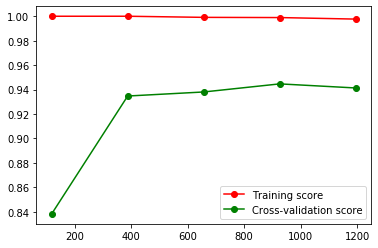

In [26]:
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
plt.legend(loc="best")

In [ ]:
cb_chord_classifier.fit(X_train, y_train)

In [21]:
y_pred = cb_chord_classifier.predict(X_test)

In [22]:
precision_score(y_test, y_pred, average="weighted")

0.9193397793507875

In [23]:
recall_score(y_test, y_pred, average="weighted")

0.918

## Test on single chords

In [153]:
Am = "am.wav"
F = "f.wav"
C = "c.wav"

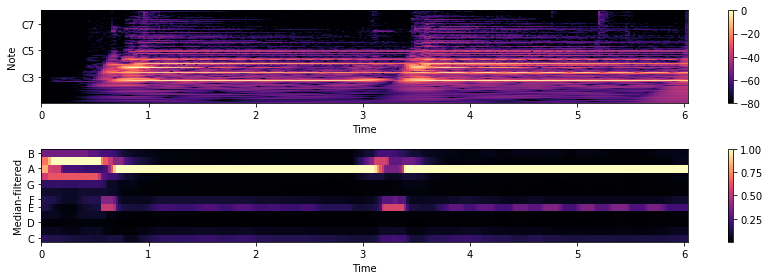

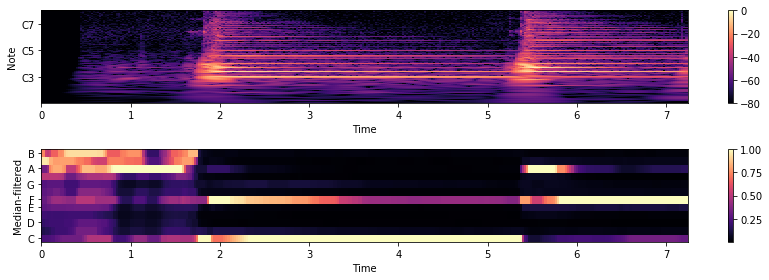

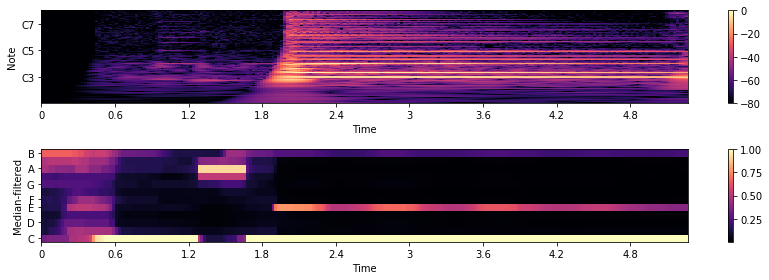

In [154]:
chord_am = get_chromagram(Am, True)
chord_f = get_chromagram(F, True)
chord_c = get_chromagram(C, True)

In [155]:
am_df = chromagram_to_df(chord_am, COLUMNS)
f_df = chromagram_to_df(chord_f, COLUMNS)
c_df = chromagram_to_df(chord_c, COLUMNS)

In [156]:
am_pred = cb_chord_classifier.predict(am_df)
f_pred = cb_chord_classifier.predict(f_df)
c_pred = cb_chord_classifier.predict(c_df)

In [157]:
am_mapped = map_chords(am_pred)
f_mapped = map_chords(f_pred)
c_mapped = map_chords(c_pred)

In [158]:
am_time = get_time_from_song(Am, am_mapped)
f_time = get_time_from_song(F, f_mapped)
c_time = get_time_from_song(C, c_mapped)

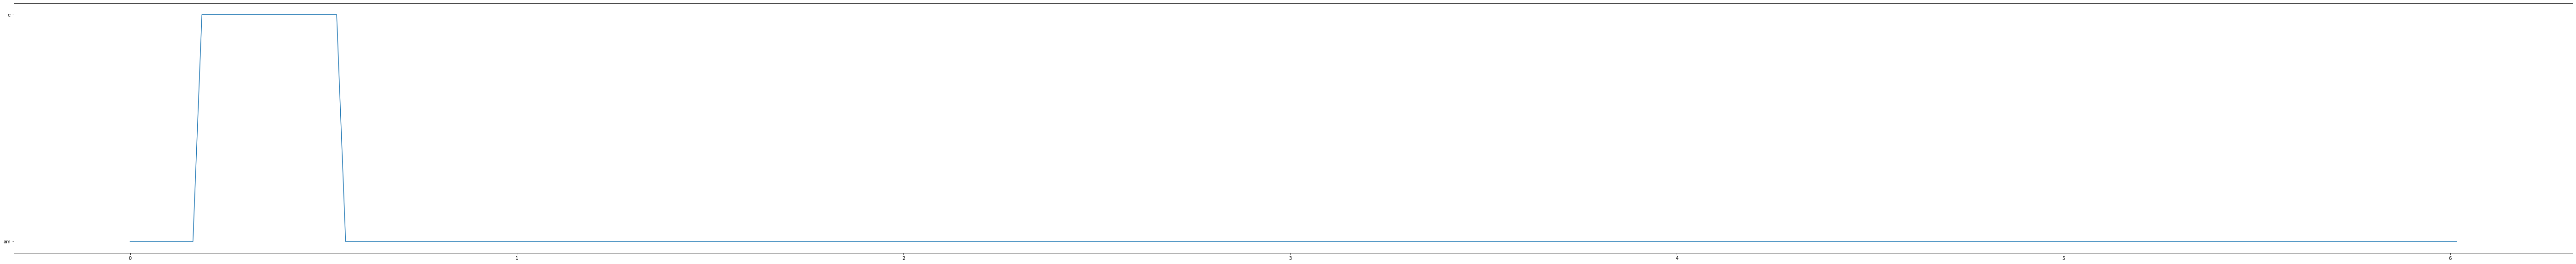

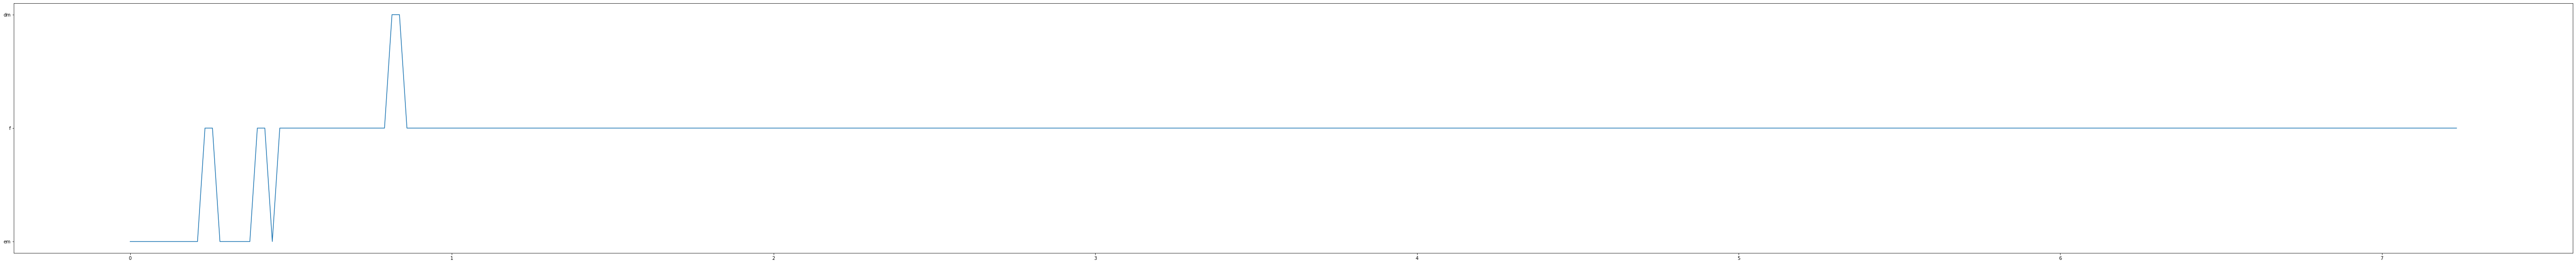

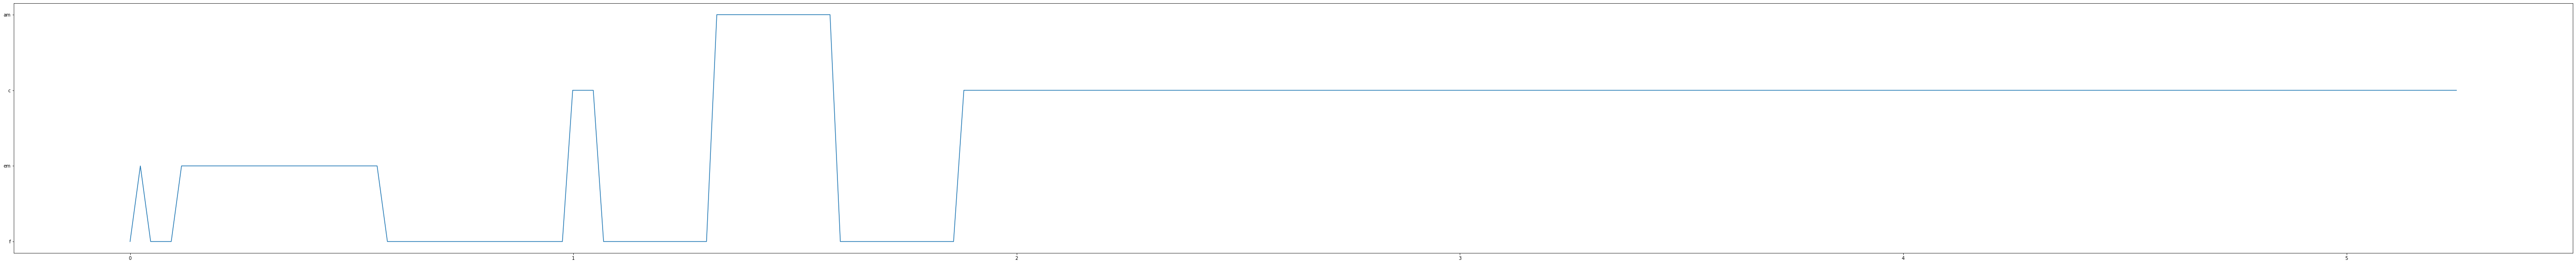

In [159]:
plt.figure(figsize=(100, 10))
plt.plot(am_time, am_mapped)
plt.figure(figsize=(100, 10))
plt.plot(f_time, f_mapped)
plt.figure(figsize=(100, 10))
plt.plot(c_time, c_mapped)

In [160]:
am_mapped = clear_chords(am_mapped, am_time)
f_mapped = clear_chords(f_mapped, f_time)
c_mapped = clear_chords(c_mapped, c_time)

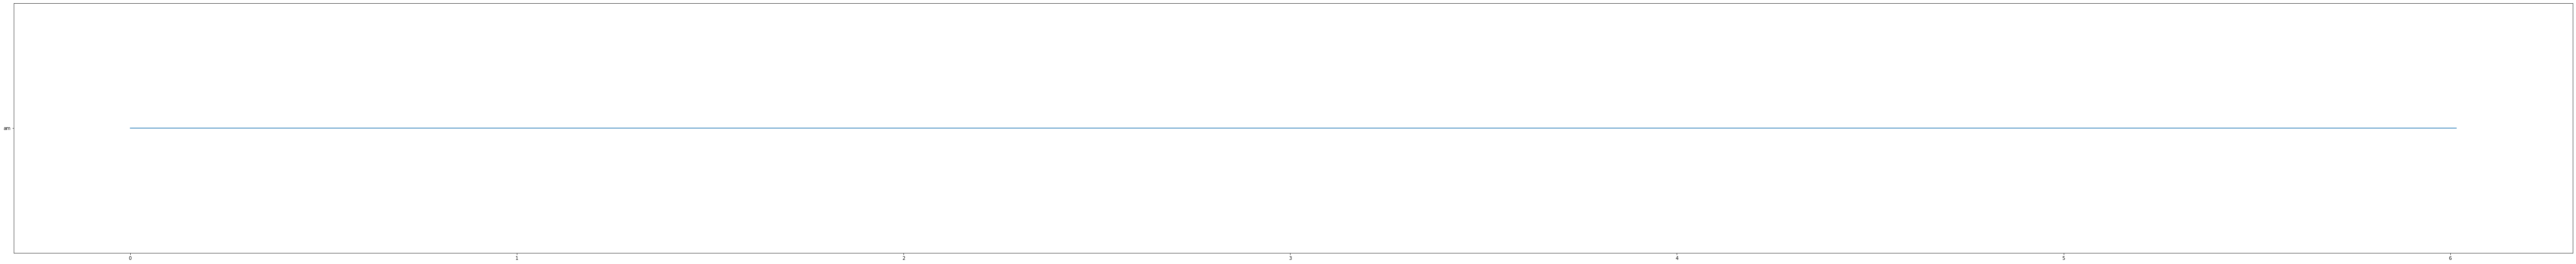

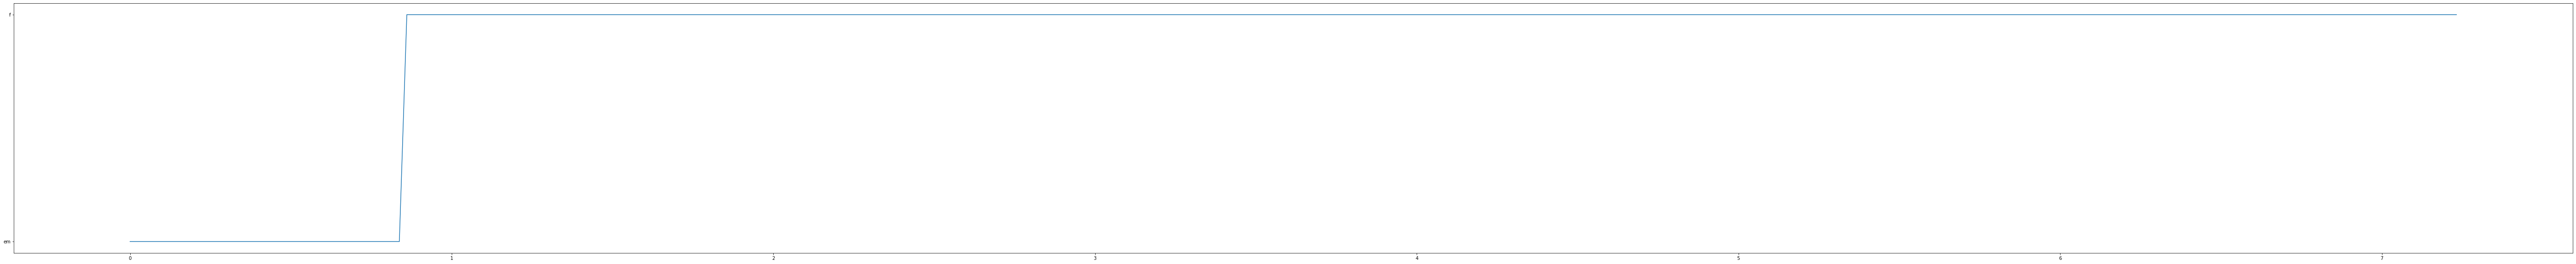

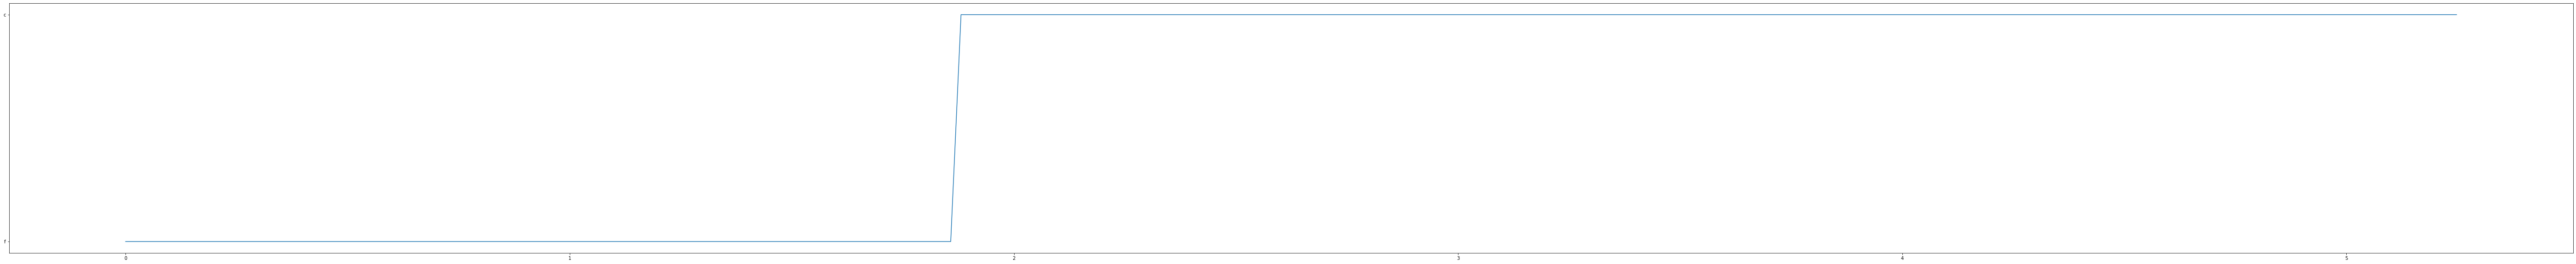

In [161]:
plt.figure(figsize=(100,10))
plt.plot(am_time, am_mapped)
plt.figure(figsize=(100,10))
plt.plot(f_time, f_mapped)
plt.figure(figsize=(100,10))
plt.plot(c_time, c_mapped)

## Operations with song and chords

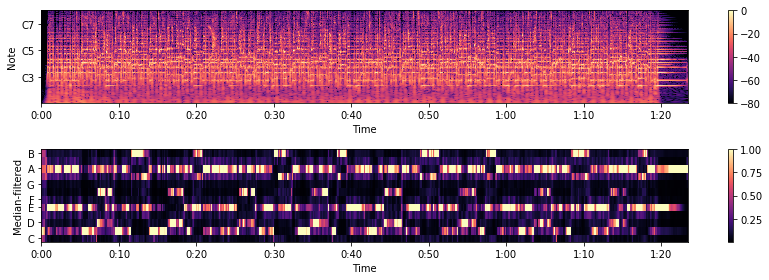

In [170]:
song_chrm = get_chromagram(TMP_SONG, True)

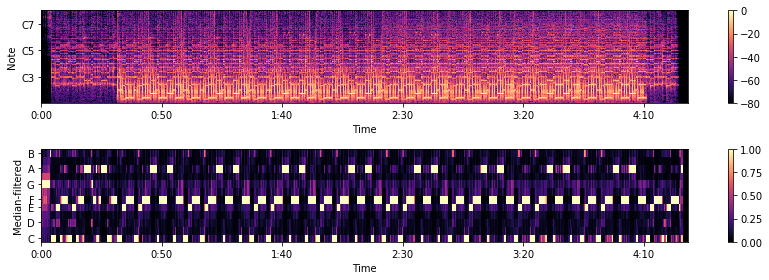

In [150]:
song_chrm = get_chromagram(SONG, True)

In [151]:
# not uses?
song_chg_chords_info = get_chord_changing_info(song_chrm)
song_chg_chords_info = [[song_chrm[i][j] for i in range(12)] 
                        for j in song_chg_chords_info]
song_chg_chords_info

[[0.2928962223499093,
  0.16822252035479998,
  0.2589488596638484,
  0.189649638371203,
  0.19134150452333773,
  0.3075822698865934,
  0.3865089636034484,
  0.721472644193439,
  0.32501512504811686,
  0.34293017462996067,
  0.3441151556047508,
  0.5594032426049622],
 [0.13407790298227387,
  0.13076378019745155,
  0.16966410590425834,
  0.1356147957836004,
  0.16076179631370816,
  0.20077150687578393,
  0.14294741223977972,
  0.45502528169417167,
  0.2227850549448901,
  0.23982825190022872,
  0.2056493484618901,
  0.9165891900806742],
 [0.08483046371016352,
  0.1019398023167482,
  0.10724704935203654,
  0.12756382534498287,
  0.11728637492629305,
  0.166739562994714,
  0.12099440412649852,
  0.3263267805706265,
  0.12354521052508377,
  0.15539910226046882,
  0.17590193452992592,
  0.9231117170795454],
 [1.0,
  0.13410980141511772,
  0.21235276876107473,
  0.06468184069314174,
  0.43116837237677164,
  0.06329191778204485,
  0.05128927899715464,
  0.17719011206489316,
  0.0385851174093632

In [24]:
song_df = chromagram_to_df(song_chrm, COLUMNS)

In [25]:
y_pred = cb_chord_classifier.predict(song_df)

In [152]:
# not use
chords = remove_and_map_chords(y_pred)

In [27]:
len(chords)

164

In [28]:
chords

['f',
 'c',
 'dm',
 'f',
 'dm',
 'f',
 'dm',
 'em',
 'dm',
 'em',
 'bm',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'dm',
 'g',
 'dm',
 'f',
 'am',
 'd',
 'am',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'f',
 'c',
 'f',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'f',
 'c',
 'f',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'd',
 'am',
 'c',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'f',
 'c',
 'f',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'f',
 'c',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'd',
 'f',
 'c',
 'f',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em

In [143]:
def map_chords(chords_indexes):
    """
    Func map chord number to chord symbol.
    
    Parameters:
        chords_indexes - index of chord.
    
    Return:
        result - string with name of chord.
    
    """
    
    mapping = {0: "a", 1: "am", 2: "bm", 3: "c", 4: "d", 5: "dm", 6: "e", 7: "em", 8: "f", 9: "g"}
    result = []
    for chord in chords_indexes:
        result.append(mapping[int(chord)])
    return result

In [133]:
mapped = map_chords(y_pred)

In [57]:
def get_duration(file_path):
    """Func returns duration of song."""
    
    y, sr = librosa.load(file_path)
    return librosa.get_duration(y=y, sr=sr)

In [130]:
def get_time_from_song(file_path, chords):
    """
    Func returns time list of song.
    
    Parameters:
        file_path - path to song.
        chords - list of chords in song.
    
    Return:
        list with equal time periods with length == len(song_chords).
        
    """
    
    duration = get_duration(file_path)
    return [duration*ind/(len(chords)-1) for ind in range(len(chords))]

In [134]:
time = get_time_from_song(SONG, mapped)

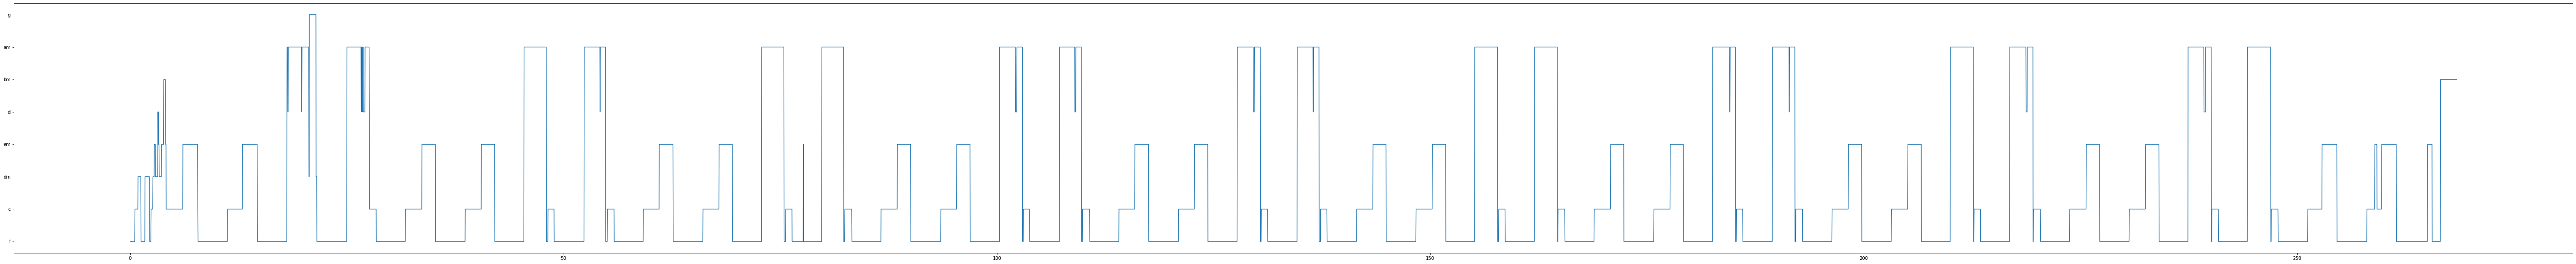

In [138]:
plt.figure(figsize=(100, 10))
plt.plot(time, mapped)

In [139]:
def clear_chords(chords, time, MIN_CHORD_DURATION=1):
    """Func clears chord list from outliers.
    
    Parameters:
        chords - list of song chords.
        time - list with chromagrams periods.
        MIN_CHORD_DURATION - min time of chord duration (in seconds).
        
    Returns:
        chords - list of clear song chords.
    
    """
    
    chords = chords.copy()
    li = 0 # low index
    last_ok = chords[0] # last correct chord
    while li < len(chords) - 1:
        last = chords[li] # last chord
        hi = li + 1 # high index
        while (hi < len(chords) - 1) and (chords[hi] == last):
            # while one chord repeats
            hi += 1

        if time[hi] - time[li] < MIN_CHORD_DURATION: 
            # if chord is too short - change on last ok
            chords[li: hi] = [last_ok for _ in range(hi-li)]        
        else:       
            # if it is a good chord - save it
            last_ok = last
        li = hi
    
    return chords

In [140]:
mapped = clear_chords(mapped, time)

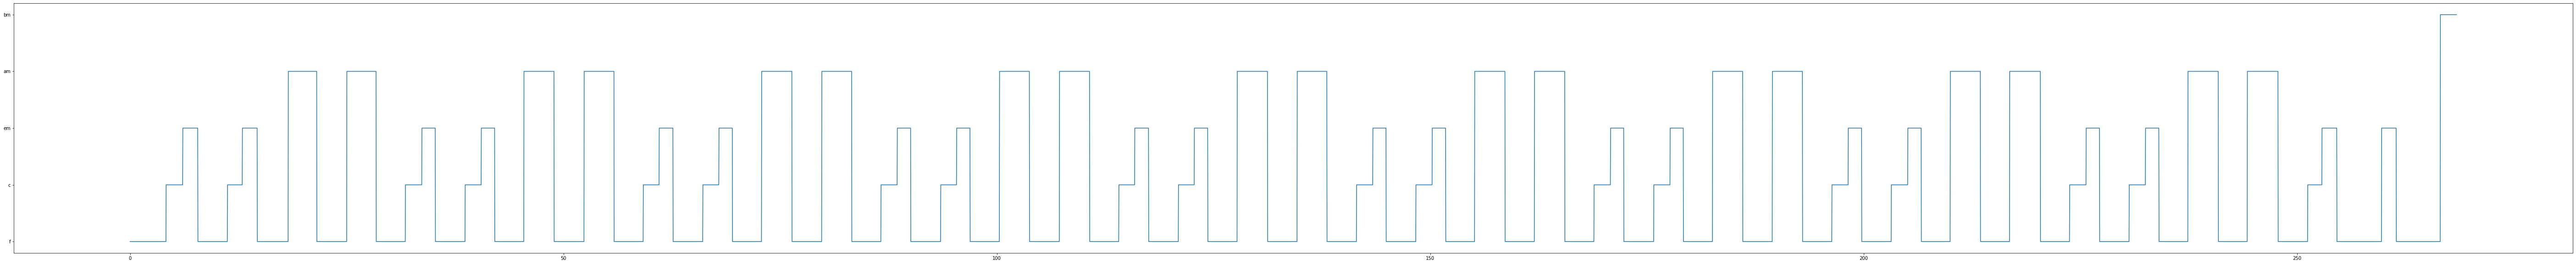

In [141]:
plt.figure(figsize=(100,10))
plt.plot(time, mapped)

## Model Loading

In [127]:
cb_chord_classifier = CatBoostClassifier()
cb_chord_classifier.load_model("cb_chord_classifier")

## Model Saving

In [173]:
cb_chord_classifier.save_model("cb_chord_classifier")